## Configuration setup
### TODO: remove unused functions, imports, variables and commented out cells
### This requires a config.py file to run
### Specify a treatment name among the options ("alternatives" & "second_line"), default is "alternatives"

In [3]:
#specify treatment
# treatment_name = "second_line"
treatment_name = "alternatives"
in_name = "manuscript_covariates_5_final"

treatment = treatment_name.capitalize()


In [4]:
#specifying input and output of the function
# in_name_1 = "manuscript_covariates_final"
in_name_2 = f"gen_uti_cohort-first-{treatment_name}"
in_name_3 = f"cache_data_uti_omop_first_{treatment_name}"

# out_name_1 = f"cohort_features_{treatment}_adverse_events_censor_v0.pkl"
# out_name_2 = f"omop_1_year_features_{treatment}_adverse_events_censor_v0.pkl"
# out_name_3 = f"cohort_features_{treatment}_treatment efficacy_censor_v0.pkl"
# out_name_4 = f"omop_1_year_features_{treatment}_treatment efficacy_censor_v0.pkl"

#out_name_5... = all the grid search files in Logs/Grid Search

## Loading Datasets

In [5]:
import psycopg2
import pandas as pd
import numpy as np

from collections import defaultdict
from sklearn.utils import resample
import sys
import time
import importlib
import sparse
import datetime
import scipy.sparse
from scipy.sparse import vstack
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import lightgbm as lgb
import pickle

from __future__ import division
from tqdm import tqdm

import gc
import warnings
warnings.filterwarnings('ignore')

import Utils.dbutils as dbutils
import Utils.data_utils as data_utils
import Generators.CohortGenerator as CohortGenerator
import Generators.FeatureGenerator as FeatureGenerator
import config
import copy
local_imports = (
    dbutils,
    data_utils,
    CohortGenerator,
    FeatureGenerator,
    config
)
for i in local_imports:
    i = importlib.reload(i)



database_name = 'omop_v6'
conn_string = "dbname="+database_name + " host=/var/run/postgresql"
conn=psycopg2.connect(conn_string)
print('Connected!')
database_name = config.DB_NAME
print(database_name)
config_path = 'postgresql://{database_name}'.format(
    database_name = database_name
)
connect_args = {"host": '/var/run/postgresql/'} # connect_args to pass to sqlalchemy create_engine function

# schemas 
schema_name = 'cdm_6871_21' # all created tables will be created using this schema
cdm_schema_name = config.OMOP_CDM_SCHEMA # the name of the schema housing your OMOP CDM tables
print(f"cdm schema: {cdm_schema_name}")
# set up database, reset schemas as needed
db = dbutils.Database(config_path, schema_name, connect_args, cdm_schema_name)

Connected!
localhost/omop_v6
cdm schema: cdm_6871_21


In [6]:
%%time
new_cohort = pd.read_sql(f"SELECT * FROM cdm_6871_21.{in_name}", conn)
new_cohort = new_cohort.loc[new_cohort.antibiotic_type.isin(['nitrofurantoin','trimethoprim-sulfamethoxazole',treatment_name])]
#initialize feature dictionary
feat_dict = defaultdict(dict)

CPU times: user 8.52 s, sys: 441 ms, total: 8.96 s
Wall time: 11.6 s


# Only run if using OMOP (optional)

## Specifying cohort and feature config

In [7]:
omop_name = f'__uti_cohort_omop_first_{treatment_name}'
cohort_script_path = config.SQL_PATH_COHORTS + f'/gen_uti_cohort-first-{treatment_name}.sql'

# cohort parameters  
params = {
          'cohort_table_name'     : omop_name,
          'schema_name'           : schema_name,
          'aux_data_schema'       : config.CDM_AUX_SCHEMA,
          'training_start_date'   : '2009-01-01',
          'dummy_date'            : '1900-01-01'
         }

cohort = CohortGenerator.Cohort(
    schema_name=schema_name,
    cohort_table_name=omop_name,
    cohort_generation_script=cohort_script_path,
    cohort_generation_kwargs=params,
    outcome_col_name='y'
)

featureSet = FeatureGenerator.FeatureSet(db)
featureSet.add_default_features(
    ['drugs_relative','conditions_relative','procedures_relative','specialty_relative'],
    schema_name,
    omop_name
)

## Building cohort and omop features.  I have already built the table and the features so you can use replace=False flag, and from_cached=True to retrieve them assuming access to the  cache_data_path and cohort_script_path

In [8]:
%%time
cohort.build(db, replace=False)

Table already exists, set replace=True to rebuild
CPU times: user 584 ms, sys: 0 ns, total: 584 ms
Wall time: 1.85 s


In [9]:
%%time
# Build the Feature Set by executing SQL queries and reading into sparse matrices
cache_data_path = f'/data/ibc_6871_21/ncjones_ibc/cache_data_uti_omop_first_{treatment_name}'
featureSet.build(cohort, from_cached=True, cache_file=cache_data_path)

Got Unique Concepts and Timestamps in 34.05 seconds
Created Index Mappings in 0.02 seconds
36445
Generated Sparse Representation of Data in 60.57 seconds
CPU times: user 1min 26s, sys: 3.54 s, total: 1min 29s
Wall time: 1min 34s


##  Loading Feature matrices

In [10]:
outcomes_filt, feature_matrix_3d_transpose, remap, good_feature_names = \
    FeatureGenerator.postprocess_feature_matrix(cohort, featureSet,training_end_date_col='dummy_date')

### OMOP Features

In [11]:
%%time
#1 year

feature_matrix_counts_1, feature_names_1 = data_utils.window_data(
    window_lengths = [3,7,30,180,365],
    feature_matrix = feature_matrix_3d_transpose,
    all_feature_names = good_feature_names,
    cohort = cohort,
    featureSet = featureSet,
    cohort_end_date_col='dummy_date'
)


CPU times: user 28.4 s, sys: 139 ms, total: 28.6 s
Wall time: 28.6 s


### Add antibiotic feature to omop features

In [12]:
%%time 

#filtering for feature columns
feature_dict = featureSet.__dict__['id_map_rev']
feature_set = list(feature_dict.values())
ids_to_exclude = [x for x in feature_set if x not in remap['id']]
new_feature_dict = {k:v for k,v in feature_dict.items() if v not in ids_to_exclude}


new_cohort = new_cohort.loc[new_cohort.condition_occurrence_id.isin(list(new_feature_dict.keys()))]
new_cohort = new_cohort.set_index('condition_occurrence_id')
new_cohort = new_cohort.reindex(list(new_feature_dict.keys()))
new_cohort = new_cohort.reset_index()

filtered_cohort = new_cohort.copy()
filtered_cohort['treatment_'] = filtered_cohort.antibiotic_type == treatment_name

#combining features

combined_features_1 = vstack([feature_matrix_counts_1, scipy.sparse.csr_matrix(filtered_cohort['treatment_'])]).T
combined_feature_names_1 = feature_names_1 + ['treatment_']


#update feat_dict
feat_dict['treatment']["omop_1_year_features"] = (feature_matrix_counts_1.T, feature_names_1)
feat_dict['censor']["omop_1_year_features"] = (combined_features_1, combined_feature_names_1)





CPU times: user 9.23 s, sys: 106 ms, total: 9.33 s
Wall time: 9.33 s


# End of OMOP Portion (currently not optional because the dataframe size of new cohort changes when adding negatives)

In [13]:
%%time 

filtered_cohort = new_cohort.copy()


cols_to_exclude = [
'no_previous_180_excluded_event',
'no_previous_180_day_event',
'no_two_previous_365_day_event',
 'no_previous_excluded_event_ever',
'previous_uti_condition_occurence_id',
 'multi',
 'year_of_birth',
'level_0',
 'index',
 'condition_occurrence_id',
 'person_id',
 'condition_concept_id',
 'condition_start_date',
 'condition_start_datetime',
 'condition_end_date',
 'condition_end_datetime',
 'visit_occurrence_id',
 'visit_detail_id',
 'drug_concept_id',
 'drug_name',
 'antibiotic_name',
 'antibiotic_type',
 'visit_provider_id',
 'drug_exposure_id',
 'drug_exposure_start_date',
 'drug_exposure_start_datetime',
 'provider_id',
 'provider_name',
 'npi',
 'post_UTI_codes',
 'recurrent_uti',
 'first_uti',
 'followup_time',
 't_sum',
 't_bin',
 't_uti_bin',
 't_neph_bin',
 'AE_c_diff',
 'AE_GI',
 'AE_skin',
 'AE_AKI',
 'AE_other',
 't_sepsis_sum',
 't_i_sepsis_sum',
 't_i_uti_sum',
 't_i_neph_sum',
 't_sepsis_bin',
 't_i_uti_bin',
 't_i_neph_bin',
 't_i_sepsis_bin',
 't_i_sum',
 't_uti_sum',
 't_neph_sum',
 't_i_bin','AE_any','less_15','less_30','less_90','followup_time'] + \
 [x for x in filtered_cohort.columns if 'full_condition_name' in x] + \
 ['fibro_' + m + '_mon_outcome' for m in ['1','3','6']] + \
 ['hernia_' + m + '_mon_outcome' for m in ['1','3','6']] + \
 ['fracture_' + m + '_mon_outcome' for m in ['1','3','6']]
cohort_features = filtered_cohort.drop(columns=cols_to_exclude)
print(sorted(cohort_features.columns))

['ab_temp', 'addison0_6_months', 'addison1_2_yr', 'addison6_months_1_yr', 'age', 'alternatives_0_to_6_mo', 'alternatives_12_to_24_mo', 'alternatives_1_to_7_days', 'alternatives_6_to_12_mo', 'alternatives_most_recent', 'alternatives_switch_ever', 'alternatives_switch_recent', 'arthritis0_6_months', 'arthritis1_2_yr', 'arthritis6_months_1_yr', 'arthritis_concept_ancestor0_6_months', 'arthritis_concept_ancestor1_2_yr', 'arthritis_concept_ancestor6_months_1_yr', 'autoimmune_concept_ancestor0_6_months', 'autoimmune_concept_ancestor1_2_yr', 'autoimmune_concept_ancestor6_months_1_yr', 'band_nphil_0', 'band_nphil_0_exists', 'band_nphil_p100_0', 'band_nphil_p100_0_exists', 'basophil_p100_0', 'basophil_p100_0_exists', 'bil_p_urine_0', 'bil_p_urine_0_exists', 'blasts_0', 'blasts_0_exists', 'body_temp_0', 'body_temp_0_exists', 'body_temp_s_0', 'body_temp_s_0_exists', 'cancer0_6_months', 'cancer1_2_yr', 'cancer6_months_1_yr', 'cancer_concept_ancestor0_6_months', 'cancer_concept_ancestor1_2_yr', 'ca

## Create outcome and feature dictionary

In [14]:
outcome_dict = {'treatment':{'first_line':(1*(filtered_cohort.antibiotic_type=="nitrofurantoin") + 1*(filtered_cohort.antibiotic_type=="trimethoprim-sulfamethoxazole")),
                             'second_line':1*filtered_cohort.antibiotic_type=='second_line',
                             'alternatives':1*filtered_cohort.antibiotic_type=='alternatives'},
                'censor' : {'15':1*filtered_cohort.less_15==0,
                                 '30':1*filtered_cohort.less_30==0,
                                 '90':1*filtered_cohort.less_90==0}
                    
}


mod_cohort_features = cohort_features.copy()
mod_cohort_features['treatment_'] = 1*(filtered_cohort.antibiotic_type==treatment_name)


#update feature dictionary
feat_dict['treatment']["cohort_features"] = (scipy.sparse.csr_matrix(cohort_features.values), list(cohort_features.columns))
feat_dict['censor']["cohort_features"] =  (scipy.sparse.csr_matrix(mod_cohort_features.values), list(mod_cohort_features.columns))
              


## Show Variable Shapes

In [15]:
print("Treatment variable shapes")
print("features")
for key, value in feat_dict["treatment"].items():
    print(key, value[0].shape)
print("outcomes")
for key, value in outcome_dict["treatment"].items():
    print(key, value.shape)
    
    
print("\n\nCensor variable shapes")
print("features")
for key, value in feat_dict["censor"].items():
    print(key, value[0].shape)

print("outcomes")
for key, value in outcome_dict["censor"].items():
    print(key, value.shape)


Treatment variable shapes
features
omop_1_year_features (36445, 131035)
cohort_features (36445, 296)
outcomes
first_line (36445,)
second_line (36445,)
alternatives (36445,)


Censor variable shapes
features
omop_1_year_features (36445, 131036)
cohort_features (36445, 297)
outcomes
15 (36445,)
30 (36445,)
90 (36445,)


# Analysis

In [16]:
##Grid Search and plotting Helper Functions
def run_logreg(matrix : scipy.sparse.csr.csr_matrix, y, CV=False,folds=3,params=None,search=False,add_propensity=False):
    sparse_features = scipy.sparse.csr_matrix(matrix)
    X, T = sparse_features, y.values
    # build model for p(t=1|x); prob of getting first-line antibiotic 
    X_Train, X_Test, T_Train, T_Test = train_test_split(X, T, test_size = 0.2, random_state = 0)

    X_Dev, X_Val, T_Dev, T_Val = train_test_split(X_Train, T_Train, test_size=0.25, random_state=0)
    
    scaler = MaxAbsScaler()
    X_Train = scaler.fit_transform(X_Train)
    X_Test = scaler.transform(X_Test)
    
    X_Dev = scaler.fit_transform(X_Dev)
    X_Val = scaler.transform(X_Val)

    if search:
        C=[.01,.1,.25,.5,1]
        penalty=['l1','l2']
        params_names = ["C","penalty"]

        if not CV:
            best_params, best_score = [0.1, 'l1'], float('-inf')
            for c in C:
                for p in penalty:
                    model = LogisticRegression(random_state=0, penalty=p, C=c, solver='liblinear')
                    model.fit(X_Dev, T_Dev)
                    s = roc_auc_score(T_Val, model.predict_proba(X_Val)[:,1])
                    # print(c,p,s)
                    if s > best_score:
                        best_params, best_score = [c,p], s

            classifier = LogisticRegression(random_state=0, penalty=best_params[1], C=best_params[0], solver='liblinear')
            best_params = dict(zip(params_names,best_params))
        else:
            clf = GridSearchCV(LogisticRegression(C=0.25, penalty='l1',solver='liblinear', random_state=0,verbose=0),
                               param_grid={'C':C,'penalty':penalty},cv=folds,scoring="roc_auc",refit=True
                         )
            clf.fit(X_Train,T_Train)
            classifier = clf.best_estimator_
            best_params = clf.best_params_
            best_score = clf.best_score_
    else:
        classifier = LogisticRegression(random_state=0, penalty=params['penalty'], C=params['C'], solver=params['solver'])
        best_params = params
        best_score = None
    classifier.fit(X_Train, T_Train)

    T_Pred = classifier.predict(X_Test)
    T_Pred_Prob = classifier.predict_proba(X_Test)
#     print("Accuracy:", np.round(metrics.accuracy_score(T_Test, T_Pred), 4))


    acc = np.round(metrics.accuracy_score(T_Test, T_Pred), 4)
    fpr, tpr, threshold = (metrics.roc_curve(T_Test, T_Pred_Prob[:,1]))
    roc_auc = metrics.auc(fpr, tpr)
    
    if add_propensity:
        cohort = filtered_cohort.copy()
        classifier.fit(X, T)
        cohort['propensity_score'] = np.clip(classifier.predict_proba(X)[:,1], 0.025, 0.975)
        cohort['treatment'] = y
        return cohort, classifier, best_params, best_score, (acc,roc_auc,fpr, tpr)
    else:
        return classifier

from sklearn.ensemble import RandomForestClassifier



# modified for omop
def run_rf(matrix, y, CV=False,folds=3,search=False,params=None,add_propensity=False):
    sparse_features = scipy.sparse.csr_matrix(matrix)
    X, T = sparse_features, y.values
    # build model for p(t=1|x); prob of getting first-line antibiotic 
    X_Train, X_Test, T_Train, T_Test = train_test_split(X, T, test_size = 0.2, random_state = 0)

    X_Dev, X_Val, T_Dev, T_Val = train_test_split(X_Train, T_Train, test_size=0.25, random_state=0)
    
    scaler = MaxAbsScaler()
    X_Train = scaler.fit_transform(X_Train)
    X_Test = scaler.transform(X_Test)
    
    X_Dev = scaler.fit_transform(X_Dev)
    X_Val = scaler.transform(X_Val)

    max_features=['auto', 'sqrt', 'log2']
    n_estimators=[60, 80, 100, 120, 140]
    min_samples_leaf=[25, 50, 75]
    params_names = ["max_features","n_estimators","min_samples"]
    
    
    if search:
        if not CV:
            best_params, best_score = [max_features[0], n_estimators[0], min_samples_leaf[0]], float('-inf')

            for f in max_features:
                for e in n_estimators:
                    for l in min_samples_leaf:
                        model=RandomForestClassifier(random_state=0, n_estimators = e, max_features = f, min_samples_leaf = l)
                        model.fit(X_Dev, T_Dev)
                        s = roc_auc_score(T_Val, model.predict_proba(X_Val)[:,1])
                        # print(c,p,s)
                        if s > best_score:
                            best_params, best_score = [f, e, l], s


            # #Train the model using the training sets y_pred=model.predict(X_test)
            classifier = RandomForestClassifier(random_state=0, max_features=best_params[0],n_estimators=best_params[1],min_samples_leaf=best_params[2])
            best_params = dict(zip(params_names,best_params))
        else:
            clf = GridSearchCV(RandomForestClassifier(n_estimators=100, max_features="auto",min_samples_leaf=50, random_state=0),
                               param_grid={'max_features':max_features,'n_estimators':n_estimators, "min_samples_leaf":min_samples_leaf},cv=folds,scoring="roc_auc",refit=True
                         )
            clf.fit(X_Train,T_Train)
            classifier = clf.best_estimator_
            best_params = clf.best_params_
            best_score = clf.best_score_
    else:
        classifier = RandomForestClassifier(random_state=0, n_estimators=params['n_estimators'], max_features=params['max_features'], min_samples_leaf=params['min_samples_leaf'])
        best_params = params
        best_score = None

    classifier.fit(X_Train, T_Train)

    T_Pred = classifier.predict(X_Test)
    T_Pred_Prob = classifier.predict_proba(X_Test)
#     print("Accuracy:", np.round(metrics.accuracy_score(T_Test, T_Pred), 4))

    acc = np.round(metrics.accuracy_score(T_Test, T_Pred), 4)
    fpr, tpr, threshold = (metrics.roc_curve(T_Test, T_Pred_Prob[:,1]))
    roc_auc = metrics.auc(fpr, tpr)

    
    if add_propensity:
        cohort = filtered_cohort.copy()
        classifier.fit(X, T)
        cohort['propensity_score'] = np.clip(classifier.predict_proba(X)[:,1], 0.025, 0.975)
        cohort['treatment'] = y
        return cohort, classifier, best_params, best_score, (acc,roc_auc,fpr, tpr)
    else:
        return classifier

def run_lgbm(matrix, y, add_propensity=False,CV=False,folds=3,search=True,params=None):
    sparse_features = scipy.sparse.csr_matrix(matrix)
    X, T = sparse_features, y.values
    # build model for p(t=1|x); prob of getting first-line antibiotic 

    X_Train, X_Test, T_Train, T_Test = train_test_split(X, T, test_size = 0.2, random_state = 0)

    X_Dev, X_Val, T_Dev, T_Val = train_test_split(X_Train, T_Train, test_size=0.25, random_state=0)
    
    scaler = MaxAbsScaler()
    X_Train = scaler.fit_transform(X_Train)
    X_Test = scaler.transform(X_Test)
    
    X_Dev = scaler.fit_transform(X_Dev)
    X_Val = scaler.transform(X_Val)

    boosting_type=["gbdt","dart"]
    if not search:
        learning_rates=[ .05]
        num_leaves=[50]
        if params:
            lr = params["learning_rate"]
            num_leaves = params["num_leaves"]
            classifier = lgb.LGBMClassifier(random_state=0,learning_rate=lr,num_leaves=num_leaves)
            best_params = params
            best_score = None

    else:
        learning_rates=[.001,.005, .01, .05, .1]
        num_leaves=[10,50,100,250]
        params_names = ["learning_rate","num_leaves"]
    
        if not CV:
            best_params, best_score = [learning_rates[0], num_leaves[0]], float('-inf')

            for l in learning_rates:
                for n in num_leaves:
                    model = lgb.LGBMClassifier(num_leaves=n, learning_rate=l,random_state=0)
                    model.fit(X_Dev, T_Dev)
                    s = roc_auc_score(T_Val, model.predict_proba(X_Val)[:,1])
                    # print(c,p,s)
                    if s > best_score:
                        best_params, best_score = [l, n], s


            # #Train the model using the training sets y_pred=model.predict(X_test)
            classifier = lgb.LGBMClassifier(random_state=0,learning_rate=best_params[0],num_leaves=best_params[1])
            best_params = dict(zip(params_names,best_params))
            best_params["boosting_type"] = 'gbdt'
        else:
            clf = GridSearchCV(lgb.LGBMClassifier(boosting_type="gbdt", learning_rate=.01,num_leaves=50, random_state=0),
                               param_grid={'boosting_type':boosting_type,'learning_rate':learning_rates, "num_leaves":num_leaves},cv=folds,scoring="roc_auc",refit=True
                         )
            clf.fit(X_Train,T_Train)
            classifier = clf.best_estimator_
            best_params = clf.best_params_
            best_score = clf.best_score_        

    classifier.fit(X_Train, T_Train)

    T_Pred = classifier.predict(X_Test)
    T_Pred_Prob = classifier.predict_proba(X_Test)
#     print("Accuracy:", np.round(metrics.accuracy_score(T_Test, T_Pred), 4))


    acc = np.round(metrics.accuracy_score(T_Test, T_Pred), 4)
    fpr, tpr, threshold = (metrics.roc_curve(T_Test, T_Pred_Prob[:,1]))
    roc_auc = metrics.auc(fpr, tpr)


    if add_propensity:
        cohort = filtered_cohort.copy()
        classifier.fit(X, T)
        cohort['propensity_score'] = np.clip(classifier.predict_proba(X)[:,1], 0.025, 0.975)
        cohort['treatment'] = y
#         param_dictionary = dict(zip(params_names,best_params))
#         param_dictionary["boosting_type"] = "gbdt"


        return cohort, classifier, best_params, best_score, (acc,roc_auc,fpr, tpr)
    else:
        return classifier
    
def compute_roc_auc(auc_metrics, name=None, show=None):
    roc_auc, fpr, tpr = auc_metrics
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    if name:
        plt.savefig(name)
    if not show:
        plt.close()

def build_model(feature,outcome,y,model,cv=False,folds=3):
    #assumes the functions can actually generate these things
    if model == 1:
        cohort, clf, params, scores, metric = run_logreg(feat_dict[outcome][feature][0],y,CV=cv,folds=folds,add_propensity=True)
        return cohort, clf, params, scores, metric
    elif model == 2:
        cohort, clf, params, scores, metric = run_rf(feat_dict[outcome][feature][0],y,CV=cv,folds=folds,add_propensity=True)
        return cohort, clf, params, scores, metric
    elif model == 3:
        cohort, clf, params, scores, metric = run_lgbm(feat_dict[outcome][feature][0],y,CV=cv,folds=folds,add_propensity=True)
        return cohort, clf, params, scores, metric
        
def reweighting(cohort,name=None,show=False):
    '''
    Input: cohort with a propensity column named propensity_score and antibiotic type column
           treatment name
    
    return plot'''
    first_line, non_first_line = cohort[cohort['treatment']==1], cohort[cohort['treatment']==0]
    n = cohort.shape[0]

    age_range = np.arange(int(cohort.age.min()), int(cohort.age.max()+1))
    counts1, counts0 = [], []
    for a in age_range:
        counts1.append(sum(1/first_line[first_line.age==a].propensity_score))
        counts0.append(sum(1/(1-non_first_line[non_first_line.age==a].propensity_score)))


    fig, axs = plt.subplots(1,2, figsize=(12, 5))
    # plt.rcParams["figure.figsize"] = [7.50, 5.50]
    # plt.rcParams["figure.autolayout"] = True
    axs[0].fill_between(age_range, counts1, step="pre", alpha=0.5, label='First-line')
    axs[0].fill_between(age_range, counts0, step="pre", alpha=0.5, label=treatment)

    # plt.plot(range(18,100),counts1, drawstyle="steps")
    # plt.plot(range(18,100),counts0, drawstyle="steps")
    axs[0].set_title("Age distribution reweighted by propensity scores", size=13)

    axs[1].hist(first_line.age, bins=88, alpha=0.5, label="First-line");
    axs[1].hist(non_first_line.age, bins=88, alpha=0.5, label=treatment)
    axs[1].set_title("Age distribution before reweighting", size=13)

    for ax in axs:
        ax.set_xlabel("Age", size=11)
        ax.set_ylabel("Count", size=11)
        ax.legend()

    avg1 = np.average(age_range, weights=counts1)
    avg0 = np.average(age_range, weights=counts0)
    avg_all = np.average(age_range, weights=np.array(counts1)+np.array(counts0))
    sigma = np.sqrt(np.average((age_range-avg_all)**2, weights=np.array(counts1)+np.array(counts0)))
    age_diff = (avg1-avg0)/sigma
    
    if name:
        plt.savefig(name)
    if not show:
        plt.close()
    return fig, age_diff
    
     
def propensity(cohort,name=None,show=False):
    '''
    Input: cohort with a propensity column named propensity_score and antibiotic type column
           treatment name
    
    return plot'''

    plt.figure(figsize=(8,6))
    t1 = cohort[cohort['treatment']==1].propensity_score
    t2 = cohort[cohort['treatment']==0].propensity_score
    weight1 = np.ones_like(t1) / len(t1)
    weight2 = np.ones_like(t2) / len(t2)

    plt.hist(t1, weights=weight1, bins=50, alpha=0.5, label="First line (T=1)")
    plt.hist(t2, weights=weight2, bins=50, alpha=0.5, label=f"{treatment} (T=0)")

    plt.xlabel("Propensity score", size=14)
    plt.ylabel("Count", size=14)
    plt.title(f"Distribution of Propensity Scores (First line vs {treatment})")
    plt.legend(loc='upper right')
    # plt.savefig("overlapping_histograms_with_matplotlib_Python.png")
    if name:
        plt.savefig(name)
    if not show:
        plt.close()
    return plt
    
def calibration(cohort,name=None,show=False):
    '''
    Input: cohort with a propensity column named propensity_score and antibiotic type column
           treatment name
    
    return plot'''
   
    bins = [np.quantile(cohort.propensity_score, x/8) for x in range(9)]
    df_cali = pd.DataFrame(columns=['pred', 'actual', 'errorbar'])
    for i in range(8):
        temp = cohort[(cohort.propensity_score>=bins[i]) & (cohort.propensity_score<=bins[i+1])]
        x = np.mean(temp.propensity_score)
        y = len(temp[temp['treatment']==1])/len(temp)
        std = np.std(temp.propensity_score)
        df_cali.loc[len(df_cali)] = [x,y,1.96*std]

    fig = plt.figure()
    # plt.plot(df_cali.pred, df_cali.actual, '-o')
    plt.errorbar(df_cali.pred, df_cali.actual, yerr=df_cali.errorbar, fmt='o', ls='--')
    plt.plot([0, 1], [0, 1], ls='--')
    plt.xlabel('Mean predicted probability')
    plt.ylabel('Fraction of positives')
    plt.title('Calibration Plot for '+treatment)
    if name:
        plt.savefig(name)
    if not show:
        plt.close(fig)
    return fig

import pathlib
def generate_plots(model_config=None,model=None, outcome=None,build=False, show_results=False,log_name="logs"):
    if outcome == None:
        print(RaiseExceptionError("Outcome variable not specified"))
    feat_name = model_config["name"]
    #directory: treatment/outcome variable/feature/
    dir_name = f"Logs_2023/Grid search/{log_name}_{treatment.lower()}/{model_config['outcome']}/{model_config['feature']}/"
    pathlib.Path(dir_name).mkdir(parents=True, exist_ok=True) 
    
    f_name =  dir_name + feat_name


    
    if build and model_config==None:
        cohort, clf, params, score, metrics = build_model(featureset,outcome,model)
    else:
        model = model_config["model_num"]
        cohort = model_config["cohort"]
        clf = model_config["clf"]
        params = model_config["params"]
        score = model_config["score"]
        metrics = model_config["metrics"]
        accuracy, roc_auc, fpr, tpr = metrics
        roc_auc_metrics = (roc_auc, fpr, tpr)
        featureset = model_config["feature"]
        params = model_config["params"]
    model_index = model-1
    if model == 1:
        importances = clf.coef_[0]
    else:
        importances = clf.feature_importances_
    
    imp_name =  feat_imp[model_index]
    df_coef = pd.DataFrame(list(zip(feat_dict[outcome][featureset][1], importances)), columns=['feature',imp_name])
    feat_pd = df_coef.iloc[(-df_coef[imp_name].abs()).argsort()].head(100)
    feat_pd.to_csv(f_name + "_top_features.csv")

    if show_results:
        show=True
    else:
        show=False
        
    acc_pd = pd.DataFrame(np.array([[accuracy],[roc_auc]]).reshape(1,2),columns=["accuracy","roc_auc"])
    acc_pd.to_csv(f_name + "_metrics.csv")

    auc_name = f_name + "_roc_auc.png"
    compute_roc_auc(roc_auc_metrics,name=auc_name,show=show)
    
    r_name = f_name + "_reweighting.png"
    val, age_diff = reweighting(cohort,name=r_name,show=show)
    age_diff_pd = pd.DataFrame([age_diff], columns=["standardized age difference"])
    
    age_diff_pd.to_csv(f_name + "_age_diff.csv")
    
    p_name = f_name + "_propensity.png"
    p_plot = propensity(cohort,name=p_name,show=show)
    
    c_name = f_name + "_calibration.png"
    c_plot = calibration(cohort,name=c_name,show=show)
    
    
    param_df = pd.DataFrame(np.array(list(params.values())).reshape(1,len(params.values())),columns=list(params.keys()))
    param_df.to_csv(f_name + "_best_params.csv")
    
    if show_results:
        print(featureset.upper(), f"BEST MODEL ({model_list[model_index].upper()})")
        
        print(f"Accuracy: {accuracy}")
        print(f"ROC_AUC: {roc_auc:.4}")
        print(f"Best params: {params}")
        print(f"feat_size {df_coef.shape}")
        print("feature_importances")
        display(feat_pd.head(30))
        print("age reweighted standardized difference: ",age_diff)
    


##  Hyperparameter Tuning Models (optional)

In [ ]:
# #sanity check we're getting both features
# grid_params ={'censor' : {'outcome_names':['15','30','90'],'feats':feat_dict['censor']},
#               'treatment' : {'outcome_names':[treatment_name],'feats': feat_dict['treatment']}}


# #NOAH ADDED NEW GRID SEARCH FUNCTIONALITY FOR OUTCOME
# outcomes = ['censor','treatment']
# for outcome in outcomes:

#     grid_features= list(grid_params[outcome]['feats'].keys())

In [81]:
grid_features

['omop_1_year_features', 'cohort_features']

## checking grid search results to see if it even makes a difference in my ate analysis with 100 bootstrap samples and then 1000(?), need to swap parameters first

In [82]:
%%time
#choose the parameter model combo

#change grid_params if grid searching over treatment outcome instead of censor outcome

custom_all_best_hyperparams = {}
custom_grid_params ={'censor' : {'outcome_names':['30'],'feats':feat_dict['censor']},
              'treatment' : {'outcome_names':[treatment_name],'feats': feat_dict['treatment']}}

best_models = []
custom_all_models = []
#NOAH ADDED NEW GRID SEARCH FUNCTIONALITY FOR OUTCOME
outcomes = ['censor','treatment']
for outcome in outcomes:
#     grid_features= list(custom_grid_params[outcome]['feats'].keys())
    grid_features = ['cohort_features']
    grid_outcomes = [(k,v) for k,v in outcome_dict[outcome].items() if k in custom_grid_params[outcome]['outcome_names']]


    feat_imp = ["Coefficient","Gini importance","Number of splits"]
    model_list = ["Logistic_Regression","Random_Forest","LGBM"]


    for out_name, out_val in grid_outcomes:
        y = out_val
        for f in grid_features:
            best_score = -float("inf")
            for m in range(1,4):
                #add outcome_name to model feature dictionary
                cohort, clf, params, score, metric = build_model(f,outcome,y,m,cv=True,folds=5)
                model_feature = {"name":f"{model_list[m-1]}","outcome":out_name, "score":score,"feature":f,"model_num":m,"metrics":metric,"params":params,"clf":clf,"cohort":cohort}
                custom_all_models.append(model_feature)
                if score > best_score:
                    best_score = score
                    best_model_num = m
                    best_params = params
                    best_metric = metric
                    best_clf = clf
                    best_cohort = cohort

            print(f"{f} with {out_name} {outcome} outcome models DONE.")
            print("BEST MODEL WAS ", f"{model_list[best_model_num-1]} with ROC_AUC score: {best_score}")
            print(f"Best params are: {best_params}")
            best_model_feature = {"name":f"{model_list[best_model_num-1]}","score":best_score,"feature":f,"model_num":best_model_num,"metrics":best_metric,"params":best_params,"clf":best_clf,"cohort":best_cohort}
            best_models.append(best_model_feature)
            
            #loading the best params into dictionary
            best_params['clf'] = model_list[best_model_num-1]
            custom_all_best_hyperparams.setdefault(f, {}).setdefault(treatment_name, {})[out_name] = best_params



cohort_features with 30 censor outcome models DONE.
BEST MODEL WAS  LGBM with ROC_AUC score: 0.6398692308966687
Best params are: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'num_leaves': 10}
cohort_features with alternatives treatment outcome models DONE.
BEST MODEL WAS  Logistic_Regression with ROC_AUC score: 0.7105481406436537
Best params are: {'C': 0.5, 'penalty': 'l1'}
CPU times: user 4h 24min 49s, sys: 26min 7s, total: 4h 50min 57s
Wall time: 48min 37s


In [51]:
%%time
#choose the parameter model combo

#change grid_params if grid searching over treatment outcome instead of censor outcome

all_best_hyperparams = {}
grid_params ={'censor' : {'outcome_names':['15','30','90'],'feats':feat_dict['censor']},
              'treatment' : {'outcome_names':[treatment_name],'feats': feat_dict['treatment']}}

best_models = []
all_models = []
#NOAH ADDED NEW GRID SEARCH FUNCTIONALITY FOR OUTCOME
outcomes = ['censor','treatment']
for outcome in outcomes:

    grid_features= list(grid_params[outcome]['feats'].keys())
    grid_outcomes = [(k,v) for k,v in outcome_dict[outcome].items() if k in grid_params[outcome]['outcome_names']]


    feat_imp = ["Coefficient","Gini importance","Number of splits"]
    model_list = ["Logistic_Regression","Random_Forest","LGBM"]


    for out_name, out_val in grid_outcomes:
        y = out_val
        for f in grid_features:
            best_score = -float("inf")
            for m in range(1,4):
                #add outcome_name to model feature dictionary
                cohort, clf, params, score, metric = build_model(f,outcome,y,m,cv=True,folds=3)
                model_feature = {"name":f"{model_list[m-1]}","outcome":out_name, "score":score,"feature":f,"model_num":m,"metrics":metric,"params":params,"clf":clf,"cohort":cohort}
                all_models.append(model_feature)
                if score > best_score:
                    best_score = score
                    best_model_num = m
                    best_params = params
                    best_metric = metric
                    best_clf = clf
                    best_cohort = cohort

            print(f"{f} with {out_name} {outcome} outcome models DONE.")
            print("BEST MODEL WAS ", f"{model_list[best_model_num-1]} with ROC_AUC score: {best_score}")
            print(f"Best params are: {best_params}")
            best_model_feature = {"name":f"{model_list[best_model_num-1]}","score":best_score,"feature":f,"model_num":best_model_num,"metrics":best_metric,"params":best_params,"clf":best_clf,"cohort":best_cohort}
            best_models.append(best_model_feature)
            
            #loading the best params into dictionary
            best_params['clf'] = model_list[best_model_num-1]
            all_best_hyperparams.setdefault(f, {}).setdefault(treatment_name, {})[out_name] = best_params



omop_1_year_features with 15 censor outcome models DONE.
BEST MODEL WAS  Logistic_Regression with ROC_AUC score: 0.5874530737800935
Best params are: {'C': 0.1, 'penalty': 'l2'}
cohort_features with 15 censor outcome models DONE.
BEST MODEL WAS  Random_Forest with ROC_AUC score: 0.662126925889097
Best params are: {'max_features': 'auto', 'min_samples_leaf': 75, 'n_estimators': 80}
omop_1_year_features with 30 censor outcome models DONE.
BEST MODEL WAS  Logistic_Regression with ROC_AUC score: 0.5568432486055764
Best params are: {'C': 0.01, 'penalty': 'l2'}
cohort_features with 30 censor outcome models DONE.
BEST MODEL WAS  Logistic_Regression with ROC_AUC score: 0.6305469841787317
Best params are: {'C': 0.1, 'penalty': 'l2'}
omop_1_year_features with 90 censor outcome models DONE.
BEST MODEL WAS  Random_Forest with ROC_AUC score: 0.5680430176386936
Best params are: {'max_features': 'auto', 'min_samples_leaf': 75, 'n_estimators': 120}
cohort_features with 90 censor outcome models DONE.
BE

OMOP_1_YEAR_FEATURES BEST MODEL (LOGISTIC_REGRESSION)
Accuracy: 0.9923
ROC_AUC: 0.6444
Best params: {'C': 0.1, 'penalty': 'l2', 'clf': 'Logistic_Regression'}
feat_size (131036, 2)
feature_importances


feature  Coefficient
106344  1836434 - drug - sulfamethoxazole 800 MG / tri...     0.466107
106964  19073187 - drug - amoxicillin 500 MG Oral Caps...     0.407664
127456  439851 - condition - Chronic adenoiditis - 365...    -0.364257
125067  42902231 - drug - {24 (ethinyl estradiol 0.02 ...    -0.356917
119331  40166704 - drug - cyproheptadine hydrochloride...    -0.350600
120785  4033848 - condition - Post-inflammatory hyperp...    -0.341675
107319  19102214 - drug - zolmitriptan 5 MG/ACTUAT Nas...    -0.331394
107161  19078344 - drug - hydrocortisone 25 MG/ML Topi...    -0.330623
106456  19018817 - drug - betamethasone 0.0005 MG/MG T...    -0.328656
48374   437246 - condition - Vitamin B deficiency - 7 ...    -0.327555
92789   40162335 - drug - diclofenac sodium 25 MG Dela...    -0.317933
120253  40230466 - drug - azelaic acid 0.15 MG/MG Topi...    -0.317406
118996  40162335 - drug - diclofenac sodium 25 MG Dela...    -0.314860
123573  4188155 - condition - Hernia of anterior abdom...    -0.313943
120077  40224176 - drug - amlodipine 5 MG / hydrochlor...    -0.313026
128873  45773176 - condition - Low grade squamous intr...    -0.309175
118491      38004452 - specialty - Dermatology - 365 days     0.307356
124257  4260380 - condition - Closed dislocations of m...    -0.305870
107912  192367 - condition - Dysplasia of cervix - 365...    -0.304075
119414  40169036 - drug - estradiol 0.01 MG Vaginal In...    -0.296797
81977   195498 - condition - Benign neoplasm of kidney...    -0.296079
107669  19129347 - drug - {21 (desogestrel 0.15 MG / e...    -0.293881
122198  4099197 - condition - Toxic diffuse goiter wit...    -0.291741
107666  19129297 - drug - {21 (desogestrel 0.15 MG / e...    -0.290683
92860   40163342 - drug - propranolol hydrochloride 40...    -0.289207
117535  36250141 - drug - fluticasone propionate 0.05 ...     0.285003
53192   138384 - condition - Acquired hypothyroidism -...    -0.284441
102902  46234346 - drug - nitrofurantoin, macrocrystal...    -0.281410
108184  195498 - condition - Benign neoplasm of kidney...    -0.281345
127719  441258 - condition - Anemia in neoplastic dise...    -0.278595

age reweighted standardized difference:  0.47876384513109765
OMOP_1_YEAR_FEATURES BEST MODEL (RANDOM_FOREST)
Accuracy: 0.9923
ROC_AUC: 0.6302
Best params: {'max_features': 'auto', 'min_samples_leaf': 75, 'n_estimators': 100}
feat_size (131036, 2)
feature_importances


feature  Gini importance
92286   38004456 - specialty - Internal Medicine - 180...         0.008338
113401  2514436 - procedure - Emergency department vis...         0.007793
113260  2314270 - procedure - Application of a modalit...         0.007788
90757   320128 - condition - Essential hypertension - ...         0.007613
116964  320128 - condition - Essential hypertension - ...         0.007148
118495  38004461 - specialty - Obstetrics/Gynecology -...         0.006691
108001  193322 - condition - Right lower quadrant pain...         0.006467
113356  2414397 - procedure - Office or other outpatie...         0.006167
108680     200219 - condition - Abdominal pain - 365 days         0.006166
66100       38004491 - specialty - Rheumatology - 30 days         0.006060
119760  40176744 - drug - dicyclomine hydrochloride 20...         0.005387
110887  2108115 - procedure - Collection of venous blo...         0.005089
60988   2514437 - procedure - Emergency department vis...         0.004883
124317  42627987 - procedure - Screening mammography, ...         0.004808
87314               254761 - condition - Cough - 180 days         0.004752
87053   2314270 - procedure - Application of a modalit...         0.004741
100573  436070 - condition - Vitamin D deficiency - 18...         0.004376
117228  35604356 - drug - 5 ML lidocaine hydrochloride...         0.004358
128121  443776 - condition - Brachial radiculitis - 36...         0.004335
87150   2414398 - procedure - Office or other outpatie...         0.004287
112579  2211757 - procedure - Ultrasound, pregnant ute...         0.004272
79418        138525 - condition - Pain in limb - 180 days         0.004249
113357  2414398 - procedure - Office or other outpatie...         0.004242
112448  2211509 - procedure - Radiologic examination, ...         0.004230
105650  138825 - condition - Actinic keratosis - 365 days         0.004158
104411  81902 - condition - Urinary tract infectious d...         0.004134
94157   40234046 - drug - triamcinolone acetonide 40 M...         0.004105
95575   40756910 - procedure - Computed tomography, ab...         0.004047
104339  80809 - condition - Rheumatoid arthritis - 180...         0.004008
108117       194696 - condition - Dysmenorrhea - 365 days         0.003972

age reweighted standardized difference:  0.2913850240501495
OMOP_1_YEAR_FEATURES BEST MODEL (LGBM)
Accuracy: 0.9922
ROC_AUC: 0.589
Best params: {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'num_leaves': 50}
feat_size (131036, 2)
feature_importances


feature  Number of splits
113357  2414398 - procedure - Office or other outpatie...                56
113356  2414397 - procedure - Office or other outpatie...                50
87149   2414397 - procedure - Office or other outpatie...                38
108680     200219 - condition - Abdominal pain - 365 days                34
110887  2108115 - procedure - Collection of venous blo...                32
87314               254761 - condition - Cough - 180 days                27
118495  38004461 - specialty - Obstetrics/Gynecology -...                25
82045   196168 - condition - Irregular periods - 180 days                23
8138    2313815 - procedure - Electrocardiogram, routi...                23
113446  2514526 - procedure - Periodic comprehensive p...                22
113400  2514435 - procedure - Emergency department vis...                22
113447  2514527 - procedure - Periodic comprehensive p...                20
79722   1545996 - drug - atorvastatin 40 MG Oral Table...                20
113491   25297 - condition - Acute pharyngitis - 365 days                20
107614  19128020 - drug - {6 (azithromycin 250 MG Oral...                20
108001  193322 - condition - Right lower quadrant pain...                19
120455  40238622 - drug - {21 (ethinyl estradiol 0.035...                19
87150   2414398 - procedure - Office or other outpatie...                18
90745               31967 - condition - Nausea - 180 days                18
81426   19128185 - drug - {21 (ethinyl estradiol 0.02 ...                18
106344  1836434 - drug - sulfamethoxazole 800 MG / tri...                17
99570      432867 - condition - Hyperlipidemia - 180 days                17
106573  19023551 - drug - omeprazole 40 MG Delayed Rel...                17
108222         195873 - condition - Leukorrhea - 365 days                17
84680   2108115 - procedure - Collection of venous blo...                17
113621   260139 - condition - Acute bronchitis - 365 days                15
113355  2414396 - procedure - Office or other outpatie...                15
108388            197684 - condition - Dysuria - 365 days                15
113273  2314284 - procedure - Therapeutic procedure, 1...                15
101590      441701 - condition - Sprain of hip - 180 days                15

age reweighted standardized difference:  0.5948816694681361
COHORT_FEATURES BEST MODEL (LOGISTIC_REGRESSION)
Accuracy: 0.9923
ROC_AUC: 0.6157
Best params: {'C': 0.5, 'penalty': 'l1'}
feat_size (297, 2)
feature_importances


feature  Coefficient
51             specialty_emergency/acute_group    -0.956501
135                 rheumatoid_arthritis1_2_yr    -0.753945
27                      alternatives_0_to_6_mo     0.670510
140                     sclerosis6_months_1_yr     0.557767
196                               creatinine_0    -0.548610
134          rheumatoid_arthritis6_months_1_yr    -0.480168
3                       previous_uti_recurrent     0.459086
25     trimethoprim-sulfamethoxazole_0_to_6_mo     0.433818
43   trimethoprim-sulfamethoxazole_most_recent     0.384232
47                provider_specialty_available     0.355981
8                      second_line_switch_ever    -0.327589
207                             mono_nuclear_0    -0.290004
10                   inappropriate_switch_ever    -0.277743
120                       morbid_obesity1_2_yr    -0.267456
26                       second_line_0_to_6_mo    -0.267059
49           specialty_internal_medicine_group     0.263929
1                                previous_utis     0.236743
33                     alternatives_6_to_12_mo    -0.216939
101                  hypertension6_months_1_yr     0.181867
157    arthritis_concept_ancestor6_months_1_yr     0.156032
112                         malignan0_6_months    -0.150983
39                    alternatives_12_to_24_mo     0.112026
203                               lymphocyte_0     0.100186
155                              menopause_any     0.099071
34                    inappropriate_6_to_12_mo     0.084070
9                     alternatives_switch_ever     0.080081
209                               neutrophil_0     0.079018
46                   inappropriate_most_recent    -0.078248
295                      years_since_diagnosis     0.067308
219                                 ph_urine_0     0.055653

age reweighted standardized difference:  0.2801522078312887
COHORT_FEATURES BEST MODEL (RANDOM_FOREST)
Accuracy: 0.9923
ROC_AUC: 0.6414
Best params: {'max_features': 'auto', 'min_samples_leaf': 75, 'n_estimators': 80, 'clf': 'Random_Forest'}
feat_size (297, 2)
feature_importances


feature  Gini importance
4                                          age         0.131037
51             specialty_emergency/acute_group         0.117375
2                      days_since_previous_uti         0.059514
295                      years_since_diagnosis         0.058636
3                       previous_uti_recurrent         0.033179
1                                previous_utis         0.031404
46                   inappropriate_most_recent         0.024428
47                provider_specialty_available         0.022820
219                                 ph_urine_0         0.020873
48             specialty_family_medicine_group         0.019788
101                  hypertension6_months_1_yr         0.019686
28                     inappropriate_0_to_6_mo         0.019589
49           specialty_internal_medicine_group         0.018830
34                    inappropriate_6_to_12_mo         0.016895
0                                 previous_uti         0.015879
100                     hypertension0_6_months         0.015581
38                     second_line_12_to_24_mo         0.014285
40                   inappropriate_12_to_24_mo         0.012008
294                         urine_test_present         0.011574
102                         hypertension1_2_yr         0.011388
27                      alternatives_0_to_6_mo         0.011127
43   trimethoprim-sulfamethoxazole_most_recent         0.011109
26                       second_line_0_to_6_mo         0.010900
270                          ph_urine_0_exists         0.010271
50         specialty_advanced_specialist_group         0.010134
45                    alternatives_most_recent         0.009565
37   trimethoprim-sulfamethoxazole_12_to_24_mo         0.009563
31    trimethoprim-sulfamethoxazole_6_to_12_mo         0.009226
33                     alternatives_6_to_12_mo         0.007802
41                  nitrofurantoin_most_recent         0.007754

age reweighted standardized difference:  0.2913850240501495
COHORT_FEATURES BEST MODEL (LGBM)
Accuracy: 0.9923
ROC_AUC: 0.6285
Best params: {'boosting_type': 'gbdt', 'learning_rate': 0.05, 'num_leaves': 10}
feat_size (297, 2)
feature_importances


feature  Number of splits
4                                           age               145
295                       years_since_diagnosis                54
2                       days_since_previous_uti                38
51              specialty_emergency/acute_group                32
203                                lymphocyte_0                29
0                                  previous_uti                25
1                                 previous_utis                25
219                                  ph_urine_0                22
140                      sclerosis6_months_1_yr                21
27                       alternatives_0_to_6_mo                21
33                      alternatives_6_to_12_mo                19
196                                creatinine_0                18
47                 provider_specialty_available                18
112                          malignan0_6_months                15
220                                grav_urine_0                15
28                      inappropriate_0_to_6_mo                14
43    trimethoprim-sulfamethoxazole_most_recent                13
202                                 leukocyte_0                12
25      trimethoprim-sulfamethoxazole_0_to_6_mo                12
26                        second_line_0_to_6_mo                12
221                              grav_a_urine_0                11
65                       carcinoma6_months_1_yr                11
101                   hypertension6_months_1_yr                11
49            specialty_internal_medicine_group                11
46                    inappropriate_most_recent                11
175  hypertension_concept_ancestor6_months_1_yr                 9
48              specialty_family_medicine_group                 9
135                  rheumatoid_arthritis1_2_yr                 9
176         hypertension_concept_ancestor1_2_yr                 8
38                      second_line_12_to_24_mo                 8

age reweighted standardized difference:  0.362457059188072
OMOP_1_YEAR_FEATURES BEST MODEL (LOGISTIC_REGRESSION)
Accuracy: 0.9852
ROC_AUC: 0.6019
Best params: {'C': 0.01, 'penalty': 'l2', 'clf': 'Logistic_Regression'}
feat_size (131036, 2)
feature_importances


feature  Coefficient
112827  2213418 - procedure - Immunization administrat...     0.253043
124317  42627987 - procedure - Screening mammography, ...     0.216070
113447  2514527 - procedure - Periodic comprehensive p...     0.190116
106344  1836434 - drug - sulfamethoxazole 800 MG / tri...     0.174891
113738  2721064 - procedure - Annual gynecological exa...     0.173556
108155  195083 - condition - Left lower quadrant pain ...    -0.138805
125048  42902170 - drug - {21 (ethinyl estradiol 0.02 ...     0.137228
106964  19073187 - drug - amoxicillin 500 MG Oral Caps...     0.133919
113448  2514528 - procedure - Periodic comprehensive p...     0.133230
113357  2414398 - procedure - Office or other outpatie...     0.127360
112794  2213244 - procedure - Cytopathology, cervical ...     0.126383
113355  2414396 - procedure - Office or other outpatie...     0.126345
129109  46234346 - drug - nitrofurantoin, macrocrystal...     0.124959
127456  439851 - condition - Chronic adenoiditis - 365...    -0.120067
125449  4308509 - condition - Impaired fasting glycemi...     0.119144
125211  43012433 - drug - 21 DAY ethinyl estradiol 0.0...     0.116739
100604  436230 - condition - Blood chemistry abnormal ...     0.114777
122236  4101283 - condition - Dietary zinc deficiency ...    -0.114457
106674  19033405 - drug - lisinopril 10 MG Oral Tablet...    -0.111882
107650  19128344 - drug - {21 (ethinyl estradiol 0.035...     0.111803
74535             436962 - condition - Insomnia - 30 days    -0.108246
125194  43011850 - drug - heparin sodium, porcine 5000...    -0.107958
104411  81902 - condition - Urinary tract infectious d...    -0.106013
120188  40227012 - drug - lidocaine hydrochloride 10 M...    -0.105975
112618  2211809 - procedure - Computer-aided detection...     0.105448
53192   138384 - condition - Acquired hypothyroidism -...    -0.104679
82133        197223 - condition - Enterobiasis - 180 days    -0.104637
108340       197223 - condition - Enterobiasis - 365 days    -0.104257
131035                                         treatment_     0.102518
123305          4168686 - condition - Jaw pain - 365 days    -0.101692

age reweighted standardized difference:  0.34156493220736306
OMOP_1_YEAR_FEATURES BEST MODEL (RANDOM_FOREST)
Accuracy: 0.9852
ROC_AUC: 0.6212
Best params: {'max_features': 'auto', 'min_samples_leaf': 75, 'n_estimators': 60}
feat_size (131036, 2)
feature_importances


feature  Gini importance
87053   2314270 - procedure - Application of a modalit...         0.010300
108001  193322 - condition - Right lower quadrant pain...         0.009309
116964  320128 - condition - Essential hypertension - ...         0.008827
113401  2514436 - procedure - Emergency department vis...         0.008373
113357  2414398 - procedure - Office or other outpatie...         0.008150
112827  2213418 - procedure - Immunization administrat...         0.007910
92218   378735 - condition - Migraine without aura - 1...         0.006233
106964  19073187 - drug - amoxicillin 500 MG Oral Caps...         0.006187
90757   320128 - condition - Essential hypertension - ...         0.005919
90688              317009 - condition - Asthma - 180 days         0.005614
118495  38004461 - specialty - Obstetrics/Gynecology -...         0.005523
67878   40231925 - drug - acetaminophen 325 MG / oxyco...         0.005478
125194  43011850 - drug - heparin sodium, porcine 5000...         0.005250
120292  40231925 - drug - acetaminophen 325 MG / oxyco...         0.004594
125777     432867 - condition - Hyperlipidemia - 365 days         0.004541
119875  40220357 - drug - 1000 ML sodium chloride 9 MG...         0.004540
100517        435796 - condition - Dehydration - 180 days         0.004527
113279  2314290 - procedure - Manual therapy technique...         0.004423
121998  4084966 - condition - Candida infection of gen...         0.004406
123390  4173734 - condition - Acute pansinusitis - 365...         0.004349
92295   38004472 - specialty - Pulmonary Disease - 180...         0.004333
8528    2414397 - procedure - Office or other outpatie...         0.004282
105967  1551192 - drug - prednisone 5 MG Oral Tablet -...         0.004244
110887  2108115 - procedure - Collection of venous blo...         0.004199
108388            197684 - condition - Dysuria - 365 days         0.004070
106344  1836434 - drug - sulfamethoxazole 800 MG / tri...         0.004055
113355  2414396 - procedure - Office or other outpatie...         0.004045
100573  436070 - condition - Vitamin D deficiency - 18...         0.004032
70702   4154290 - condition - Paroxysmal atrial fibril...         0.003987
113260  2314270 - procedure - Application of a modalit...         0.003982

age reweighted standardized difference:  0.252166135156725
OMOP_1_YEAR_FEATURES BEST MODEL (LGBM)
Accuracy: 0.9852
ROC_AUC: 0.5958
Best params: {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'num_leaves': 100}
feat_size (131036, 2)
feature_importances


feature  Number of splits
113356  2414397 - procedure - Office or other outpatie...               124
113357  2414398 - procedure - Office or other outpatie...                69
87149   2414397 - procedure - Office or other outpatie...                64
110887  2108115 - procedure - Collection of venous blo...                62
116964  320128 - condition - Essential hypertension - ...                40
128518        45756825 - specialty - Radiology - 365 days                38
107614  19128020 - drug - {6 (azithromycin 250 MG Oral...                37
130618  81902 - condition - Urinary tract infectious d...                36
126780  436070 - condition - Vitamin D deficiency - 36...                33
113561  257011 - condition - Acute upper respiratory i...                32
113491   25297 - condition - Acute pharyngitis - 365 days                31
113400  2514435 - procedure - Emergency department vis...                31
87150   2414398 - procedure - Office or other outpatie...                28
128130         443800 - condition - Amenorrhea - 365 days                28
113447  2514527 - procedure - Periodic comprehensive p...                28
113446  2514526 - procedure - Periodic comprehensive p...                28
108001  193322 - condition - Right lower quadrant pain...                27
118495  38004461 - specialty - Obstetrics/Gynecology -...                27
108680     200219 - condition - Abdominal pain - 365 days                26
130226          77670 - condition - Chest pain - 365 days                26
84680   2108115 - procedure - Collection of venous blo...                26
113621   260139 - condition - Acute bronchitis - 365 days                25
82045   196168 - condition - Irregular periods - 180 days                25
121964   4081648 - condition - Acute vaginitis - 365 days                25
106573  19023551 - drug - omeprazole 40 MG Delayed Rel...                25
87314               254761 - condition - Cough - 180 days                24
108388            197684 - condition - Dysuria - 365 days                24
61033   2514527 - procedure - Periodic comprehensive p...                24
106344  1836434 - drug - sulfamethoxazole 800 MG / tri...                23
113401  2514436 - procedure - Emergency department vis...                23

age reweighted standardized difference:  0.5999950786620813
COHORT_FEATURES BEST MODEL (LOGISTIC_REGRESSION)
Accuracy: 0.9852
ROC_AUC: 0.603
Best params: {'C': 0.1, 'penalty': 'l2', 'clf': 'Logistic_Regression'}
feat_size (297, 2)
feature_importances


feature  Coefficient
51             specialty_emergency/acute_group    -0.430772
196                               creatinine_0    -0.427746
135                 rheumatoid_arthritis1_2_yr    -0.375701
27                      alternatives_0_to_6_mo     0.349045
112                         malignan0_6_months    -0.338825
48             specialty_family_medicine_group     0.298218
43   trimethoprim-sulfamethoxazole_most_recent     0.272315
60                             arthritis1_2_yr    -0.266011
29                   nitrofurantoin_6_to_12_mo     0.247237
1                                previous_utis     0.244148
8                      second_line_switch_ever    -0.244003
87                     diabetes_mellitus1_2_yr     0.241265
183                                 prev_t_uti    -0.234125
66                             carcinoma1_2_yr     0.229824
47                provider_specialty_available     0.219816
156       arthritis_concept_ancestor0_6_months    -0.214577
15                  alternatives_switch_recent     0.199444
157    arthritis_concept_ancestor6_months_1_yr     0.198171
73                    chronic_kidney0_6_months    -0.195399
7    trimethoprim-sulfamethoxazole_switch_ever     0.194013
3                       previous_uti_recurrent     0.192648
0                                 previous_uti     0.192648
50         specialty_advanced_specialist_group     0.192445
45                    alternatives_most_recent     0.191788
85                 diabetes_mellitus0_6_months    -0.184961
109                         lymphoma0_6_months    -0.183938
26                       second_line_0_to_6_mo    -0.175048
268                        urea_nitro_0_exists     0.174525
38                     second_line_12_to_24_mo    -0.173740
52                       specialty_OBGYN_group     0.172059

age reweighted standardized difference:  0.19387480034910265
COHORT_FEATURES BEST MODEL (RANDOM_FOREST)
Accuracy: 0.9852
ROC_AUC: 0.6225
Best params: {'max_features': 'auto', 'min_samples_leaf': 75, 'n_estimators': 80}
feat_size (297, 2)
feature_importances


feature  Gini importance
4                                          age         0.130782
51             specialty_emergency/acute_group         0.065100
295                      years_since_diagnosis         0.061779
1                                previous_utis         0.056356
3                       previous_uti_recurrent         0.048156
2                      days_since_previous_uti         0.047327
48             specialty_family_medicine_group         0.029458
47                provider_specialty_available         0.027993
101                  hypertension6_months_1_yr         0.025445
0                                 previous_uti         0.024355
219                                 ph_urine_0         0.022023
294                         urine_test_present         0.016980
49           specialty_internal_medicine_group         0.016278
270                          ph_urine_0_exists         0.014446
100                     hypertension0_6_months         0.014250
40                   inappropriate_12_to_24_mo         0.013794
28                     inappropriate_0_to_6_mo         0.013342
38                     second_line_12_to_24_mo         0.013330
46                   inappropriate_most_recent         0.012807
34                    inappropriate_6_to_12_mo         0.012708
102                         hypertension1_2_yr         0.012425
37   trimethoprim-sulfamethoxazole_12_to_24_mo         0.011195
60                             arthritis1_2_yr         0.010638
50         specialty_advanced_specialist_group         0.010223
31    trimethoprim-sulfamethoxazole_6_to_12_mo         0.008782
26                       second_line_0_to_6_mo         0.008444
85                 diabetes_mellitus0_6_months         0.008082
43   trimethoprim-sulfamethoxazole_most_recent         0.007860
44                     second_line_most_recent         0.007441
27                      alternatives_0_to_6_mo         0.007210

age reweighted standardized difference:  0.24585841566529773
COHORT_FEATURES BEST MODEL (LGBM)
Accuracy: 0.9852
ROC_AUC: 0.6087
Best params: {'boosting_type': 'dart', 'learning_rate': 0.01, 'num_leaves': 10}
feat_size (297, 2)
feature_importances


feature  Number of splits
4                                        age               307
2                    days_since_previous_uti                96
48           specialty_family_medicine_group                79
51           specialty_emergency/acute_group                76
101                hypertension6_months_1_yr                51
295                    years_since_diagnosis                45
210                        neutrophil_p100_0                36
112                       malignan0_6_months                36
47              provider_specialty_available                32
219                               ph_urine_0                29
221                           grav_a_urine_0                28
212                              platelets_0                23
49         specialty_internal_medicine_group                15
194                          basophil_p100_0                10
196                             creatinine_0                 9
60                           arthritis1_2_yr                 5
158         arthritis_concept_ancestor1_2_yr                 4
176      hypertension_concept_ancestor1_2_yr                 4
156     arthritis_concept_ancestor0_6_months                 3
157  arthritis_concept_ancestor6_months_1_yr                 3
183                               prev_t_uti                 2
135               rheumatoid_arthritis1_2_yr                 2
8                    second_line_switch_ever                 2
38                   second_line_12_to_24_mo                 1
35                nitrofurantoin_12_to_24_mo                 1
222                             ph_a_urine_0                 1
207                           mono_nuclear_0                 0
220                             grav_urine_0                 0
218                    variant_lympho_p100_0                 0
217                             urea_nitro_0                 0

age reweighted standardized difference:  0.23266863074314767
OMOP_1_YEAR_FEATURES BEST MODEL (LOGISTIC_REGRESSION)
Accuracy: 0.9501
ROC_AUC: 0.574
Best params: {'C': 0.1, 'penalty': 'l2'}
feat_size (131036, 2)
feature_importances


feature  Coefficient
113080  2313993 - procedure - Duplex scan of arterial ...    -0.473234
128655  45757776 - condition - Abnormal urination - 36...    -0.450695
112338  2211392 - procedure - Radiologic examination, ...    -0.449775
90734   318800 - condition - Gastroesophageal reflux d...     0.432778
104842  1103351 - drug - 24 HR tramadol hydrochloride ...    -0.429427
74401   436238 - condition - Elevated levels of transa...    -0.424383
113218  2314205 - procedure - Intravenous infusion, hy...     0.422320
65342   37018854 - condition - Hematuria co-occurrent ...    -0.416502
120886  40441585 - condition - Stress fracture - 365 days    -0.413427
105982           1552310 - drug - progesterone - 365 days    -0.405083
112343  2211397 - procedure - Radiologic examination, ...    -0.398217
93768   40221700 - drug - codeine phosphate 2 MG/ML / ...    -0.395671
112448  2211509 - procedure - Radiologic examination, ...    -0.383052
113603     259153 - condition - Pain in throat - 365 days     0.379790
123106  4153694 - condition - Puncture wound of lower ...    -0.375232
99985      4344612 - condition - Spondylolysis - 180 days    -0.374721
107202  19079463 - drug - rizatriptan 5 MG Oral Tablet...    -0.374050
129543  46287328 - drug - ceftriaxone 1000 MG Injectio...    -0.371595
126383  43526241 - drug - isotretinoin 40 MG Oral Caps...    -0.367201
106344  1836434 - drug - sulfamethoxazole 800 MG / tri...     0.366863
86127   2211388 - procedure - Radiologic examination, ...    -0.364395
86620   2213418 - procedure - Immunization administrat...    -0.362261
52781   133424 - condition - Primary malignant neoplas...    -0.360707
126554  43531622 - condition - Ataxia as sequela of ce...    -0.358341
48374   437246 - condition - Vitamin B deficiency - 7 ...    -0.358232
127912  442355 - condition - Gestation period, 37 week...    -0.356876
128314  44783760 - condition - Mammographic calcificat...     0.356188
129247  46269849 - condition - Complication due to chr...    -0.352807
81020   19080125 - drug - latanoprost 0.05 MG/ML Ophth...     0.351800
119530  40171504 - drug - 24 HR verapamil hydrochlorid...    -0.351460

age reweighted standardized difference:  0.38656432173699606
OMOP_1_YEAR_FEATURES BEST MODEL (RANDOM_FOREST)
Accuracy: 0.9501
ROC_AUC: 0.5746
Best params: {'max_features': 'auto', 'min_samples_leaf': 75, 'n_estimators': 120, 'clf': 'Random_Forest'}
feat_size (131036, 2)
feature_importances


feature  Gini importance
106344  1836434 - drug - sulfamethoxazole 800 MG / tri...         0.010303
116964  320128 - condition - Essential hypertension - ...         0.007411
118495  38004461 - specialty - Obstetrics/Gynecology -...         0.007058
112827  2213418 - procedure - Immunization administrat...         0.006634
113225  2314213 - procedure - Therapeutic, prophylacti...         0.006010
113356  2414397 - procedure - Office or other outpatie...         0.005949
113357  2414398 - procedure - Office or other outpatie...         0.005658
113411  2514459 - procedure - Subsequent nursing facil...         0.005424
123812  4213540 - condition - Cervical somatic dysfunc...         0.005123
124317  42627987 - procedure - Screening mammography, ...         0.005066
118493  38004456 - specialty - Internal Medicine - 365...         0.004997
130618  81902 - condition - Urinary tract infectious d...         0.004901
113355  2414396 - procedure - Office or other outpatie...         0.004431
119927  4022076 - condition - Patient dependence on ca...         0.004389
112310  2211359 - procedure - Radiologic examination, ...         0.004288
113396  2514423 - procedure - Inpatient consultation f...         0.004198
87172   2514406 - procedure - Initial hospital care, p...         0.003986
103542  725068 - procedure - Radiologic examination, c...         0.003911
126780  436070 - condition - Vitamin D deficiency - 36...         0.003832
113382  2514409 - procedure - Subsequent hospital care...         0.003756
113313  2314333 - procedure - Chiropractic manipulativ...         0.003724
113381  2514408 - procedure - Subsequent hospital care...         0.003664
100517        435796 - condition - Dehydration - 180 days         0.003645
118496    38004463 - specialty - Ophthalmology - 365 days         0.003627
113276  2314287 - procedure - Therapeutic procedure, 1...         0.003563
117535  36250141 - drug - fluticasone propionate 0.05 ...         0.003502
86760   2313816 - procedure - Electrocardiogram, routi...         0.003499
90757   320128 - condition - Essential hypertension - ...         0.003471
87174   2514408 - procedure - Subsequent hospital care...         0.003390
87149   2414397 - procedure - Office or other outpatie...         0.003362

age reweighted standardized difference:  0.1257062981516024
OMOP_1_YEAR_FEATURES BEST MODEL (LGBM)
Accuracy: 0.9499
ROC_AUC: 0.5431
Best params: {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'num_leaves': 250}
feat_size (131036, 2)
feature_importances


feature  Number of splits
113356  2414397 - procedure - Office or other outpatie...               276
113357  2414398 - procedure - Office or other outpatie...               244
110887  2108115 - procedure - Collection of venous blo...               159
87149   2414397 - procedure - Office or other outpatie...               145
118495  38004461 - specialty - Obstetrics/Gynecology -...               126
113447  2514527 - procedure - Periodic comprehensive p...                98
118493  38004456 - specialty - Internal Medicine - 365...                92
87150   2414398 - procedure - Office or other outpatie...                88
116964  320128 - condition - Essential hypertension - ...                86
130618  81902 - condition - Urinary tract infectious d...                81
121964   4081648 - condition - Acute vaginitis - 365 days                75
128518        45756825 - specialty - Radiology - 365 days                74
125777     432867 - condition - Hyperlipidemia - 365 days                74
84680   2108115 - procedure - Collection of venous blo...                74
126780  436070 - condition - Vitamin D deficiency - 36...                72
86620   2213418 - procedure - Immunization administrat...                70
108388            197684 - condition - Dysuria - 365 days                70
113561  257011 - condition - Acute upper respiratory i...                66
113521              254761 - condition - Cough - 365 days                65
106482  19019074 - drug - ibuprofen 800 MG Oral Tablet...                63
112827  2213418 - procedure - Immunization administrat...                62
107857  19134047 - drug - tramadol hydrochloride 50 MG...                59
87240   2514527 - procedure - Periodic comprehensive p...                57
124317  42627987 - procedure - Screening mammography, ...                57
113355  2414396 - procedure - Office or other outpatie...                56
92288   38004461 - specialty - Obstetrics/Gynecology -...                56
60942   2414397 - procedure - Office or other outpatie...                55
123915           4223659 - condition - Fatigue - 365 days                54
90757   320128 - condition - Essential hypertension - ...                53
113401  2514436 - procedure - Emergency department vis...                52

age reweighted standardized difference:  0.369064658068281
COHORT_FEATURES BEST MODEL (LOGISTIC_REGRESSION)
Accuracy: 0.9501
ROC_AUC: 0.5779
Best params: {'C': 0.1, 'penalty': 'l1'}
feat_size (297, 2)
feature_importances


feature  Coefficient
3                       previous_uti_recurrent     0.460421
51             specialty_emergency/acute_group    -0.233914
139                        sclerosis0_6_months    -0.197432
43   trimethoprim-sulfamethoxazole_most_recent     0.184639
1                                previous_utis     0.162484
47                provider_specialty_available     0.157678
33                     alternatives_6_to_12_mo    -0.137347
45                    alternatives_most_recent     0.134866
48             specialty_family_medicine_group     0.120260
295                      years_since_diagnosis     0.092271
155                              menopause_any     0.083800
294                         urine_test_present     0.061152
240                                body_temp_0    -0.052014
85                 diabetes_mellitus0_6_months    -0.035914
219                                 ph_urine_0     0.033559
50         specialty_advanced_specialist_group     0.032032
199                               hemoglobin_0     0.030039
27                      alternatives_0_to_6_mo     0.028949
35                  nitrofurantoin_12_to_24_mo     0.027312
28                     inappropriate_0_to_6_mo     0.021577
230                             ketone_urine_0    -0.020269
231                           ketone_p_urine_0     0.012906
213                   polymorphonuclear_p100_0    -0.012521
34                    inappropriate_6_to_12_mo     0.011602
191                               cr_protein_0     0.010015
226                              prt_p_urine_0     0.009367
223                            protein_urine_0     0.009110
235                        leukocyte_e_urine_0     0.006363
86              diabetes_mellitus6_months_1_yr    -0.005783
216                     segmented_nphil_p100_0     0.005565

age reweighted standardized difference:  0.015082076228317687
COHORT_FEATURES BEST MODEL (RANDOM_FOREST)
Accuracy: 0.9501
ROC_AUC: 0.5883
Best params: {'max_features': 'auto', 'min_samples_leaf': 25, 'n_estimators': 140}
feat_size (297, 2)
feature_importances


feature  Gini importance
4                                          age         0.132641
295                      years_since_diagnosis         0.108959
2                      days_since_previous_uti         0.060390
1                                previous_utis         0.051090
3                       previous_uti_recurrent         0.034730
0                                 previous_uti         0.029182
47                provider_specialty_available         0.022502
219                                 ph_urine_0         0.021231
51             specialty_emergency/acute_group         0.020000
48             specialty_family_medicine_group         0.016515
294                         urine_test_present         0.014982
46                   inappropriate_most_recent         0.014148
40                   inappropriate_12_to_24_mo         0.012179
102                         hypertension1_2_yr         0.011549
270                          ph_urine_0_exists         0.011227
49           specialty_internal_medicine_group         0.011205
28                     inappropriate_0_to_6_mo         0.011032
35                  nitrofurantoin_12_to_24_mo         0.010983
43   trimethoprim-sulfamethoxazole_most_recent         0.010818
101                  hypertension6_months_1_yr         0.010675
34                    inappropriate_6_to_12_mo         0.010627
38                     second_line_12_to_24_mo         0.009928
37   trimethoprim-sulfamethoxazole_12_to_24_mo         0.009389
100                     hypertension0_6_months         0.009300
32                      second_line_6_to_12_mo         0.009150
50         specialty_advanced_specialist_group         0.008640
44                     second_line_most_recent         0.008497
154                           confounder_found         0.007956
39                    alternatives_12_to_24_mo         0.007922
45                    alternatives_most_recent         0.007513

age reweighted standardized difference:  0.10975549101260483
COHORT_FEATURES BEST MODEL (LGBM)
Accuracy: 0.9501
ROC_AUC: 0.608
Best params: {'boosting_type': 'dart', 'learning_rate': 0.1, 'num_leaves': 10, 'clf': 'LGBM'}
feat_size (297, 2)
feature_importances


feature  Number of splits
4                                          age               251
295                      years_since_diagnosis               164
0                                 previous_uti                72
294                         urine_test_present                37
1                                previous_utis                30
212                                platelets_0                28
51             specialty_emergency/acute_group                27
47                provider_specialty_available                24
189                                      fever                21
2                      days_since_previous_uti                18
48             specialty_family_medicine_group                18
221                             grav_a_urine_0                16
139                        sclerosis0_6_months                13
210                          neutrophil_p100_0                11
296                                 treatment_                11
196                               creatinine_0                10
60                             arthritis1_2_yr                10
203                               lymphocyte_0                 8
219                                 ph_urine_0                 8
41                  nitrofurantoin_most_recent                 7
152          urinary_incontinence6_months_1_yr                 7
27                      alternatives_0_to_6_mo                 7
33                     alternatives_6_to_12_mo                 6
43   trimethoprim-sulfamethoxazole_most_recent                 5
8                      second_line_switch_ever                 5
156       arthritis_concept_ancestor0_6_months                 5
154                           confounder_found                 4
35                  nitrofurantoin_12_to_24_mo                 4
85                 diabetes_mellitus0_6_months                 4
209                               neutrophil_0                 4

age reweighted standardized difference:  0.10721695945901139
OMOP_1_YEAR_FEATURES BEST MODEL (LOGISTIC_REGRESSION)
Accuracy: 0.9609
ROC_AUC: 0.6501
Best params: {'C': 0.25, 'penalty': 'l1'}
feat_size (131035, 2)
feature_importances


feature  Coefficient
26700   134668 - condition - Chronic maxillary sinusit...     0.814137
103906  764598 - condition - Lump in lower outer quadr...     0.762885
107383  19107390 - drug - cinacalcet 90 MG Oral Tablet...     0.714495
106198  1713694 - drug - amoxicillin 500 MG / clavulan...     0.704030
34781   2514437 - procedure - Emergency department vis...     0.630237
109643  2102577 - procedure - Destruction (eg, laser s...     0.624701
96893   4153380 - condition - Disorder of carotid arte...    -0.624194
75210   440751 - condition - Peritonsillar abscess - 3...     0.577416
127578  440529 - condition - Abnormal findings on diag...     0.576086
91523   37016367 - condition - Hematuria co-occurrent ...     0.570910
73617   4339013 - condition - Branch retinal vein occl...     0.568770
22246                 437663 - condition - Fever - 3 days     0.562420
123338  4170633 - condition - Laceration of thumb - 36...     0.547661
131019  997892 - drug - clindamycin 150 MG Oral Capsul...    -0.536483
119753  40176329 - drug - codeine phosphate 2 MG/ML / ...    -0.532537
105258  134118 - condition - Atrophic condition of ski...     0.531390
79678   1518261 - drug - dexamethasone 2 MG Oral Table...     0.529062
103586  73036 - condition - Closed fracture of olecran...     0.507719
71853   4261842 - condition - Sick sinus syndrome - 30...     0.500079
128551  45757216 - condition - Cracked nipple associat...     0.498041
119877  40220371 - drug - Modified 24 HR metformin hyd...     0.493871
104024  77707 - condition - Sprain of deltoid ligament...     0.493502
107188  19079151 - drug - ofloxacin 3 MG/ML Ophthalmic...     0.487176
113235  2314225 - procedure - Chemotherapy administrat...     0.480422
124975  4289526 - condition - Nonulcer dyspepsia - 365...     0.480381
104332         80767 - condition - Breast lump - 180 days     0.475799
122465  4114356 - condition - Benign neoplasm of face ...     0.472445
125561    4316372 - condition - HELLP syndrome - 365 days     0.471718
18240   4152384 - condition - Non-rheumatic aortic scl...     0.460646
127492  440066 - condition - Disorder of purine and py...     0.460030

age reweighted standardized difference:  -0.004814217529264525
OMOP_1_YEAR_FEATURES BEST MODEL (RANDOM_FOREST)
Accuracy: 0.9609
ROC_AUC: 0.6776
Best params: {'max_features': 'auto', 'min_samples_leaf': 25, 'n_estimators': 60, 'clf': 'Random_Forest'}
feat_size (131035, 2)
feature_importances


feature  Gini importance
79991   1713694 - drug - amoxicillin 500 MG / clavulan...         0.010141
78204   81902 - condition - Urinary tract infectious d...         0.009044
104411  81902 - condition - Urinary tract infectious d...         0.008405
90757   320128 - condition - Essential hypertension - ...         0.007874
108350  197320 - condition - Acute renal failure syndr...         0.006552
116964  320128 - condition - Essential hypertension - ...         0.006415
130618  81902 - condition - Urinary tract infectious d...         0.006280
101861  443597 - condition - Chronic kidney disease st...         0.005794
51997   81902 - condition - Urinary tract infectious d...         0.005655
128068  443597 - condition - Chronic kidney disease st...         0.005412
56266       200219 - condition - Abdominal pain - 30 days         0.005180
106198  1713694 - drug - amoxicillin 500 MG / clavulan...         0.005159
119837  40185304 - drug - losartan potassium 50 MG Ora...         0.004890
99793      433811 - condition - Hydronephrosis - 180 days         0.004604
87172   2514406 - procedure - Initial hospital care, p...         0.004566
34761   2514409 - procedure - Subsequent hospital care...         0.004490
87204   2514459 - procedure - Subsequent nursing facil...         0.004468
113410  2514458 - procedure - Subsequent nursing facil...         0.004374
64550   320128 - condition - Essential hypertension - ...         0.004364
109215  201826 - condition - Type 2 diabetes mellitus ...         0.004350
86758   2313814 - procedure - Electrocardiogram, routi...         0.004131
39856   38003845 - specialty - Emergency Medicine - 7 ...         0.004074
90566   313217 - condition - Atrial fibrillation - 180...         0.004064
113691  2617378 - procedure - Direct skilled nursing s...         0.004022
130876  957136 - drug - furosemide 40 MG Oral Tablet -...         0.003897
116752  312648 - condition - Benign essential hyperten...         0.003797
8139    2313816 - procedure - Electrocardiogram, routi...         0.003701
127441             439777 - condition - Anemia - 365 days         0.003676
55974              197684 - condition - Dysuria - 30 days         0.003655
60997   2514459 - procedure - Subsequent nursing facil...         0.003652

age reweighted standardized difference:  0.15206265719058873
OMOP_1_YEAR_FEATURES BEST MODEL (LGBM)
Accuracy: 0.9609
ROC_AUC: 0.6627
Best params: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'num_leaves': 50}
feat_size (131035, 2)
feature_importances


feature  Number of splits
106198  1713694 - drug - amoxicillin 500 MG / clavulan...               110
130618  81902 - condition - Urinary tract infectious d...               106
107415  19115197 - drug - amoxicillin 875 MG / clavula...               101
116964  320128 - condition - Essential hypertension - ...                72
104411  81902 - condition - Urinary tract infectious d...                61
90757   320128 - condition - Essential hypertension - ...                53
124317  42627987 - procedure - Screening mammography, ...                43
58473   2108115 - procedure - Collection of venous blo...                40
113356  2414397 - procedure - Office or other outpatie...                38
55974              197684 - condition - Dysuria - 30 days                37
56266       200219 - condition - Abdominal pain - 30 days                36
116773  313217 - condition - Atrial fibrillation - 365...                32
34781   2514437 - procedure - Emergency department vis...                31
128068  443597 - condition - Chronic kidney disease st...                31
108350  197320 - condition - Acute renal failure syndr...                30
113357  2414398 - procedure - Office or other outpatie...                29
109154  201257 - condition - Disorder of endocrine ova...                29
119804  40182265 - drug - methenamine hippurate 1000 M...                25
129341  46271022 - condition - Chronic kidney disease ...                25
110887  2108115 - procedure - Collection of venous blo...                25
106960  19073094 - drug - amlodipine 2.5 MG Oral Table...                24
92299   38004478 - specialty - Geriatric Medicine - 18...                24
60988   2514437 - procedure - Emergency department vis...                24
125219  43012671 - drug - ergocalciferol 1.25 MG Oral ...                24
119669  40174907 - drug - levothyroxine sodium 0.088 M...                23
113562  257012 - condition - Chronic sinusitis - 365 days                22
93630   40185304 - drug - losartan potassium 50 MG Ora...                22
119359  40167213 - drug - metoprolol tartrate 25 MG Or...                22
116752  312648 - condition - Benign essential hyperten...                22
87149   2414397 - procedure - Office or other outpatie...                22

age reweighted standardized difference:  0.08067934047963543
COHORT_FEATURES BEST MODEL (LOGISTIC_REGRESSION)
Accuracy: 0.9609
ROC_AUC: 0.7037
Best params: {'C': 0.5, 'penalty': 'l1', 'clf': 'Logistic_Regression'}
feat_size (296, 2)
feature_importances


feature  Coefficient
189                                        fever     1.207792
53                         specialty_other_group     0.887397
105                               leukemia1_2_yr    -0.838658
52                         specialty_OBGYN_group    -0.780892
188                                  prev_AE_AKI     0.729175
27                        alternatives_0_to_6_mo     0.644603
204                              metamyelocyte_0    -0.640427
33                       alternatives_6_to_12_mo     0.596843
221                               grav_a_urine_0    -0.588553
39                      alternatives_12_to_24_mo     0.505882
16                   inappropriate_switch_recent    -0.489980
159        autoimmune_concept_ancestor0_6_months    -0.485744
192                                 band_nphil_0     0.485742
253                           leukocyte_0_exists     0.482409
242                          cr_protein_0_exists     0.478174
196                                 creatinine_0    -0.438543
109                           lymphoma0_6_months    -0.434672
85                   diabetes_mellitus0_6_months     0.408363
247                          creatinine_0_exists     0.403490
115                          menopause0_6_months    -0.398853
275                          urob_urine_0_exists     0.387160
54                       specialty_urology_group     0.386708
107             lupus_erythematosus6_months_1_yr     0.357964
5                     nitrofurantoin_switch_ever     0.343825
74                   chronic_kidney6_months_1_yr     0.325180
139                          sclerosis0_6_months     0.319564
207                               mono_nuclear_0     0.309676
50           specialty_advanced_specialist_group    -0.296665
13   trimethoprim-sulfamethoxazole_switch_recent     0.288576
186                                prev_AE_other     0.277544

age reweighted standardized difference:  0.08586097984815166
COHORT_FEATURES BEST MODEL (RANDOM_FOREST)
Accuracy: 0.9609
ROC_AUC: 0.6916
Best params: {'max_features': 'log2', 'min_samples_leaf': 25, 'n_estimators': 60}
feat_size (296, 2)
feature_importances


feature  Gini importance
4                               age         0.080717
102              hypertension1_2_yr         0.041675
202                     leukocyte_0         0.031664
53            specialty_other_group         0.031230
100          hypertension0_6_months         0.027428
203                    lymphocyte_0         0.026584
212                     platelets_0         0.024660
101       hypertension6_months_1_yr         0.023964
33          alternatives_6_to_12_mo         0.022116
27           alternatives_0_to_6_mo         0.020800
45         alternatives_most_recent         0.020711
196                    creatinine_0         0.020612
139             sclerosis0_6_months         0.020167
209                    neutrophil_0         0.020016
199                    hemoglobin_0         0.018524
140          sclerosis6_months_1_yr         0.017699
263              platelets_0_exists         0.017305
1                     previous_utis         0.016891
85      diabetes_mellitus0_6_months         0.016072
293                     cbc_present         0.016041
39         alternatives_12_to_24_mo         0.015953
206                 monocyte_p100_0         0.015016
73         chronic_kidney0_6_months         0.014713
74      chronic_kidney6_months_1_yr         0.014145
2           days_since_previous_uti         0.013832
86   diabetes_mellitus6_months_1_yr         0.013066
254             lymphocyte_0_exists         0.012986
75             chronic_kidney1_2_yr         0.012047
141                 sclerosis1_2_yr         0.011728
210               neutrophil_p100_0         0.011432

age reweighted standardized difference:  0.14816140036771508
COHORT_FEATURES BEST MODEL (LGBM)
Accuracy: 0.9612
ROC_AUC: 0.7137
Best params: {'boosting_type': 'gbdt', 'learning_rate': 0.05, 'num_leaves': 10}
feat_size (296, 2)
feature_importances


feature  Number of splits
4                                          age                93
53                       specialty_other_group                38
2                      days_since_previous_uti                37
27                      alternatives_0_to_6_mo                35
39                    alternatives_12_to_24_mo                31
295                      years_since_diagnosis                29
189                                      fever                28
202                                leukocyte_0                28
1                                previous_utis                26
33                     alternatives_6_to_12_mo                26
52                       specialty_OBGYN_group                25
85                 diabetes_mellitus0_6_months                20
49           specialty_internal_medicine_group                18
217                               urea_nitro_0                17
219                                 ph_urine_0                16
216                     segmented_nphil_p100_0                16
45                    alternatives_most_recent                15
220                               grav_urine_0                14
294                         urine_test_present                13
50         specialty_advanced_specialist_group                12
43   trimethoprim-sulfamethoxazole_most_recent                12
100                     hypertension0_6_months                12
209                               neutrophil_0                12
74                 chronic_kidney6_months_1_yr                11
75                        chronic_kidney1_2_yr                11
26                       second_line_0_to_6_mo                11
54                     specialty_urology_group                11
154                           confounder_found                10
47                provider_specialty_available                10
41                  nitrofurantoin_most_recent                10

age reweighted standardized difference:  0.07253508780262331
OMOP_1_YEAR_FEATURES BEST MODEL (LOGISTIC_REGRESSION)
Accuracy: 0.9923
ROC_AUC: 0.6444
Best params: {'C': 0.1, 'penalty': 'l2', 'clf': 'Logistic_Regression'}
feat_size (131035, 2)
feature_importances


feature  Coefficient
106344  1836434 - drug - sulfamethoxazole 800 MG / tri...     0.466107
106964  19073187 - drug - amoxicillin 500 MG Oral Caps...     0.407664
127456  439851 - condition - Chronic adenoiditis - 365...    -0.364257
125067  42902231 - drug - {24 (ethinyl estradiol 0.02 ...    -0.356917
119331  40166704 - drug - cyproheptadine hydrochloride...    -0.350600
120785  4033848 - condition - Post-inflammatory hyperp...    -0.341675
107319  19102214 - drug - zolmitriptan 5 MG/ACTUAT Nas...    -0.331394
107161  19078344 - drug - hydrocortisone 25 MG/ML Topi...    -0.330623
106456  19018817 - drug - betamethasone 0.0005 MG/MG T...    -0.328656
48374   437246 - condition - Vitamin B deficiency - 7 ...    -0.327555
92789   40162335 - drug - diclofenac sodium 25 MG Dela...    -0.317933
120253  40230466 - drug - azelaic acid 0.15 MG/MG Topi...    -0.317406
118996  40162335 - drug - diclofenac sodium 25 MG Dela...    -0.314860
123573  4188155 - condition - Hernia of anterior abdom...    -0.313943
120077  40224176 - drug - amlodipine 5 MG / hydrochlor...    -0.313026
128873  45773176 - condition - Low grade squamous intr...    -0.309175
118491      38004452 - specialty - Dermatology - 365 days     0.307356
124257  4260380 - condition - Closed dislocations of m...    -0.305870
107912  192367 - condition - Dysplasia of cervix - 365...    -0.304075
119414  40169036 - drug - estradiol 0.01 MG Vaginal In...    -0.296797
81977   195498 - condition - Benign neoplasm of kidney...    -0.296079
107669  19129347 - drug - {21 (desogestrel 0.15 MG / e...    -0.293881
122198  4099197 - condition - Toxic diffuse goiter wit...    -0.291741
107666  19129297 - drug - {21 (desogestrel 0.15 MG / e...    -0.290683
92860   40163342 - drug - propranolol hydrochloride 40...    -0.289207
117535  36250141 - drug - fluticasone propionate 0.05 ...     0.285003
53192   138384 - condition - Acquired hypothyroidism -...    -0.284441
102902  46234346 - drug - nitrofurantoin, macrocrystal...    -0.281410
108184  195498 - condition - Benign neoplasm of kidney...    -0.281345
127719  441258 - condition - Anemia in neoplastic dise...    -0.278595

age reweighted standardized difference:  0.47876384513109765
OMOP_1_YEAR_FEATURES BEST MODEL (RANDOM_FOREST)
Accuracy: 0.9923
ROC_AUC: 0.6302
Best params: {'max_features': 'auto', 'min_samples_leaf': 75, 'n_estimators': 100}
feat_size (131035, 2)
feature_importances


feature  Gini importance
92286   38004456 - specialty - Internal Medicine - 180...         0.008338
113401  2514436 - procedure - Emergency department vis...         0.007793
113260  2314270 - procedure - Application of a modalit...         0.007788
90757   320128 - condition - Essential hypertension - ...         0.007613
116964  320128 - condition - Essential hypertension - ...         0.007148
118495  38004461 - specialty - Obstetrics/Gynecology -...         0.006691
108001  193322 - condition - Right lower quadrant pain...         0.006467
113356  2414397 - procedure - Office or other outpatie...         0.006167
108680     200219 - condition - Abdominal pain - 365 days         0.006166
66100       38004491 - specialty - Rheumatology - 30 days         0.006060
119760  40176744 - drug - dicyclomine hydrochloride 20...         0.005387
110887  2108115 - procedure - Collection of venous blo...         0.005089
60988   2514437 - procedure - Emergency department vis...         0.004883
124317  42627987 - procedure - Screening mammography, ...         0.004808
87314               254761 - condition - Cough - 180 days         0.004752
87053   2314270 - procedure - Application of a modalit...         0.004741
100573  436070 - condition - Vitamin D deficiency - 18...         0.004376
117228  35604356 - drug - 5 ML lidocaine hydrochloride...         0.004358
128121  443776 - condition - Brachial radiculitis - 36...         0.004335
87150   2414398 - procedure - Office or other outpatie...         0.004287
112579  2211757 - procedure - Ultrasound, pregnant ute...         0.004272
79418        138525 - condition - Pain in limb - 180 days         0.004249
113357  2414398 - procedure - Office or other outpatie...         0.004242
112448  2211509 - procedure - Radiologic examination, ...         0.004230
105650  138825 - condition - Actinic keratosis - 365 days         0.004158
104411  81902 - condition - Urinary tract infectious d...         0.004134
94157   40234046 - drug - triamcinolone acetonide 40 M...         0.004105
95575   40756910 - procedure - Computed tomography, ab...         0.004047
104339  80809 - condition - Rheumatoid arthritis - 180...         0.004008
108117       194696 - condition - Dysmenorrhea - 365 days         0.003972

age reweighted standardized difference:  0.2913850240501495
OMOP_1_YEAR_FEATURES BEST MODEL (LGBM)
Accuracy: 0.9922
ROC_AUC: 0.589
Best params: {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'num_leaves': 50}
feat_size (131035, 2)
feature_importances


feature  Number of splits
113357  2414398 - procedure - Office or other outpatie...                56
113356  2414397 - procedure - Office or other outpatie...                50
87149   2414397 - procedure - Office or other outpatie...                38
108680     200219 - condition - Abdominal pain - 365 days                34
110887  2108115 - procedure - Collection of venous blo...                32
87314               254761 - condition - Cough - 180 days                27
118495  38004461 - specialty - Obstetrics/Gynecology -...                25
8138    2313815 - procedure - Electrocardiogram, routi...                23
82045   196168 - condition - Irregular periods - 180 days                23
113446  2514526 - procedure - Periodic comprehensive p...                22
113400  2514435 - procedure - Emergency department vis...                22
113491   25297 - condition - Acute pharyngitis - 365 days                20
79722   1545996 - drug - atorvastatin 40 MG Oral Table...                20
113447  2514527 - procedure - Periodic comprehensive p...                20
107614  19128020 - drug - {6 (azithromycin 250 MG Oral...                20
108001  193322 - condition - Right lower quadrant pain...                19
120455  40238622 - drug - {21 (ethinyl estradiol 0.035...                19
81426   19128185 - drug - {21 (ethinyl estradiol 0.02 ...                18
87150   2414398 - procedure - Office or other outpatie...                18
90745               31967 - condition - Nausea - 180 days                18
84680   2108115 - procedure - Collection of venous blo...                17
99570      432867 - condition - Hyperlipidemia - 180 days                17
108222         195873 - condition - Leukorrhea - 365 days                17
106344  1836434 - drug - sulfamethoxazole 800 MG / tri...                17
106573  19023551 - drug - omeprazole 40 MG Delayed Rel...                17
108388            197684 - condition - Dysuria - 365 days                15
113401  2514436 - procedure - Emergency department vis...                15
113355  2414396 - procedure - Office or other outpatie...                15
101590      441701 - condition - Sprain of hip - 180 days                15
113273  2314284 - procedure - Therapeutic procedure, 1...                15

age reweighted standardized difference:  0.5948816694681361
COHORT_FEATURES BEST MODEL (LOGISTIC_REGRESSION)
Accuracy: 0.9923
ROC_AUC: 0.6157
Best params: {'C': 0.5, 'penalty': 'l1'}
feat_size (296, 2)
feature_importances


feature  Coefficient
51             specialty_emergency/acute_group    -0.956501
135                 rheumatoid_arthritis1_2_yr    -0.753945
27                      alternatives_0_to_6_mo     0.670510
140                     sclerosis6_months_1_yr     0.557767
196                               creatinine_0    -0.548610
134          rheumatoid_arthritis6_months_1_yr    -0.480168
3                       previous_uti_recurrent     0.459086
25     trimethoprim-sulfamethoxazole_0_to_6_mo     0.433818
43   trimethoprim-sulfamethoxazole_most_recent     0.384232
47                provider_specialty_available     0.355981
8                      second_line_switch_ever    -0.327589
207                             mono_nuclear_0    -0.290004
10                   inappropriate_switch_ever    -0.277743
120                       morbid_obesity1_2_yr    -0.267456
26                       second_line_0_to_6_mo    -0.267059
49           specialty_internal_medicine_group     0.263929
1                                previous_utis     0.236743
33                     alternatives_6_to_12_mo    -0.216939
101                  hypertension6_months_1_yr     0.181867
157    arthritis_concept_ancestor6_months_1_yr     0.156032
112                         malignan0_6_months    -0.150983
39                    alternatives_12_to_24_mo     0.112026
203                               lymphocyte_0     0.100186
155                              menopause_any     0.099071
34                    inappropriate_6_to_12_mo     0.084070
9                     alternatives_switch_ever     0.080081
209                               neutrophil_0     0.079018
46                   inappropriate_most_recent    -0.078248
295                      years_since_diagnosis     0.067308
219                                 ph_urine_0     0.055653

age reweighted standardized difference:  0.2801522078312887
COHORT_FEATURES BEST MODEL (RANDOM_FOREST)
Accuracy: 0.9923
ROC_AUC: 0.6414
Best params: {'max_features': 'auto', 'min_samples_leaf': 75, 'n_estimators': 80, 'clf': 'Random_Forest'}
feat_size (296, 2)
feature_importances


feature  Gini importance
4                                          age         0.131037
51             specialty_emergency/acute_group         0.117375
2                      days_since_previous_uti         0.059514
295                      years_since_diagnosis         0.058636
3                       previous_uti_recurrent         0.033179
1                                previous_utis         0.031404
46                   inappropriate_most_recent         0.024428
47                provider_specialty_available         0.022820
219                                 ph_urine_0         0.020873
48             specialty_family_medicine_group         0.019788
101                  hypertension6_months_1_yr         0.019686
28                     inappropriate_0_to_6_mo         0.019589
49           specialty_internal_medicine_group         0.018830
34                    inappropriate_6_to_12_mo         0.016895
0                                 previous_uti         0.015879
100                     hypertension0_6_months         0.015581
38                     second_line_12_to_24_mo         0.014285
40                   inappropriate_12_to_24_mo         0.012008
294                         urine_test_present         0.011574
102                         hypertension1_2_yr         0.011388
27                      alternatives_0_to_6_mo         0.011127
43   trimethoprim-sulfamethoxazole_most_recent         0.011109
26                       second_line_0_to_6_mo         0.010900
270                          ph_urine_0_exists         0.010271
50         specialty_advanced_specialist_group         0.010134
45                    alternatives_most_recent         0.009565
37   trimethoprim-sulfamethoxazole_12_to_24_mo         0.009563
31    trimethoprim-sulfamethoxazole_6_to_12_mo         0.009226
33                     alternatives_6_to_12_mo         0.007802
41                  nitrofurantoin_most_recent         0.007754

age reweighted standardized difference:  0.2913850240501495
COHORT_FEATURES BEST MODEL (LGBM)
Accuracy: 0.9923
ROC_AUC: 0.6285
Best params: {'boosting_type': 'gbdt', 'learning_rate': 0.05, 'num_leaves': 10}
feat_size (296, 2)
feature_importances


feature  Number of splits
4                                           age               145
295                       years_since_diagnosis                54
2                       days_since_previous_uti                38
51              specialty_emergency/acute_group                32
203                                lymphocyte_0                29
0                                  previous_uti                25
1                                 previous_utis                25
219                                  ph_urine_0                22
140                      sclerosis6_months_1_yr                21
27                       alternatives_0_to_6_mo                21
33                      alternatives_6_to_12_mo                19
47                 provider_specialty_available                18
196                                creatinine_0                18
220                                grav_urine_0                15
112                          malignan0_6_months                15
28                      inappropriate_0_to_6_mo                14
43    trimethoprim-sulfamethoxazole_most_recent                13
25      trimethoprim-sulfamethoxazole_0_to_6_mo                12
202                                 leukocyte_0                12
26                        second_line_0_to_6_mo                12
49            specialty_internal_medicine_group                11
65                       carcinoma6_months_1_yr                11
46                    inappropriate_most_recent                11
101                   hypertension6_months_1_yr                11
221                              grav_a_urine_0                11
135                  rheumatoid_arthritis1_2_yr                 9
48              specialty_family_medicine_group                 9
175  hypertension_concept_ancestor6_months_1_yr                 9
8                       second_line_switch_ever                 8
38                      second_line_12_to_24_mo                 8

age reweighted standardized difference:  0.362457059188072
OMOP_1_YEAR_FEATURES BEST MODEL (LOGISTIC_REGRESSION)
Accuracy: 0.9852
ROC_AUC: 0.6019
Best params: {'C': 0.01, 'penalty': 'l2', 'clf': 'Logistic_Regression'}
feat_size (131035, 2)
feature_importances


feature  Coefficient
112827  2213418 - procedure - Immunization administrat...     0.253043
124317  42627987 - procedure - Screening mammography, ...     0.216070
113447  2514527 - procedure - Periodic comprehensive p...     0.190116
106344  1836434 - drug - sulfamethoxazole 800 MG / tri...     0.174891
113738  2721064 - procedure - Annual gynecological exa...     0.173556
108155  195083 - condition - Left lower quadrant pain ...    -0.138805
125048  42902170 - drug - {21 (ethinyl estradiol 0.02 ...     0.137228
106964  19073187 - drug - amoxicillin 500 MG Oral Caps...     0.133919
113448  2514528 - procedure - Periodic comprehensive p...     0.133230
113357  2414398 - procedure - Office or other outpatie...     0.127360
112794  2213244 - procedure - Cytopathology, cervical ...     0.126383
113355  2414396 - procedure - Office or other outpatie...     0.126345
129109  46234346 - drug - nitrofurantoin, macrocrystal...     0.124959
127456  439851 - condition - Chronic adenoiditis - 365...    -0.120067
125449  4308509 - condition - Impaired fasting glycemi...     0.119144
125211  43012433 - drug - 21 DAY ethinyl estradiol 0.0...     0.116739
100604  436230 - condition - Blood chemistry abnormal ...     0.114777
122236  4101283 - condition - Dietary zinc deficiency ...    -0.114457
106674  19033405 - drug - lisinopril 10 MG Oral Tablet...    -0.111882
107650  19128344 - drug - {21 (ethinyl estradiol 0.035...     0.111803
74535             436962 - condition - Insomnia - 30 days    -0.108246
125194  43011850 - drug - heparin sodium, porcine 5000...    -0.107958
104411  81902 - condition - Urinary tract infectious d...    -0.106013
120188  40227012 - drug - lidocaine hydrochloride 10 M...    -0.105975
112618  2211809 - procedure - Computer-aided detection...     0.105448
53192   138384 - condition - Acquired hypothyroidism -...    -0.104679
82133        197223 - condition - Enterobiasis - 180 days    -0.104637
108340       197223 - condition - Enterobiasis - 365 days    -0.104257
123305          4168686 - condition - Jaw pain - 365 days    -0.101692
86411   2211809 - procedure - Computer-aided detection...     0.097754

age reweighted standardized difference:  0.34156493220736306
OMOP_1_YEAR_FEATURES BEST MODEL (RANDOM_FOREST)
Accuracy: 0.9852
ROC_AUC: 0.6212
Best params: {'max_features': 'auto', 'min_samples_leaf': 75, 'n_estimators': 60}
feat_size (131035, 2)
feature_importances


feature  Gini importance
87053   2314270 - procedure - Application of a modalit...         0.010300
108001  193322 - condition - Right lower quadrant pain...         0.009309
116964  320128 - condition - Essential hypertension - ...         0.008827
113401  2514436 - procedure - Emergency department vis...         0.008373
113357  2414398 - procedure - Office or other outpatie...         0.008150
112827  2213418 - procedure - Immunization administrat...         0.007910
92218   378735 - condition - Migraine without aura - 1...         0.006233
106964  19073187 - drug - amoxicillin 500 MG Oral Caps...         0.006187
90757   320128 - condition - Essential hypertension - ...         0.005919
90688              317009 - condition - Asthma - 180 days         0.005614
118495  38004461 - specialty - Obstetrics/Gynecology -...         0.005523
67878   40231925 - drug - acetaminophen 325 MG / oxyco...         0.005478
125194  43011850 - drug - heparin sodium, porcine 5000...         0.005250
120292  40231925 - drug - acetaminophen 325 MG / oxyco...         0.004594
125777     432867 - condition - Hyperlipidemia - 365 days         0.004541
119875  40220357 - drug - 1000 ML sodium chloride 9 MG...         0.004540
100517        435796 - condition - Dehydration - 180 days         0.004527
113279  2314290 - procedure - Manual therapy technique...         0.004423
121998  4084966 - condition - Candida infection of gen...         0.004406
123390  4173734 - condition - Acute pansinusitis - 365...         0.004349
92295   38004472 - specialty - Pulmonary Disease - 180...         0.004333
8528    2414397 - procedure - Office or other outpatie...         0.004282
105967  1551192 - drug - prednisone 5 MG Oral Tablet -...         0.004244
110887  2108115 - procedure - Collection of venous blo...         0.004199
108388            197684 - condition - Dysuria - 365 days         0.004070
106344  1836434 - drug - sulfamethoxazole 800 MG / tri...         0.004055
113355  2414396 - procedure - Office or other outpatie...         0.004045
100573  436070 - condition - Vitamin D deficiency - 18...         0.004032
70702   4154290 - condition - Paroxysmal atrial fibril...         0.003987
113260  2314270 - procedure - Application of a modalit...         0.003982

age reweighted standardized difference:  0.252166135156725
OMOP_1_YEAR_FEATURES BEST MODEL (LGBM)
Accuracy: 0.9852
ROC_AUC: 0.5958
Best params: {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'num_leaves': 100}
feat_size (131035, 2)
feature_importances


feature  Number of splits
113356  2414397 - procedure - Office or other outpatie...               124
113357  2414398 - procedure - Office or other outpatie...                69
87149   2414397 - procedure - Office or other outpatie...                64
110887  2108115 - procedure - Collection of venous blo...                62
116964  320128 - condition - Essential hypertension - ...                40
128518        45756825 - specialty - Radiology - 365 days                38
107614  19128020 - drug - {6 (azithromycin 250 MG Oral...                37
130618  81902 - condition - Urinary tract infectious d...                36
126780  436070 - condition - Vitamin D deficiency - 36...                33
113561  257011 - condition - Acute upper respiratory i...                32
113400  2514435 - procedure - Emergency department vis...                31
113491   25297 - condition - Acute pharyngitis - 365 days                31
128130         443800 - condition - Amenorrhea - 365 days                28
113447  2514527 - procedure - Periodic comprehensive p...                28
113446  2514526 - procedure - Periodic comprehensive p...                28
87150   2414398 - procedure - Office or other outpatie...                28
108001  193322 - condition - Right lower quadrant pain...                27
118495  38004461 - specialty - Obstetrics/Gynecology -...                27
130226          77670 - condition - Chest pain - 365 days                26
108680     200219 - condition - Abdominal pain - 365 days                26
84680   2108115 - procedure - Collection of venous blo...                26
106573  19023551 - drug - omeprazole 40 MG Delayed Rel...                25
121964   4081648 - condition - Acute vaginitis - 365 days                25
82045   196168 - condition - Irregular periods - 180 days                25
113621   260139 - condition - Acute bronchitis - 365 days                25
87314               254761 - condition - Cough - 180 days                24
108388            197684 - condition - Dysuria - 365 days                24
61033   2514527 - procedure - Periodic comprehensive p...                24
108222         195873 - condition - Leukorrhea - 365 days                23
119875  40220357 - drug - 1000 ML sodium chloride 9 MG...                23

age reweighted standardized difference:  0.5999950786620813
COHORT_FEATURES BEST MODEL (LOGISTIC_REGRESSION)
Accuracy: 0.9852
ROC_AUC: 0.603
Best params: {'C': 0.1, 'penalty': 'l2', 'clf': 'Logistic_Regression'}
feat_size (296, 2)
feature_importances


feature  Coefficient
51             specialty_emergency/acute_group    -0.430772
196                               creatinine_0    -0.427746
135                 rheumatoid_arthritis1_2_yr    -0.375701
27                      alternatives_0_to_6_mo     0.349045
112                         malignan0_6_months    -0.338825
48             specialty_family_medicine_group     0.298218
43   trimethoprim-sulfamethoxazole_most_recent     0.272315
60                             arthritis1_2_yr    -0.266011
29                   nitrofurantoin_6_to_12_mo     0.247237
1                                previous_utis     0.244148
8                      second_line_switch_ever    -0.244003
87                     diabetes_mellitus1_2_yr     0.241265
183                                 prev_t_uti    -0.234125
66                             carcinoma1_2_yr     0.229824
47                provider_specialty_available     0.219816
156       arthritis_concept_ancestor0_6_months    -0.214577
15                  alternatives_switch_recent     0.199444
157    arthritis_concept_ancestor6_months_1_yr     0.198171
73                    chronic_kidney0_6_months    -0.195399
7    trimethoprim-sulfamethoxazole_switch_ever     0.194013
3                       previous_uti_recurrent     0.192648
0                                 previous_uti     0.192648
50         specialty_advanced_specialist_group     0.192445
45                    alternatives_most_recent     0.191788
85                 diabetes_mellitus0_6_months    -0.184961
109                         lymphoma0_6_months    -0.183938
26                       second_line_0_to_6_mo    -0.175048
268                        urea_nitro_0_exists     0.174525
38                     second_line_12_to_24_mo    -0.173740
52                       specialty_OBGYN_group     0.172059

age reweighted standardized difference:  0.19387480034910265
COHORT_FEATURES BEST MODEL (RANDOM_FOREST)
Accuracy: 0.9852
ROC_AUC: 0.6225
Best params: {'max_features': 'auto', 'min_samples_leaf': 75, 'n_estimators': 80}
feat_size (296, 2)
feature_importances


feature  Gini importance
4                                          age         0.130782
51             specialty_emergency/acute_group         0.065100
295                      years_since_diagnosis         0.061779
1                                previous_utis         0.056356
3                       previous_uti_recurrent         0.048156
2                      days_since_previous_uti         0.047327
48             specialty_family_medicine_group         0.029458
47                provider_specialty_available         0.027993
101                  hypertension6_months_1_yr         0.025445
0                                 previous_uti         0.024355
219                                 ph_urine_0         0.022023
294                         urine_test_present         0.016980
49           specialty_internal_medicine_group         0.016278
270                          ph_urine_0_exists         0.014446
100                     hypertension0_6_months         0.014250
40                   inappropriate_12_to_24_mo         0.013794
28                     inappropriate_0_to_6_mo         0.013342
38                     second_line_12_to_24_mo         0.013330
46                   inappropriate_most_recent         0.012807
34                    inappropriate_6_to_12_mo         0.012708
102                         hypertension1_2_yr         0.012425
37   trimethoprim-sulfamethoxazole_12_to_24_mo         0.011195
60                             arthritis1_2_yr         0.010638
50         specialty_advanced_specialist_group         0.010223
31    trimethoprim-sulfamethoxazole_6_to_12_mo         0.008782
26                       second_line_0_to_6_mo         0.008444
85                 diabetes_mellitus0_6_months         0.008082
43   trimethoprim-sulfamethoxazole_most_recent         0.007860
44                     second_line_most_recent         0.007441
27                      alternatives_0_to_6_mo         0.007210

age reweighted standardized difference:  0.24585841566529773
COHORT_FEATURES BEST MODEL (LGBM)
Accuracy: 0.9852
ROC_AUC: 0.6087
Best params: {'boosting_type': 'dart', 'learning_rate': 0.01, 'num_leaves': 10}
feat_size (296, 2)
feature_importances


feature  Number of splits
4                                        age               307
2                    days_since_previous_uti                96
48           specialty_family_medicine_group                79
51           specialty_emergency/acute_group                76
101                hypertension6_months_1_yr                51
295                    years_since_diagnosis                45
112                       malignan0_6_months                36
210                        neutrophil_p100_0                36
47              provider_specialty_available                32
219                               ph_urine_0                29
221                           grav_a_urine_0                28
212                              platelets_0                23
49         specialty_internal_medicine_group                15
194                          basophil_p100_0                10
196                             creatinine_0                 9
60                           arthritis1_2_yr                 5
158         arthritis_concept_ancestor1_2_yr                 4
176      hypertension_concept_ancestor1_2_yr                 4
157  arthritis_concept_ancestor6_months_1_yr                 3
156     arthritis_concept_ancestor0_6_months                 3
8                    second_line_switch_ever                 2
135               rheumatoid_arthritis1_2_yr                 2
183                               prev_t_uti                 2
38                   second_line_12_to_24_mo                 1
35                nitrofurantoin_12_to_24_mo                 1
222                             ph_a_urine_0                 1
177     menopause_concept_ancestor0_6_months                 0
199                             hemoglobin_0                 0
200                         im_granulocyte_0                 0
201                           leukocyte_ne_0                 0

age reweighted standardized difference:  0.23266863074314767
OMOP_1_YEAR_FEATURES BEST MODEL (LOGISTIC_REGRESSION)
Accuracy: 0.9501
ROC_AUC: 0.574
Best params: {'C': 0.1, 'penalty': 'l2'}
feat_size (131035, 2)
feature_importances


feature  Coefficient
113080  2313993 - procedure - Duplex scan of arterial ...    -0.473234
128655  45757776 - condition - Abnormal urination - 36...    -0.450695
112338  2211392 - procedure - Radiologic examination, ...    -0.449775
90734   318800 - condition - Gastroesophageal reflux d...     0.432778
104842  1103351 - drug - 24 HR tramadol hydrochloride ...    -0.429427
74401   436238 - condition - Elevated levels of transa...    -0.424383
113218  2314205 - procedure - Intravenous infusion, hy...     0.422320
65342   37018854 - condition - Hematuria co-occurrent ...    -0.416502
120886  40441585 - condition - Stress fracture - 365 days    -0.413427
105982           1552310 - drug - progesterone - 365 days    -0.405083
112343  2211397 - procedure - Radiologic examination, ...    -0.398217
93768   40221700 - drug - codeine phosphate 2 MG/ML / ...    -0.395671
112448  2211509 - procedure - Radiologic examination, ...    -0.383052
113603     259153 - condition - Pain in throat - 365 days     0.379790
123106  4153694 - condition - Puncture wound of lower ...    -0.375232
99985      4344612 - condition - Spondylolysis - 180 days    -0.374721
107202  19079463 - drug - rizatriptan 5 MG Oral Tablet...    -0.374050
129543  46287328 - drug - ceftriaxone 1000 MG Injectio...    -0.371595
126383  43526241 - drug - isotretinoin 40 MG Oral Caps...    -0.367201
106344  1836434 - drug - sulfamethoxazole 800 MG / tri...     0.366863
86127   2211388 - procedure - Radiologic examination, ...    -0.364395
86620   2213418 - procedure - Immunization administrat...    -0.362261
52781   133424 - condition - Primary malignant neoplas...    -0.360707
126554  43531622 - condition - Ataxia as sequela of ce...    -0.358341
48374   437246 - condition - Vitamin B deficiency - 7 ...    -0.358232
127912  442355 - condition - Gestation period, 37 week...    -0.356876
128314  44783760 - condition - Mammographic calcificat...     0.356188
129247  46269849 - condition - Complication due to chr...    -0.352807
81020   19080125 - drug - latanoprost 0.05 MG/ML Ophth...     0.351800
119530  40171504 - drug - 24 HR verapamil hydrochlorid...    -0.351460

age reweighted standardized difference:  0.38656432173699606
OMOP_1_YEAR_FEATURES BEST MODEL (RANDOM_FOREST)
Accuracy: 0.9501
ROC_AUC: 0.5746
Best params: {'max_features': 'auto', 'min_samples_leaf': 75, 'n_estimators': 120, 'clf': 'Random_Forest'}
feat_size (131035, 2)
feature_importances


feature  Gini importance
106344  1836434 - drug - sulfamethoxazole 800 MG / tri...         0.010303
116964  320128 - condition - Essential hypertension - ...         0.007411
118495  38004461 - specialty - Obstetrics/Gynecology -...         0.007058
112827  2213418 - procedure - Immunization administrat...         0.006634
113225  2314213 - procedure - Therapeutic, prophylacti...         0.006010
113356  2414397 - procedure - Office or other outpatie...         0.005949
113357  2414398 - procedure - Office or other outpatie...         0.005658
113411  2514459 - procedure - Subsequent nursing facil...         0.005424
123812  4213540 - condition - Cervical somatic dysfunc...         0.005123
124317  42627987 - procedure - Screening mammography, ...         0.005066
118493  38004456 - specialty - Internal Medicine - 365...         0.004997
130618  81902 - condition - Urinary tract infectious d...         0.004901
113355  2414396 - procedure - Office or other outpatie...         0.004431
119927  4022076 - condition - Patient dependence on ca...         0.004389
112310  2211359 - procedure - Radiologic examination, ...         0.004288
113396  2514423 - procedure - Inpatient consultation f...         0.004198
87172   2514406 - procedure - Initial hospital care, p...         0.003986
103542  725068 - procedure - Radiologic examination, c...         0.003911
126780  436070 - condition - Vitamin D deficiency - 36...         0.003832
113382  2514409 - procedure - Subsequent hospital care...         0.003756
113313  2314333 - procedure - Chiropractic manipulativ...         0.003724
113381  2514408 - procedure - Subsequent hospital care...         0.003664
100517        435796 - condition - Dehydration - 180 days         0.003645
118496    38004463 - specialty - Ophthalmology - 365 days         0.003627
113276  2314287 - procedure - Therapeutic procedure, 1...         0.003563
117535  36250141 - drug - fluticasone propionate 0.05 ...         0.003502
86760   2313816 - procedure - Electrocardiogram, routi...         0.003499
90757   320128 - condition - Essential hypertension - ...         0.003471
87174   2514408 - procedure - Subsequent hospital care...         0.003390
87149   2414397 - procedure - Office or other outpatie...         0.003362

age reweighted standardized difference:  0.1257062981516024
OMOP_1_YEAR_FEATURES BEST MODEL (LGBM)
Accuracy: 0.9499
ROC_AUC: 0.5431
Best params: {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'num_leaves': 250}
feat_size (131035, 2)
feature_importances


feature  Number of splits
113356  2414397 - procedure - Office or other outpatie...               276
113357  2414398 - procedure - Office or other outpatie...               244
110887  2108115 - procedure - Collection of venous blo...               159
87149   2414397 - procedure - Office or other outpatie...               145
118495  38004461 - specialty - Obstetrics/Gynecology -...               126
113447  2514527 - procedure - Periodic comprehensive p...                98
118493  38004456 - specialty - Internal Medicine - 365...                92
87150   2414398 - procedure - Office or other outpatie...                88
116964  320128 - condition - Essential hypertension - ...                86
130618  81902 - condition - Urinary tract infectious d...                81
121964   4081648 - condition - Acute vaginitis - 365 days                75
128518        45756825 - specialty - Radiology - 365 days                74
84680   2108115 - procedure - Collection of venous blo...                74
125777     432867 - condition - Hyperlipidemia - 365 days                74
126780  436070 - condition - Vitamin D deficiency - 36...                72
108388            197684 - condition - Dysuria - 365 days                70
86620   2213418 - procedure - Immunization administrat...                70
113561  257011 - condition - Acute upper respiratory i...                66
113521              254761 - condition - Cough - 365 days                65
106482  19019074 - drug - ibuprofen 800 MG Oral Tablet...                63
112827  2213418 - procedure - Immunization administrat...                62
107857  19134047 - drug - tramadol hydrochloride 50 MG...                59
87240   2514527 - procedure - Periodic comprehensive p...                57
124317  42627987 - procedure - Screening mammography, ...                57
92288   38004461 - specialty - Obstetrics/Gynecology -...                56
113355  2414396 - procedure - Office or other outpatie...                56
60942   2414397 - procedure - Office or other outpatie...                55
123915           4223659 - condition - Fatigue - 365 days                54
90757   320128 - condition - Essential hypertension - ...                53
113448  2514528 - procedure - Periodic comprehensive p...                52

age reweighted standardized difference:  0.369064658068281
COHORT_FEATURES BEST MODEL (LOGISTIC_REGRESSION)
Accuracy: 0.9501
ROC_AUC: 0.5779
Best params: {'C': 0.1, 'penalty': 'l1'}
feat_size (296, 2)
feature_importances


feature  Coefficient
3                       previous_uti_recurrent     0.460421
51             specialty_emergency/acute_group    -0.233914
139                        sclerosis0_6_months    -0.197432
43   trimethoprim-sulfamethoxazole_most_recent     0.184639
1                                previous_utis     0.162484
47                provider_specialty_available     0.157678
33                     alternatives_6_to_12_mo    -0.137347
45                    alternatives_most_recent     0.134866
48             specialty_family_medicine_group     0.120260
295                      years_since_diagnosis     0.092271
155                              menopause_any     0.083800
294                         urine_test_present     0.061152
240                                body_temp_0    -0.052014
85                 diabetes_mellitus0_6_months    -0.035914
219                                 ph_urine_0     0.033559
50         specialty_advanced_specialist_group     0.032032
199                               hemoglobin_0     0.030039
27                      alternatives_0_to_6_mo     0.028949
35                  nitrofurantoin_12_to_24_mo     0.027312
28                     inappropriate_0_to_6_mo     0.021577
230                             ketone_urine_0    -0.020269
231                           ketone_p_urine_0     0.012906
213                   polymorphonuclear_p100_0    -0.012521
34                    inappropriate_6_to_12_mo     0.011602
191                               cr_protein_0     0.010015
226                              prt_p_urine_0     0.009367
223                            protein_urine_0     0.009110
235                        leukocyte_e_urine_0     0.006363
86              diabetes_mellitus6_months_1_yr    -0.005783
216                     segmented_nphil_p100_0     0.005565

age reweighted standardized difference:  0.015082076228317687
COHORT_FEATURES BEST MODEL (RANDOM_FOREST)
Accuracy: 0.9501
ROC_AUC: 0.5883
Best params: {'max_features': 'auto', 'min_samples_leaf': 25, 'n_estimators': 140}
feat_size (296, 2)
feature_importances


feature  Gini importance
4                                          age         0.132641
295                      years_since_diagnosis         0.108959
2                      days_since_previous_uti         0.060390
1                                previous_utis         0.051090
3                       previous_uti_recurrent         0.034730
0                                 previous_uti         0.029182
47                provider_specialty_available         0.022502
219                                 ph_urine_0         0.021231
51             specialty_emergency/acute_group         0.020000
48             specialty_family_medicine_group         0.016515
294                         urine_test_present         0.014982
46                   inappropriate_most_recent         0.014148
40                   inappropriate_12_to_24_mo         0.012179
102                         hypertension1_2_yr         0.011549
270                          ph_urine_0_exists         0.011227
49           specialty_internal_medicine_group         0.011205
28                     inappropriate_0_to_6_mo         0.011032
35                  nitrofurantoin_12_to_24_mo         0.010983
43   trimethoprim-sulfamethoxazole_most_recent         0.010818
101                  hypertension6_months_1_yr         0.010675
34                    inappropriate_6_to_12_mo         0.010627
38                     second_line_12_to_24_mo         0.009928
37   trimethoprim-sulfamethoxazole_12_to_24_mo         0.009389
100                     hypertension0_6_months         0.009300
32                      second_line_6_to_12_mo         0.009150
50         specialty_advanced_specialist_group         0.008640
44                     second_line_most_recent         0.008497
154                           confounder_found         0.007956
39                    alternatives_12_to_24_mo         0.007922
45                    alternatives_most_recent         0.007513

age reweighted standardized difference:  0.10975549101260483
COHORT_FEATURES BEST MODEL (LGBM)
Accuracy: 0.9501
ROC_AUC: 0.608
Best params: {'boosting_type': 'dart', 'learning_rate': 0.1, 'num_leaves': 10, 'clf': 'LGBM'}
feat_size (296, 2)
feature_importances


feature  Number of splits
4                                          age               251
295                      years_since_diagnosis               164
0                                 previous_uti                72
294                         urine_test_present                37
1                                previous_utis                30
212                                platelets_0                28
51             specialty_emergency/acute_group                27
47                provider_specialty_available                24
189                                      fever                21
2                      days_since_previous_uti                18
48             specialty_family_medicine_group                18
221                             grav_a_urine_0                16
139                        sclerosis0_6_months                13
210                          neutrophil_p100_0                11
196                               creatinine_0                10
60                             arthritis1_2_yr                10
203                               lymphocyte_0                 8
219                                 ph_urine_0                 8
41                  nitrofurantoin_most_recent                 7
152          urinary_incontinence6_months_1_yr                 7
27                      alternatives_0_to_6_mo                 7
33                     alternatives_6_to_12_mo                 6
156       arthritis_concept_ancestor0_6_months                 5
8                      second_line_switch_ever                 5
43   trimethoprim-sulfamethoxazole_most_recent                 5
209                               neutrophil_0                 4
118                   morbid_obesity0_6_months                 4
35                  nitrofurantoin_12_to_24_mo                 4
85                 diabetes_mellitus0_6_months                 4
206                            monocyte_p100_0                 4

age reweighted standardized difference:  0.10721695945901139
OMOP_1_YEAR_FEATURES BEST MODEL (LOGISTIC_REGRESSION)
Accuracy: 0.9609
ROC_AUC: 0.6501
Best params: {'C': 0.25, 'penalty': 'l1'}
feat_size (131035, 2)
feature_importances


feature  Coefficient
26700   134668 - condition - Chronic maxillary sinusit...     0.814137
103906  764598 - condition - Lump in lower outer quadr...     0.762885
107383  19107390 - drug - cinacalcet 90 MG Oral Tablet...     0.714495
106198  1713694 - drug - amoxicillin 500 MG / clavulan...     0.704030
34781   2514437 - procedure - Emergency department vis...     0.630237
109643  2102577 - procedure - Destruction (eg, laser s...     0.624701
96893   4153380 - condition - Disorder of carotid arte...    -0.624194
75210   440751 - condition - Peritonsillar abscess - 3...     0.577416
127578  440529 - condition - Abnormal findings on diag...     0.576086
91523   37016367 - condition - Hematuria co-occurrent ...     0.570910
73617   4339013 - condition - Branch retinal vein occl...     0.568770
22246                 437663 - condition - Fever - 3 days     0.562420
123338  4170633 - condition - Laceration of thumb - 36...     0.547661
131019  997892 - drug - clindamycin 150 MG Oral Capsul...    -0.536483
119753  40176329 - drug - codeine phosphate 2 MG/ML / ...    -0.532537
105258  134118 - condition - Atrophic condition of ski...     0.531390
79678   1518261 - drug - dexamethasone 2 MG Oral Table...     0.529062
103586  73036 - condition - Closed fracture of olecran...     0.507719
71853   4261842 - condition - Sick sinus syndrome - 30...     0.500079
128551  45757216 - condition - Cracked nipple associat...     0.498041
119877  40220371 - drug - Modified 24 HR metformin hyd...     0.493871
104024  77707 - condition - Sprain of deltoid ligament...     0.493502
107188  19079151 - drug - ofloxacin 3 MG/ML Ophthalmic...     0.487176
113235  2314225 - procedure - Chemotherapy administrat...     0.480422
124975  4289526 - condition - Nonulcer dyspepsia - 365...     0.480381
104332         80767 - condition - Breast lump - 180 days     0.475799
122465  4114356 - condition - Benign neoplasm of face ...     0.472445
125561    4316372 - condition - HELLP syndrome - 365 days     0.471718
18240   4152384 - condition - Non-rheumatic aortic scl...     0.460646
127492  440066 - condition - Disorder of purine and py...     0.460030

age reweighted standardized difference:  -0.004814217529264525
OMOP_1_YEAR_FEATURES BEST MODEL (RANDOM_FOREST)
Accuracy: 0.9609
ROC_AUC: 0.6776
Best params: {'max_features': 'auto', 'min_samples_leaf': 25, 'n_estimators': 60, 'clf': 'Random_Forest'}
feat_size (131035, 2)
feature_importances


feature  Gini importance
79991   1713694 - drug - amoxicillin 500 MG / clavulan...         0.010141
78204   81902 - condition - Urinary tract infectious d...         0.009044
104411  81902 - condition - Urinary tract infectious d...         0.008405
90757   320128 - condition - Essential hypertension - ...         0.007874
108350  197320 - condition - Acute renal failure syndr...         0.006552
116964  320128 - condition - Essential hypertension - ...         0.006415
130618  81902 - condition - Urinary tract infectious d...         0.006280
101861  443597 - condition - Chronic kidney disease st...         0.005794
51997   81902 - condition - Urinary tract infectious d...         0.005655
128068  443597 - condition - Chronic kidney disease st...         0.005412
56266       200219 - condition - Abdominal pain - 30 days         0.005180
106198  1713694 - drug - amoxicillin 500 MG / clavulan...         0.005159
119837  40185304 - drug - losartan potassium 50 MG Ora...         0.004890
99793      433811 - condition - Hydronephrosis - 180 days         0.004604
87172   2514406 - procedure - Initial hospital care, p...         0.004566
34761   2514409 - procedure - Subsequent hospital care...         0.004490
87204   2514459 - procedure - Subsequent nursing facil...         0.004468
113410  2514458 - procedure - Subsequent nursing facil...         0.004374
64550   320128 - condition - Essential hypertension - ...         0.004364
109215  201826 - condition - Type 2 diabetes mellitus ...         0.004350
86758   2313814 - procedure - Electrocardiogram, routi...         0.004131
39856   38003845 - specialty - Emergency Medicine - 7 ...         0.004074
90566   313217 - condition - Atrial fibrillation - 180...         0.004064
113691  2617378 - procedure - Direct skilled nursing s...         0.004022
130876  957136 - drug - furosemide 40 MG Oral Tablet -...         0.003897
116752  312648 - condition - Benign essential hyperten...         0.003797
8139    2313816 - procedure - Electrocardiogram, routi...         0.003701
127441             439777 - condition - Anemia - 365 days         0.003676
55974              197684 - condition - Dysuria - 30 days         0.003655
60997   2514459 - procedure - Subsequent nursing facil...         0.003652

age reweighted standardized difference:  0.15206265719058873
OMOP_1_YEAR_FEATURES BEST MODEL (LGBM)
Accuracy: 0.9609
ROC_AUC: 0.6627
Best params: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'num_leaves': 50}
feat_size (131035, 2)
feature_importances


feature  Number of splits
106198  1713694 - drug - amoxicillin 500 MG / clavulan...               110
130618  81902 - condition - Urinary tract infectious d...               106
107415  19115197 - drug - amoxicillin 875 MG / clavula...               101
116964  320128 - condition - Essential hypertension - ...                72
104411  81902 - condition - Urinary tract infectious d...                61
90757   320128 - condition - Essential hypertension - ...                53
124317  42627987 - procedure - Screening mammography, ...                43
58473   2108115 - procedure - Collection of venous blo...                40
113356  2414397 - procedure - Office or other outpatie...                38
55974              197684 - condition - Dysuria - 30 days                37
56266       200219 - condition - Abdominal pain - 30 days                36
116773  313217 - condition - Atrial fibrillation - 365...                32
34781   2514437 - procedure - Emergency department vis...                31
128068  443597 - condition - Chronic kidney disease st...                31
108350  197320 - condition - Acute renal failure syndr...                30
113357  2414398 - procedure - Office or other outpatie...                29
109154  201257 - condition - Disorder of endocrine ova...                29
119804  40182265 - drug - methenamine hippurate 1000 M...                25
129341  46271022 - condition - Chronic kidney disease ...                25
110887  2108115 - procedure - Collection of venous blo...                25
106960  19073094 - drug - amlodipine 2.5 MG Oral Table...                24
92299   38004478 - specialty - Geriatric Medicine - 18...                24
60988   2514437 - procedure - Emergency department vis...                24
125219  43012671 - drug - ergocalciferol 1.25 MG Oral ...                24
119669  40174907 - drug - levothyroxine sodium 0.088 M...                23
113562  257012 - condition - Chronic sinusitis - 365 days                22
93630   40185304 - drug - losartan potassium 50 MG Ora...                22
119359  40167213 - drug - metoprolol tartrate 25 MG Or...                22
116752  312648 - condition - Benign essential hyperten...                22
87149   2414397 - procedure - Office or other outpatie...                22

age reweighted standardized difference:  0.08067934047963543
COHORT_FEATURES BEST MODEL (LOGISTIC_REGRESSION)
Accuracy: 0.9609
ROC_AUC: 0.7037
Best params: {'C': 0.5, 'penalty': 'l1', 'clf': 'Logistic_Regression'}
feat_size (296, 2)
feature_importances


feature  Coefficient
189                                        fever     1.207792
53                         specialty_other_group     0.887397
105                               leukemia1_2_yr    -0.838658
52                         specialty_OBGYN_group    -0.780892
188                                  prev_AE_AKI     0.729175
27                        alternatives_0_to_6_mo     0.644603
204                              metamyelocyte_0    -0.640427
33                       alternatives_6_to_12_mo     0.596843
221                               grav_a_urine_0    -0.588553
39                      alternatives_12_to_24_mo     0.505882
16                   inappropriate_switch_recent    -0.489980
159        autoimmune_concept_ancestor0_6_months    -0.485744
192                                 band_nphil_0     0.485742
253                           leukocyte_0_exists     0.482409
242                          cr_protein_0_exists     0.478174
196                                 creatinine_0    -0.438543
109                           lymphoma0_6_months    -0.434672
85                   diabetes_mellitus0_6_months     0.408363
247                          creatinine_0_exists     0.403490
115                          menopause0_6_months    -0.398853
275                          urob_urine_0_exists     0.387160
54                       specialty_urology_group     0.386708
107             lupus_erythematosus6_months_1_yr     0.357964
5                     nitrofurantoin_switch_ever     0.343825
74                   chronic_kidney6_months_1_yr     0.325180
139                          sclerosis0_6_months     0.319564
207                               mono_nuclear_0     0.309676
50           specialty_advanced_specialist_group    -0.296665
13   trimethoprim-sulfamethoxazole_switch_recent     0.288576
186                                prev_AE_other     0.277544

age reweighted standardized difference:  0.08586097984815166
COHORT_FEATURES BEST MODEL (RANDOM_FOREST)
Accuracy: 0.9609
ROC_AUC: 0.6916
Best params: {'max_features': 'log2', 'min_samples_leaf': 25, 'n_estimators': 60}
feat_size (296, 2)
feature_importances


feature  Gini importance
4                               age         0.080717
102              hypertension1_2_yr         0.041675
202                     leukocyte_0         0.031664
53            specialty_other_group         0.031230
100          hypertension0_6_months         0.027428
203                    lymphocyte_0         0.026584
212                     platelets_0         0.024660
101       hypertension6_months_1_yr         0.023964
33          alternatives_6_to_12_mo         0.022116
27           alternatives_0_to_6_mo         0.020800
45         alternatives_most_recent         0.020711
196                    creatinine_0         0.020612
139             sclerosis0_6_months         0.020167
209                    neutrophil_0         0.020016
199                    hemoglobin_0         0.018524
140          sclerosis6_months_1_yr         0.017699
263              platelets_0_exists         0.017305
1                     previous_utis         0.016891
85      diabetes_mellitus0_6_months         0.016072
293                     cbc_present         0.016041
39         alternatives_12_to_24_mo         0.015953
206                 monocyte_p100_0         0.015016
73         chronic_kidney0_6_months         0.014713
74      chronic_kidney6_months_1_yr         0.014145
2           days_since_previous_uti         0.013832
86   diabetes_mellitus6_months_1_yr         0.013066
254             lymphocyte_0_exists         0.012986
75             chronic_kidney1_2_yr         0.012047
141                 sclerosis1_2_yr         0.011728
210               neutrophil_p100_0         0.011432

age reweighted standardized difference:  0.14816140036771508
COHORT_FEATURES BEST MODEL (LGBM)
Accuracy: 0.9612
ROC_AUC: 0.7137
Best params: {'boosting_type': 'gbdt', 'learning_rate': 0.05, 'num_leaves': 10}
feat_size (296, 2)
feature_importances


feature  Number of splits
4                                          age                93
53                       specialty_other_group                38
2                      days_since_previous_uti                37
27                      alternatives_0_to_6_mo                35
39                    alternatives_12_to_24_mo                31
295                      years_since_diagnosis                29
189                                      fever                28
202                                leukocyte_0                28
1                                previous_utis                26
33                     alternatives_6_to_12_mo                26
52                       specialty_OBGYN_group                25
85                 diabetes_mellitus0_6_months                20
49           specialty_internal_medicine_group                18
217                               urea_nitro_0                17
219                                 ph_urine_0                16
216                     segmented_nphil_p100_0                16
45                    alternatives_most_recent                15
220                               grav_urine_0                14
294                         urine_test_present                13
50         specialty_advanced_specialist_group                12
43   trimethoprim-sulfamethoxazole_most_recent                12
100                     hypertension0_6_months                12
209                               neutrophil_0                12
74                 chronic_kidney6_months_1_yr                11
75                        chronic_kidney1_2_yr                11
26                       second_line_0_to_6_mo                11
54                     specialty_urology_group                11
154                           confounder_found                10
47                provider_specialty_available                10
41                  nitrofurantoin_most_recent                10

age reweighted standardized difference:  0.07253508780262331


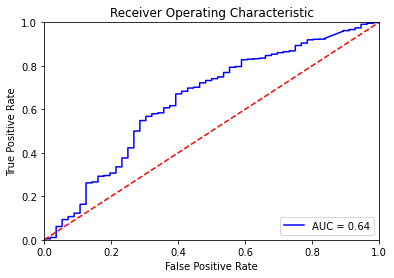

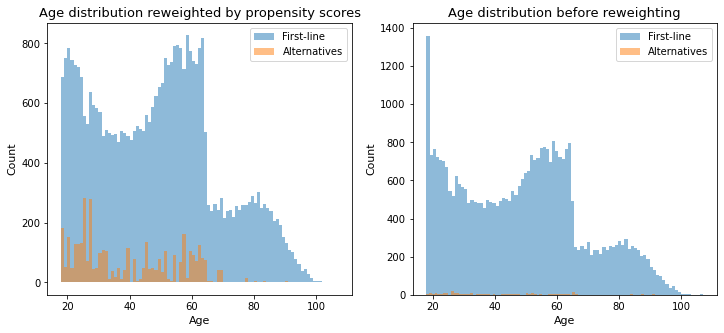

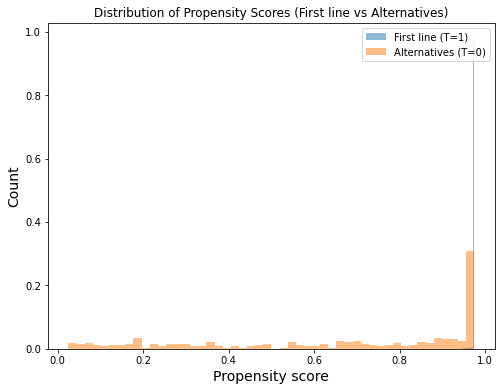

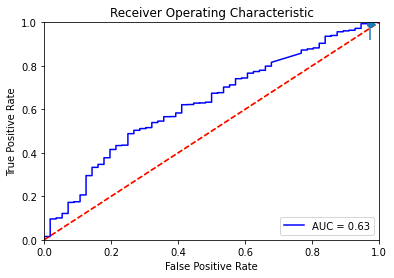

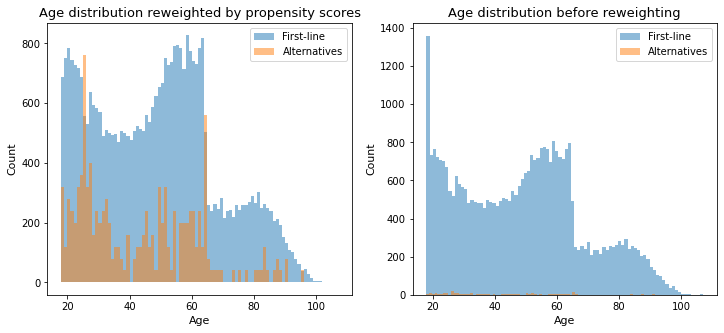

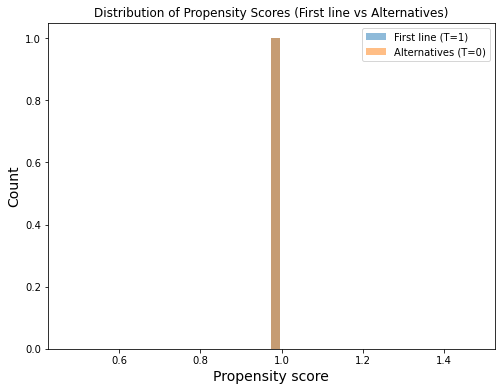

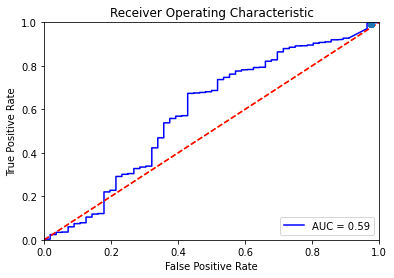

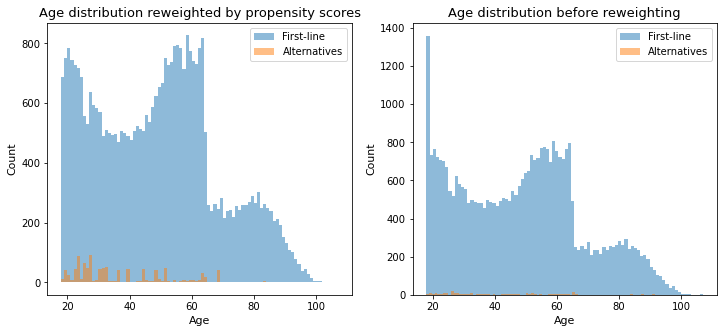

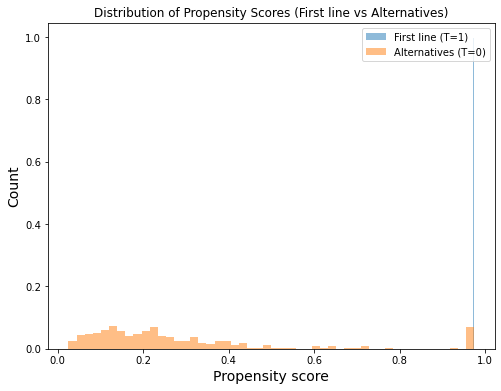

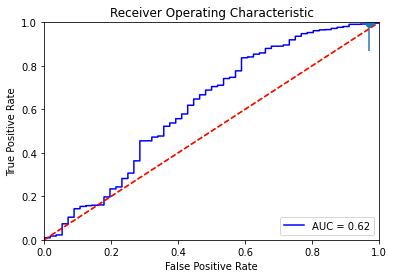

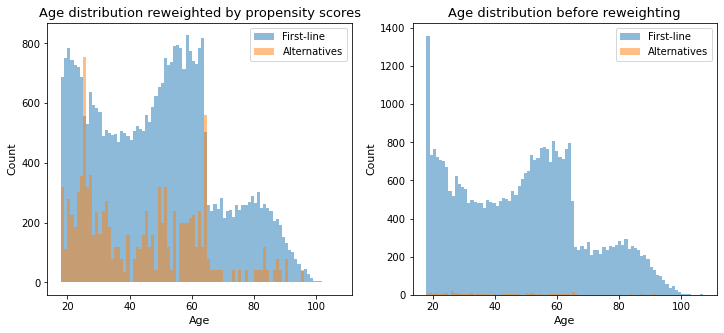

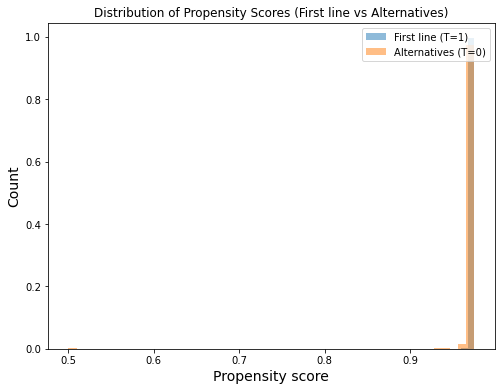

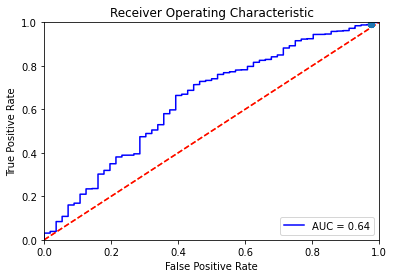

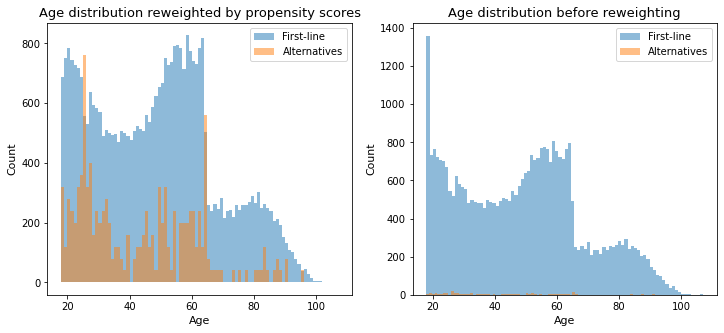

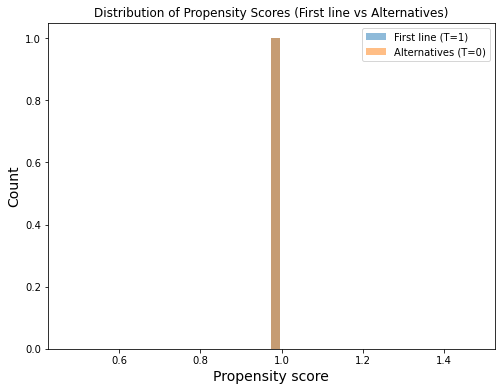

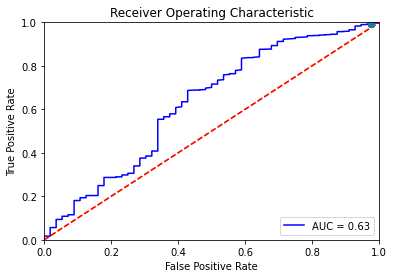

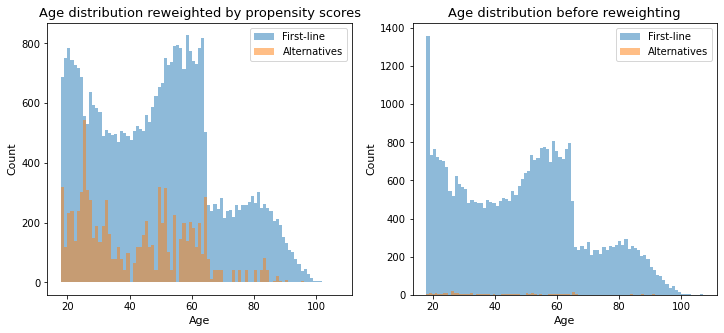

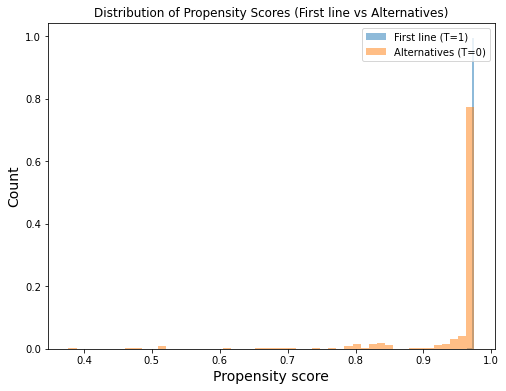

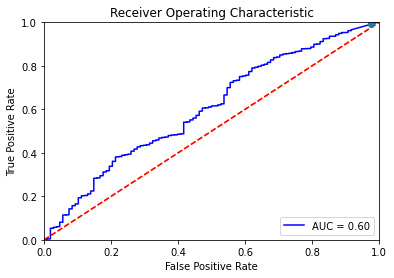

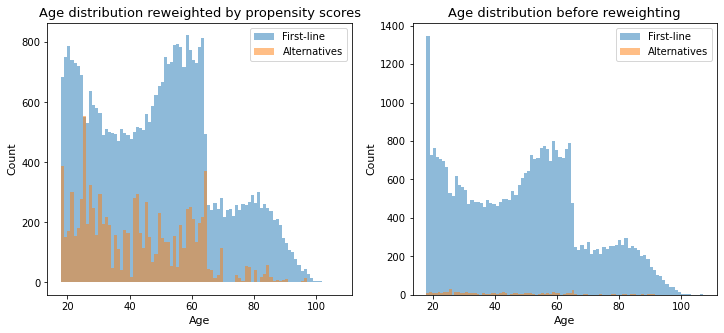

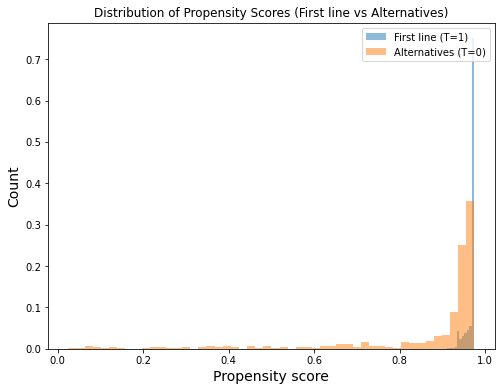

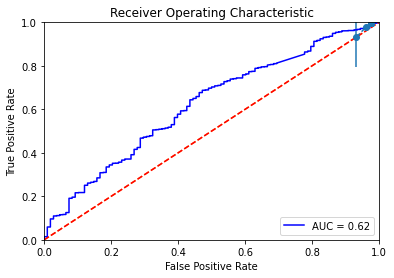

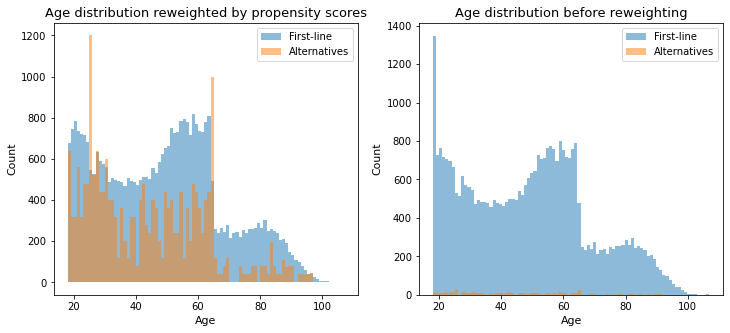

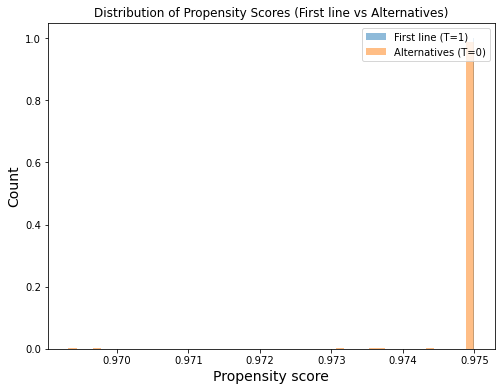

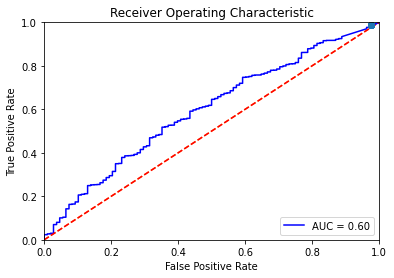

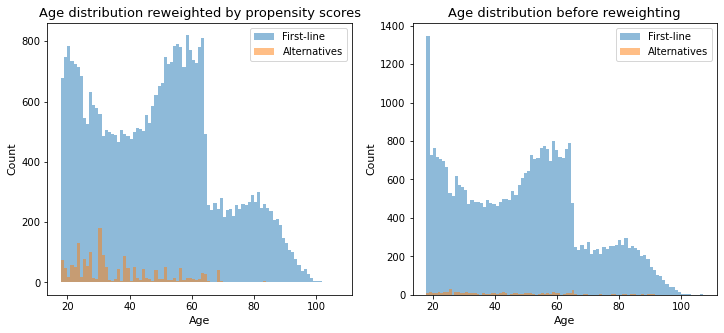

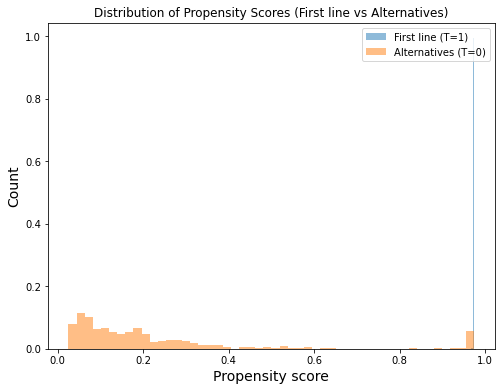

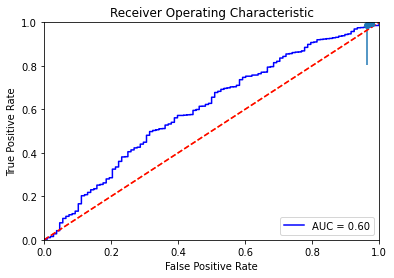

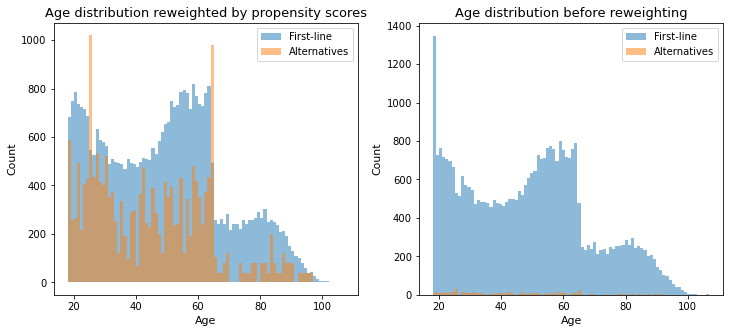

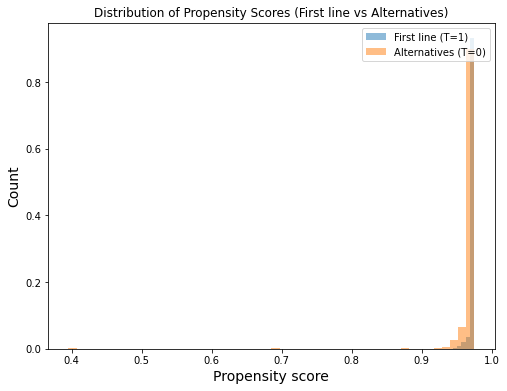

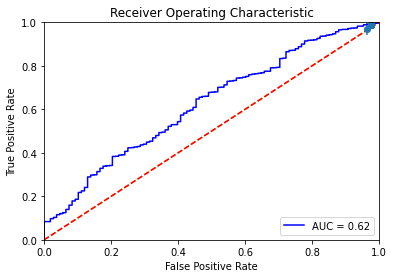

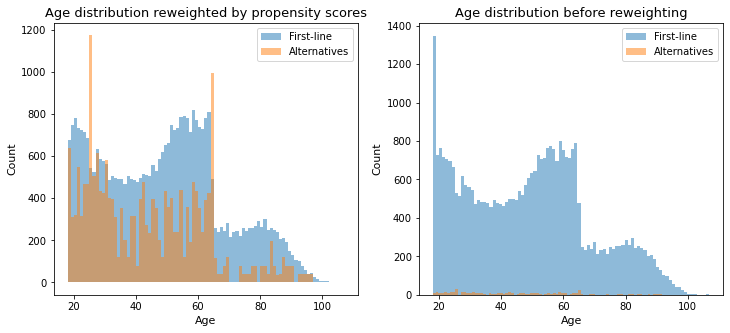

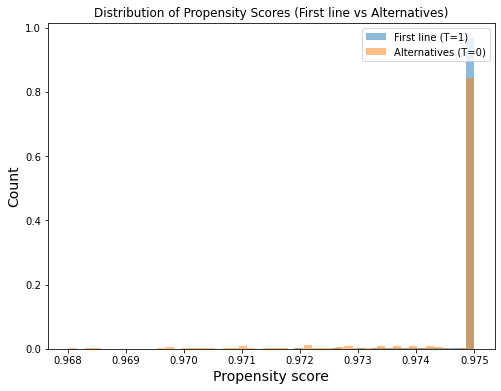

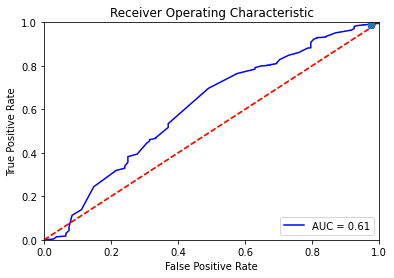

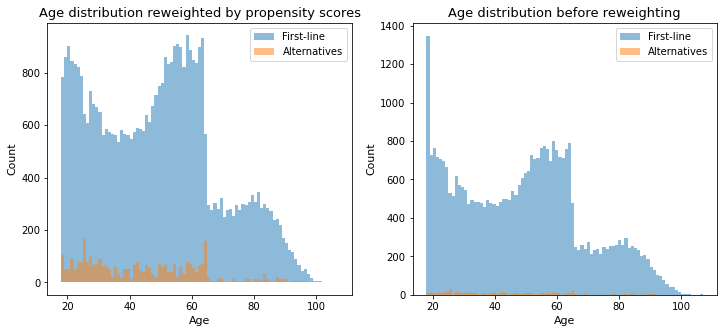

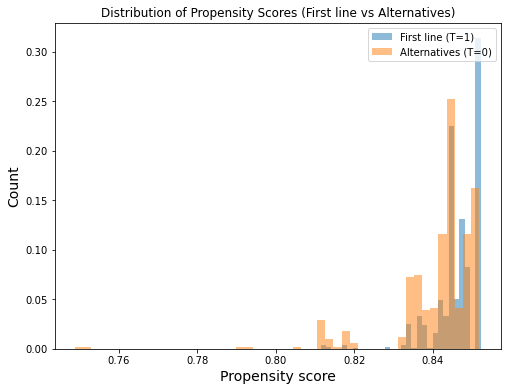

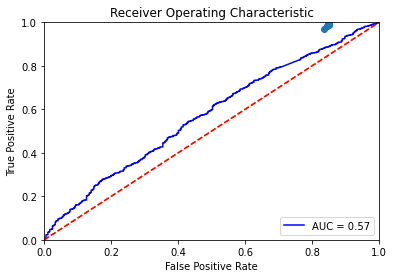

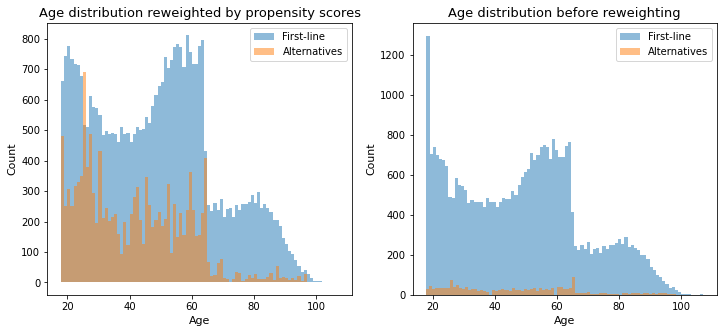

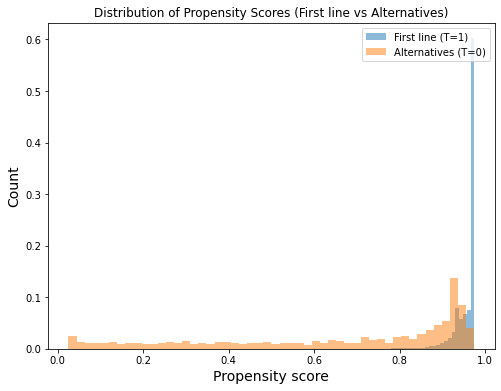

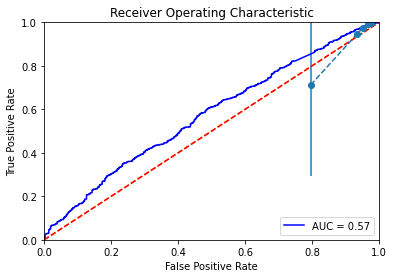

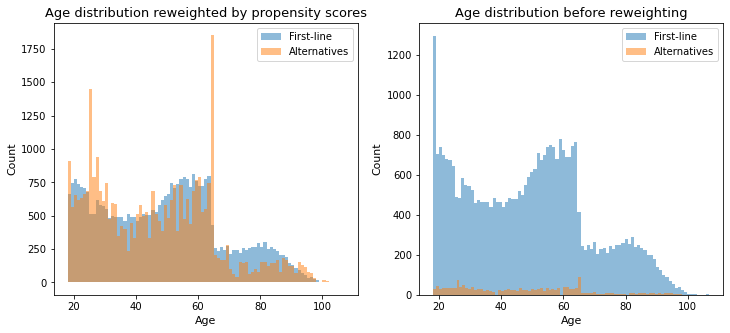

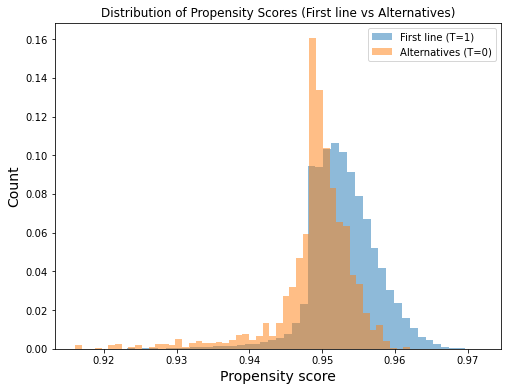

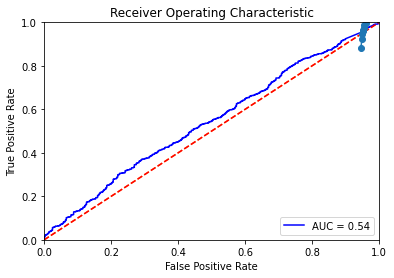

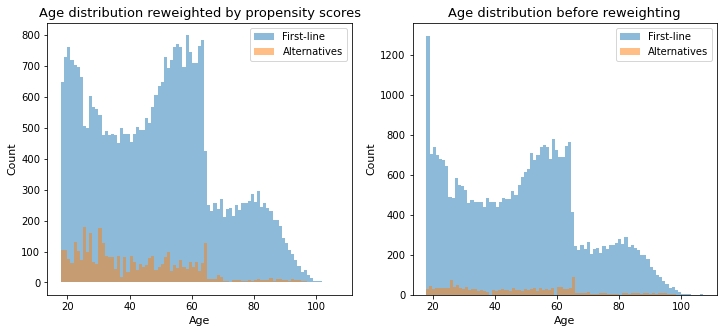

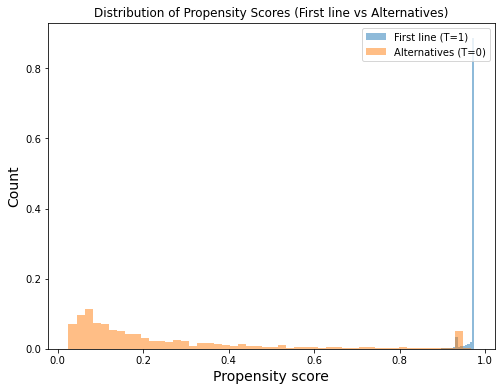

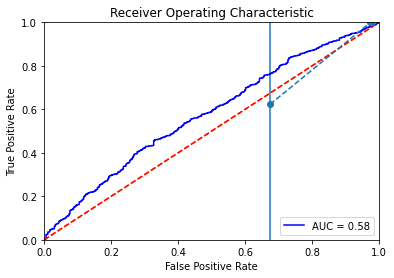

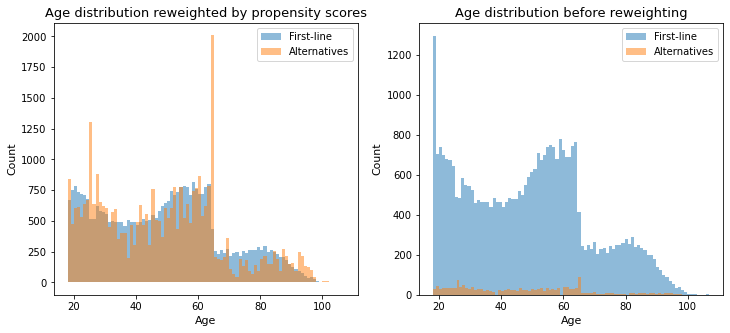

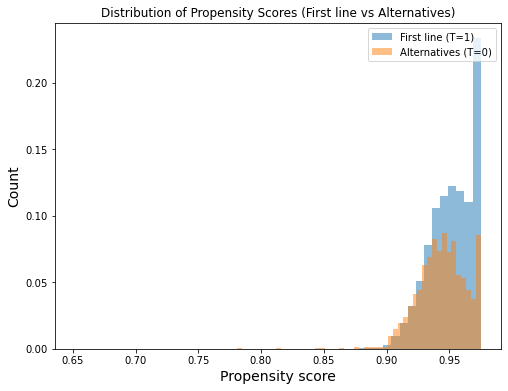

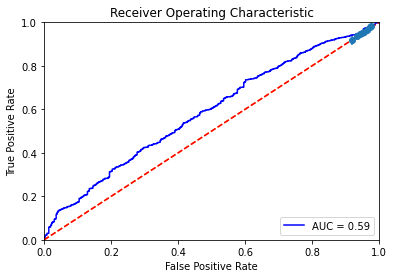

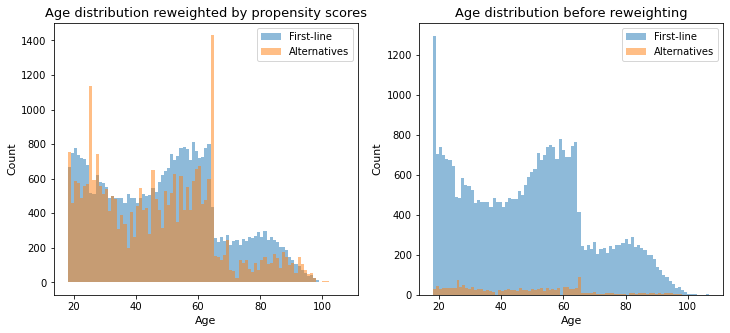

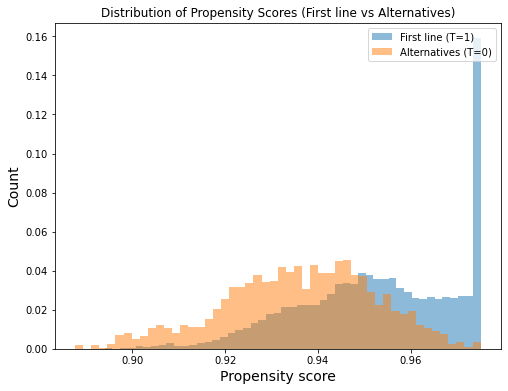

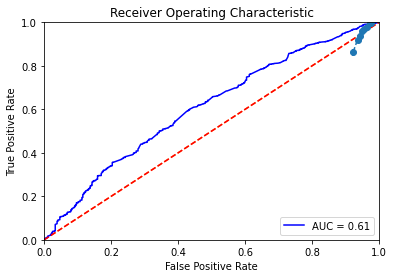

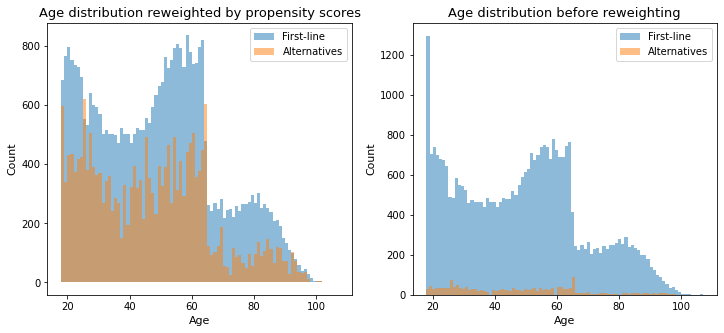

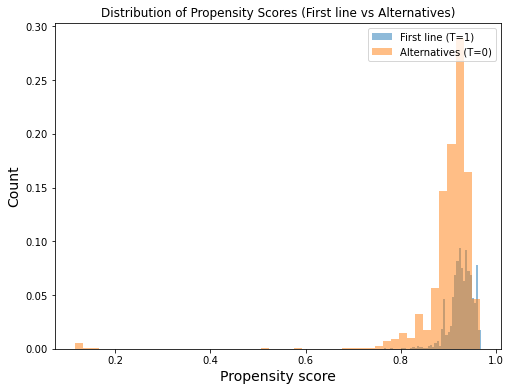

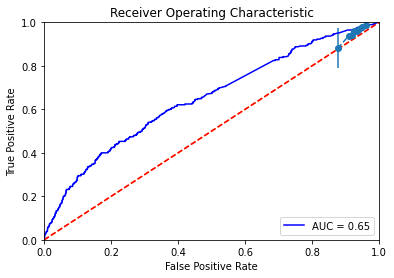

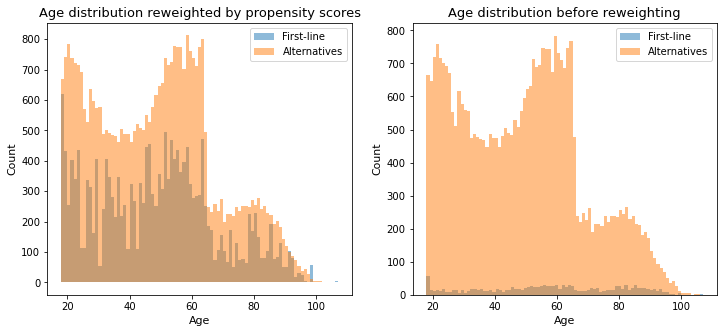

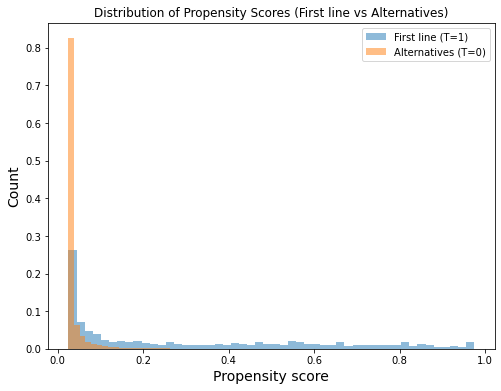

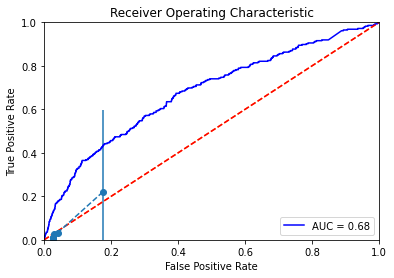

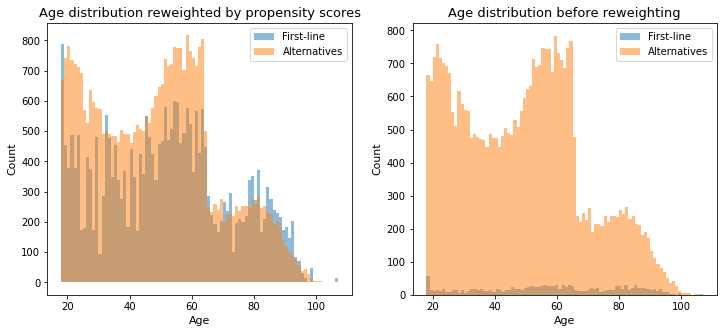

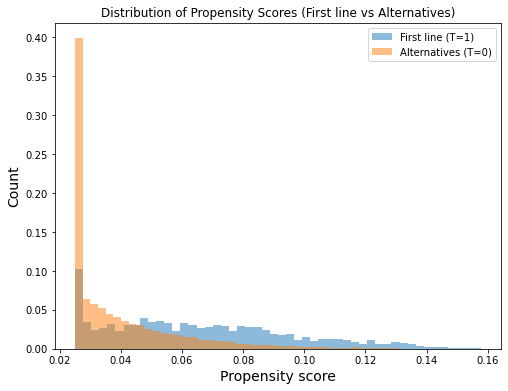

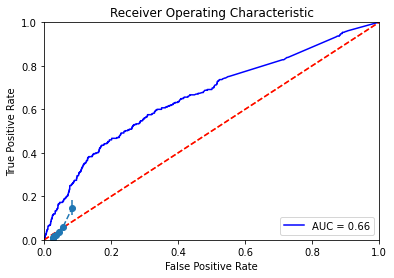

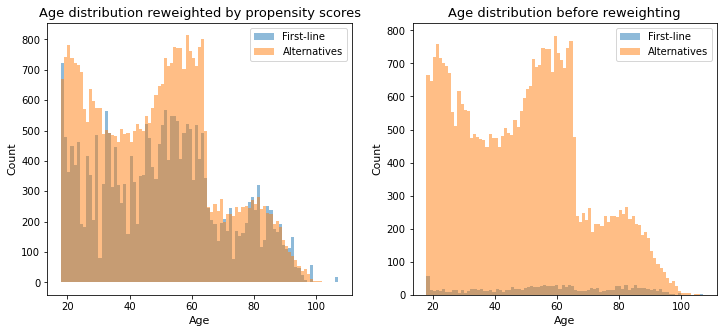

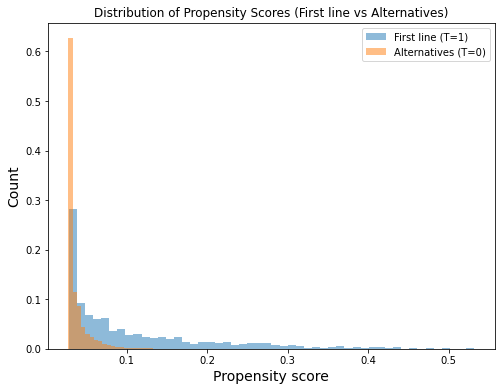

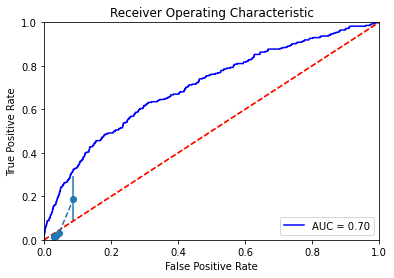

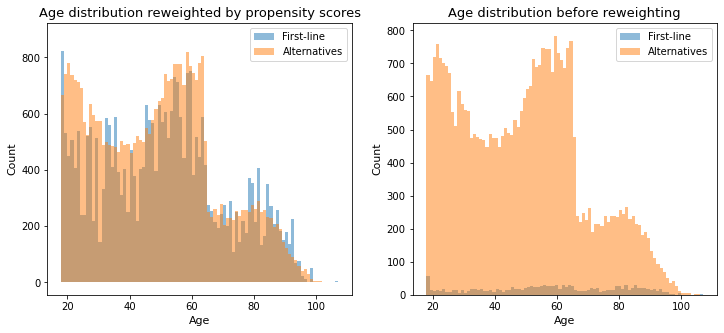

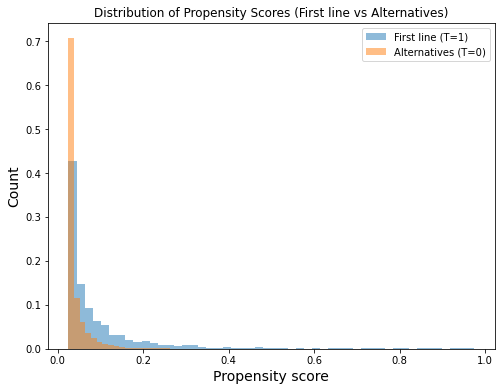

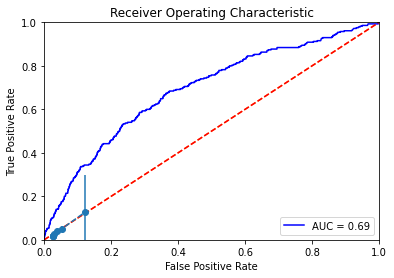

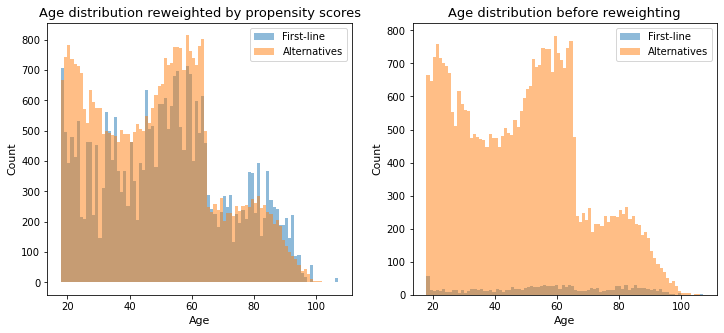

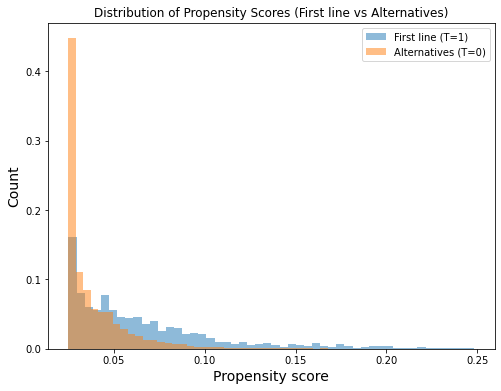

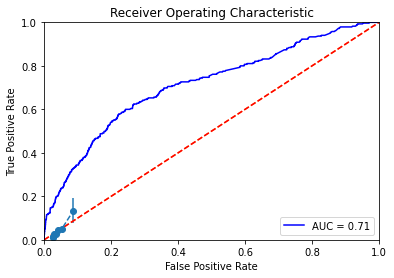

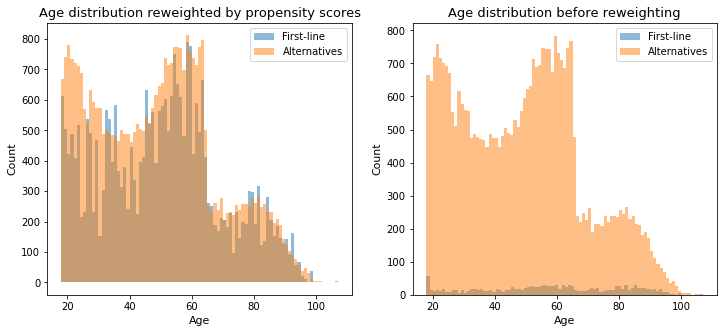

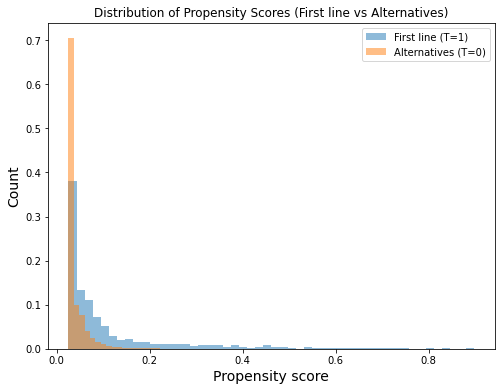

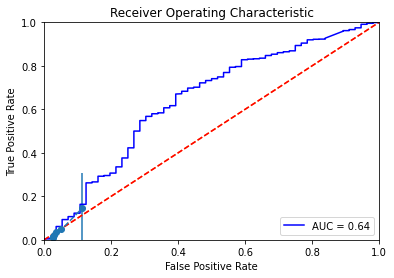

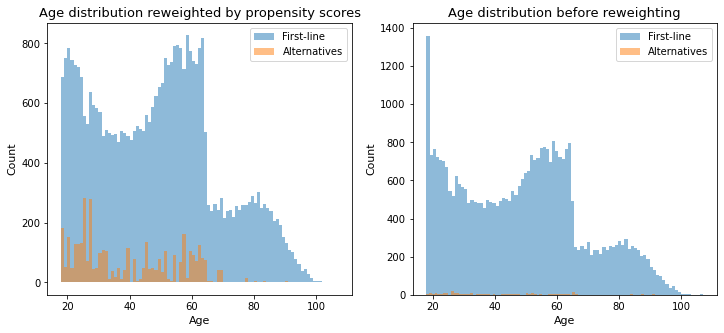

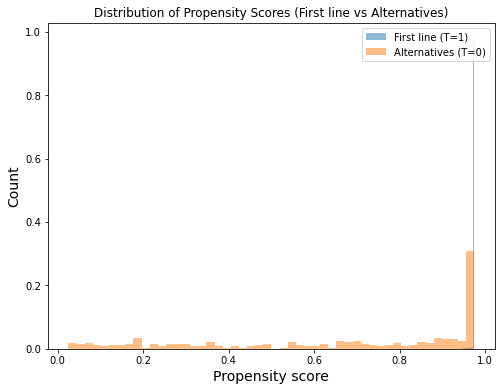

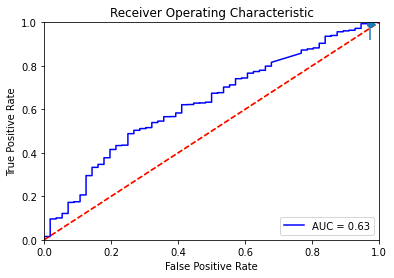

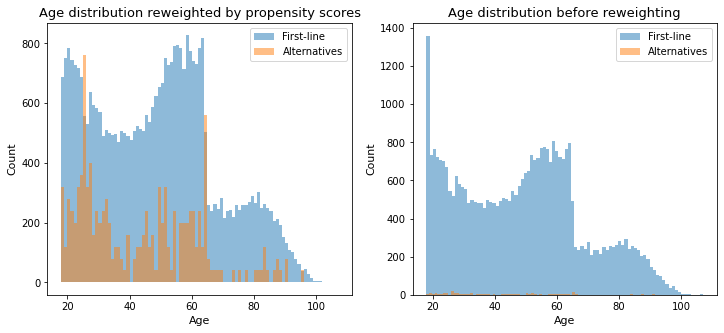

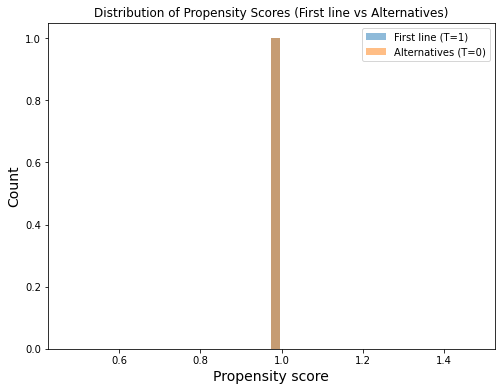

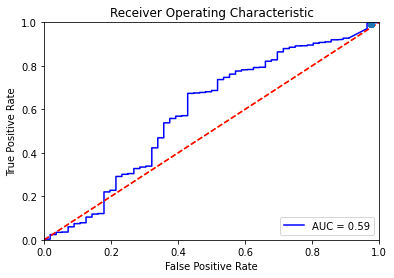

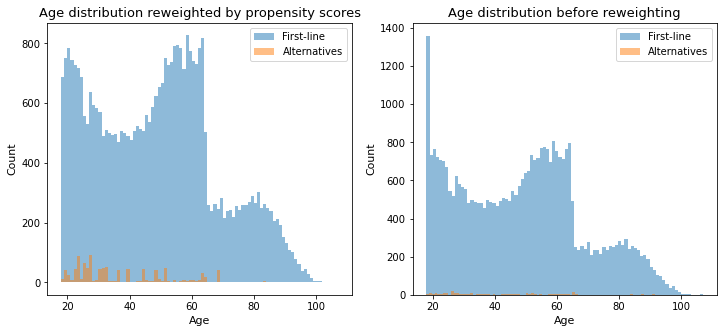

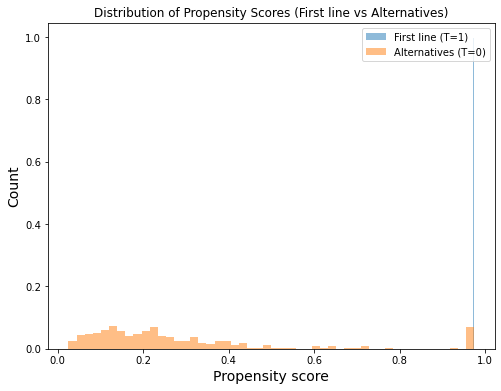

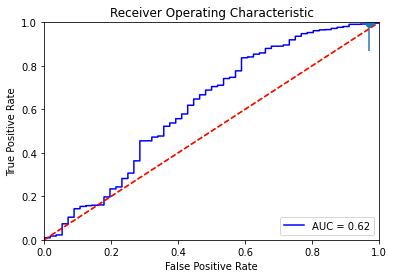

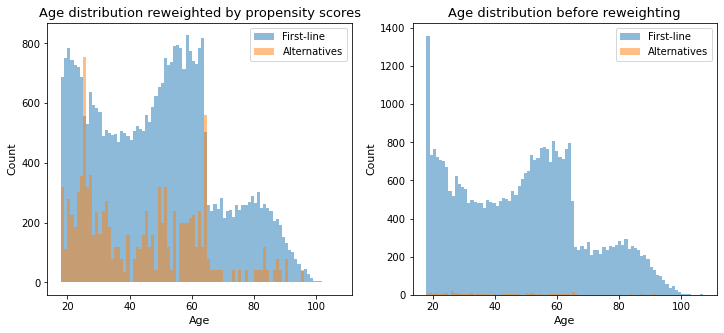

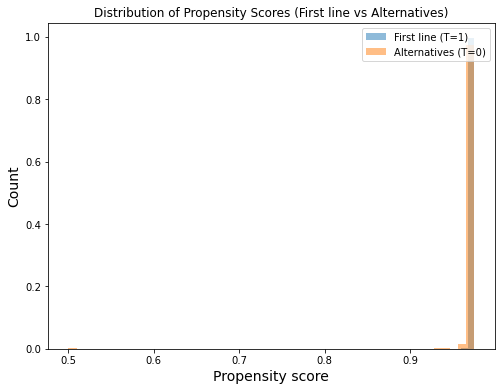

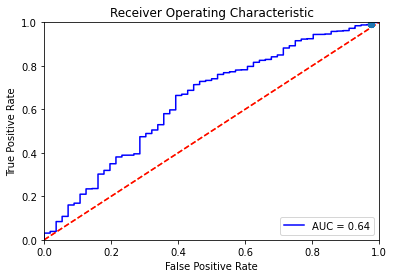

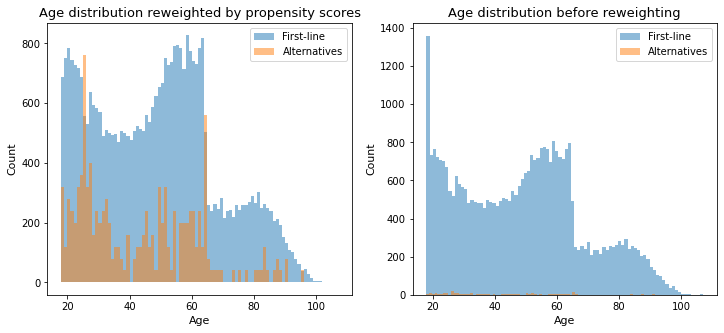

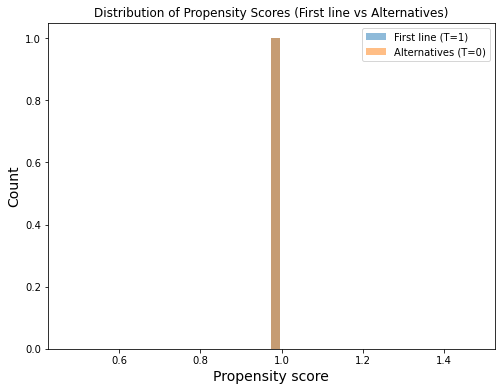

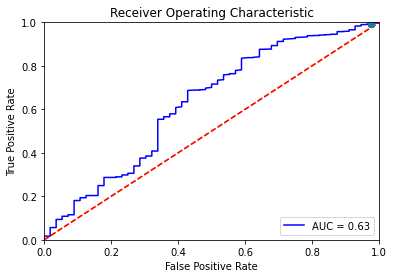

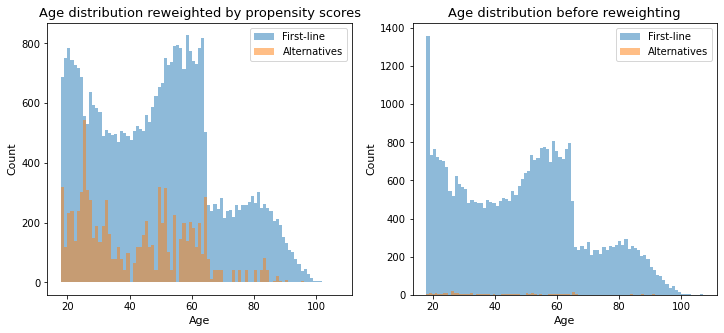

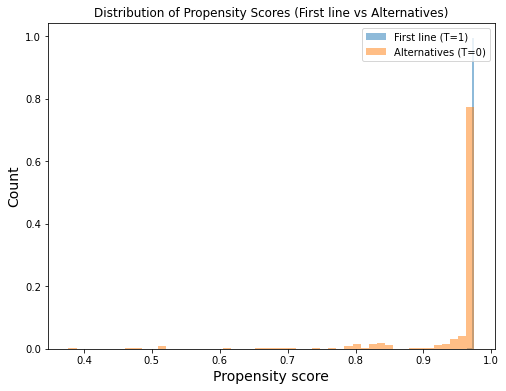

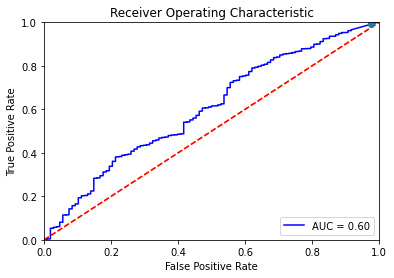

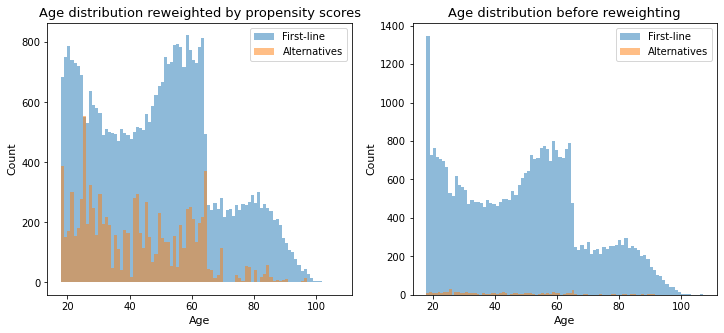

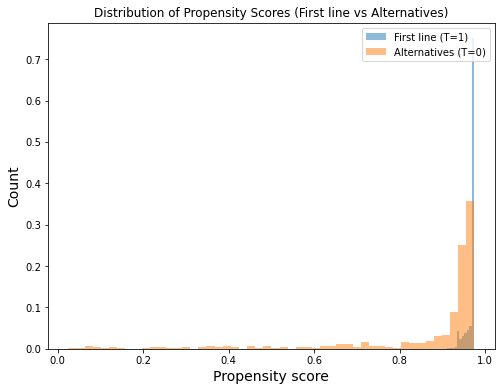

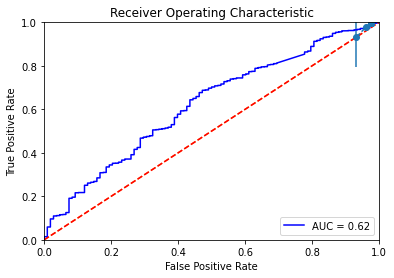

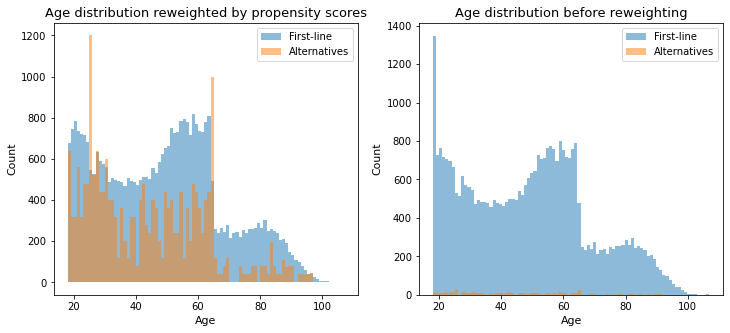

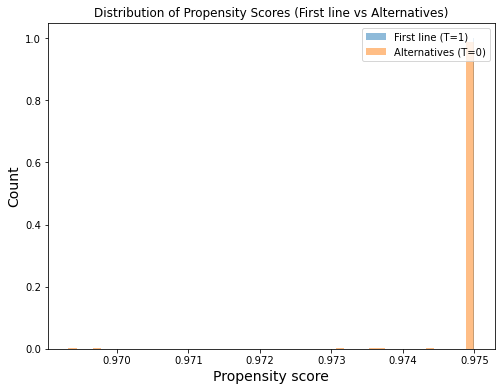

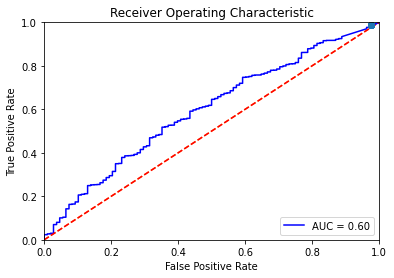

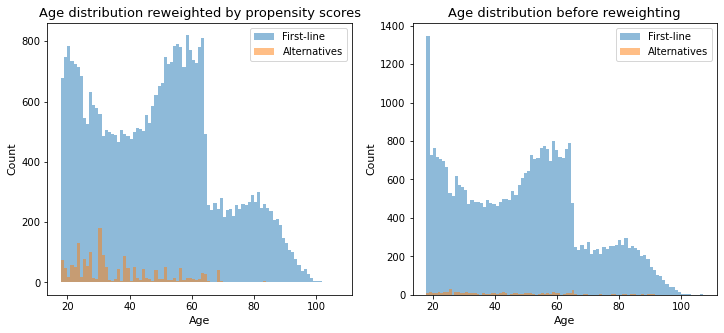

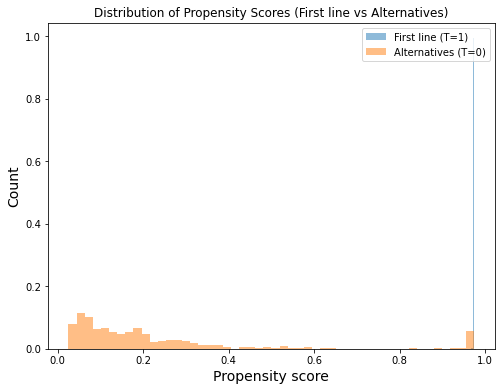

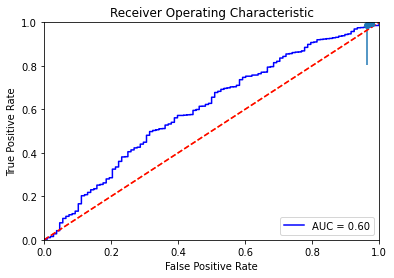

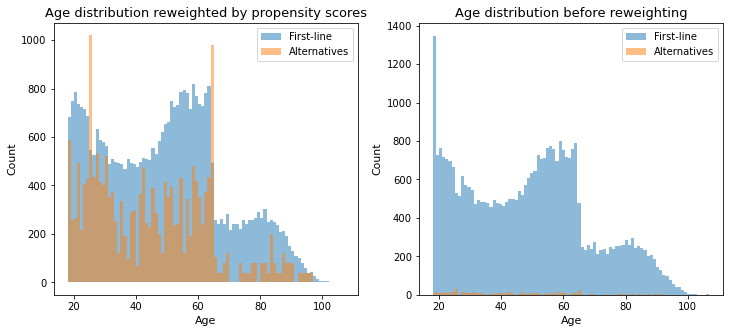

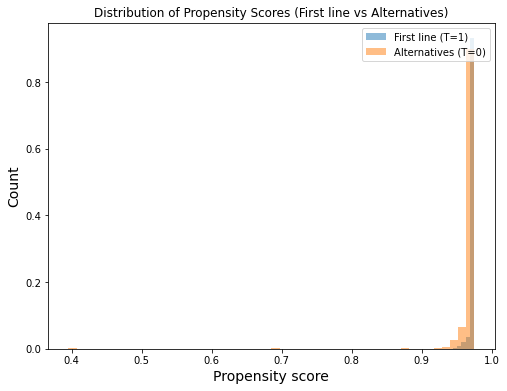

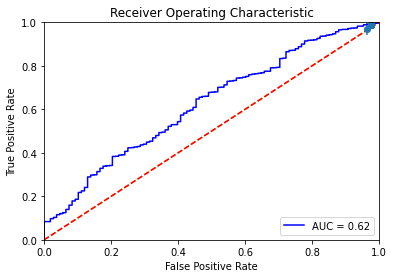

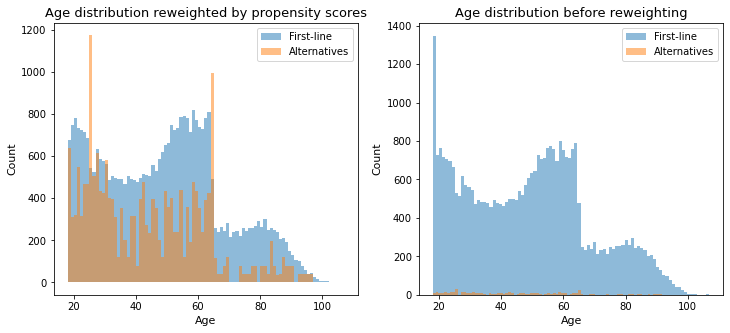

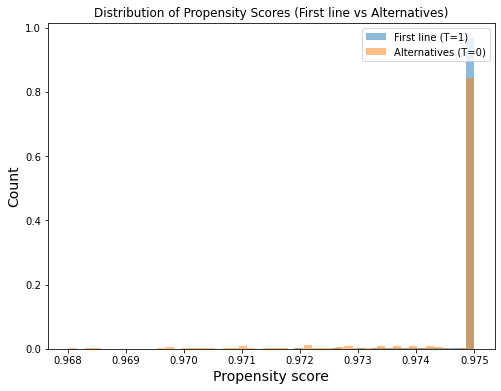

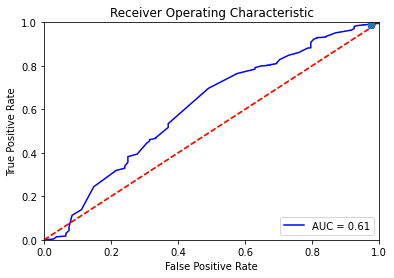

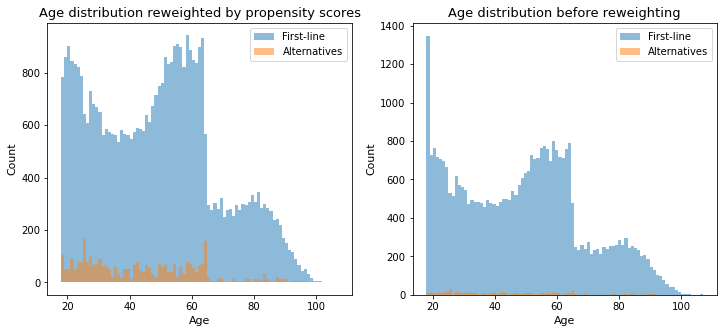

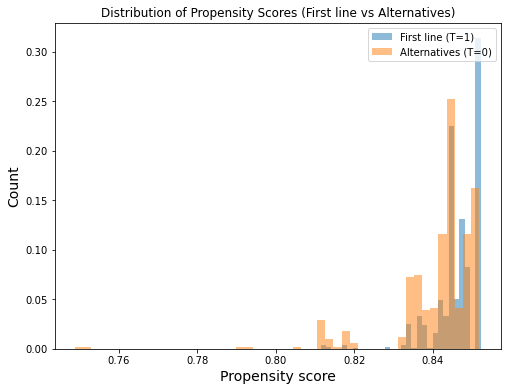

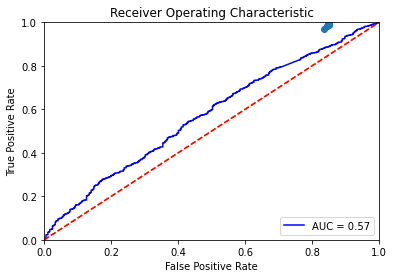

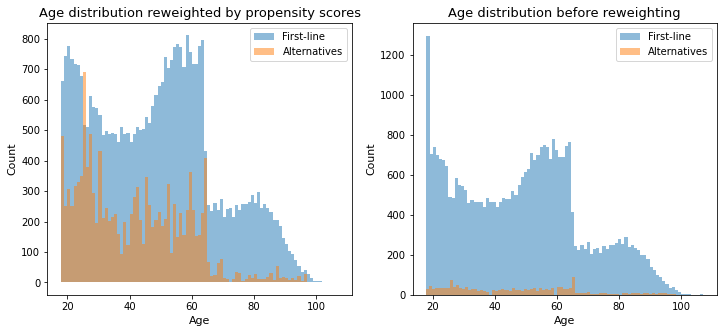

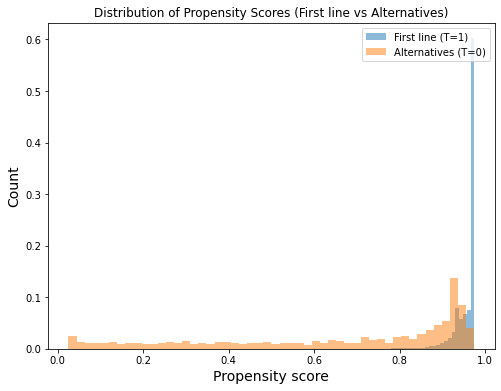

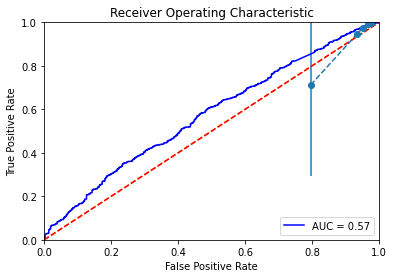

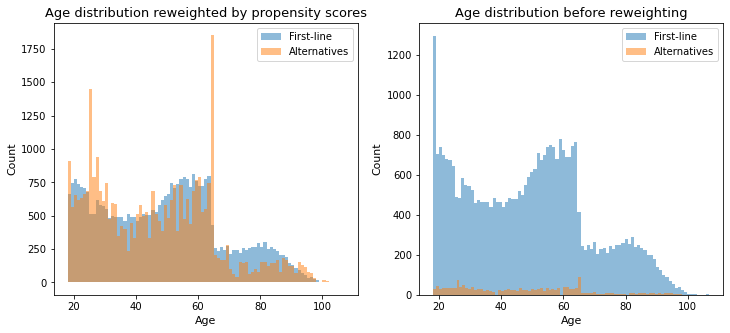

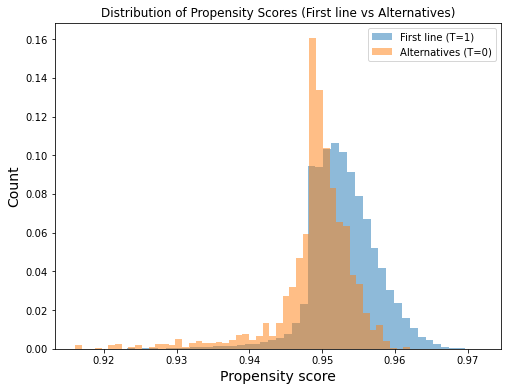

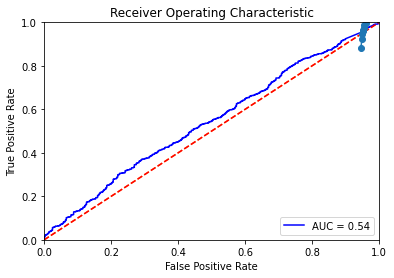

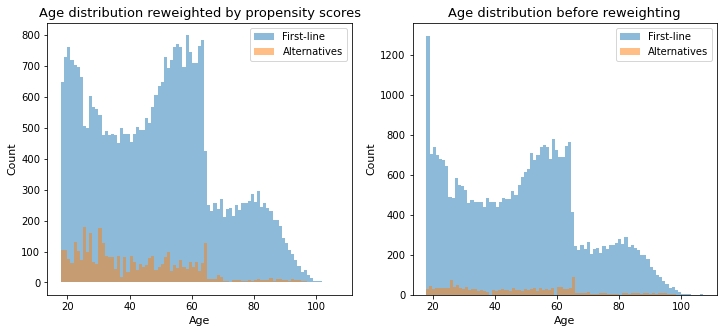

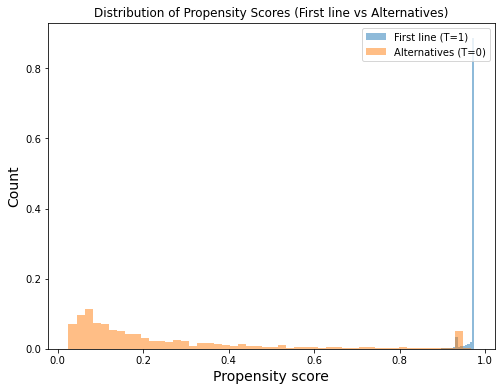

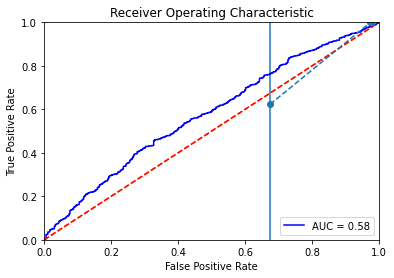

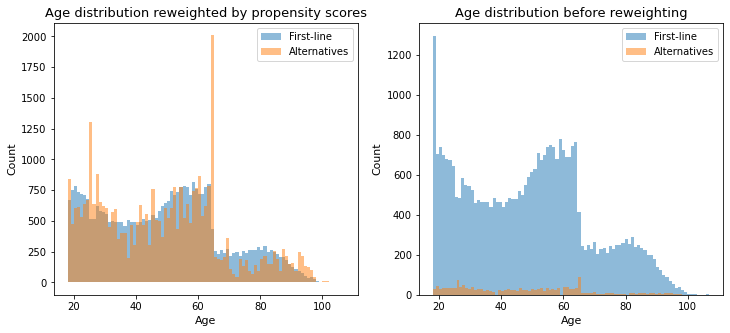

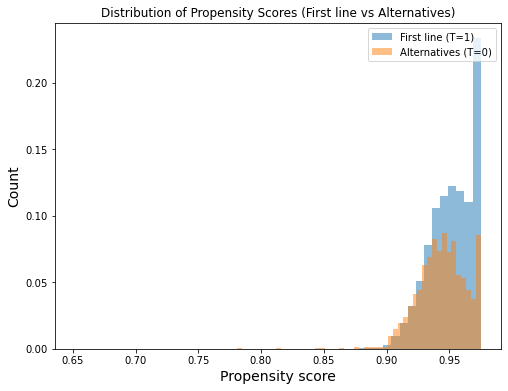

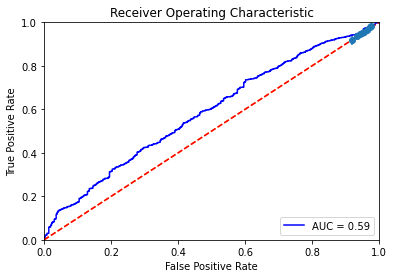

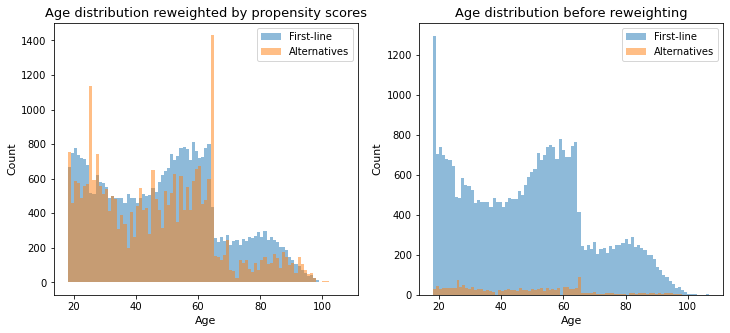

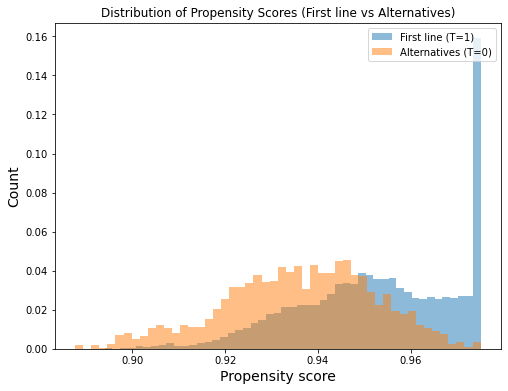

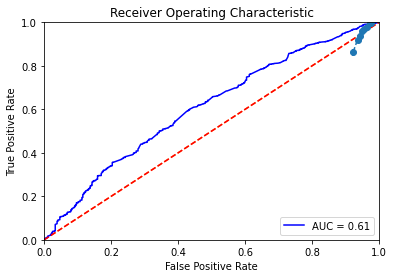

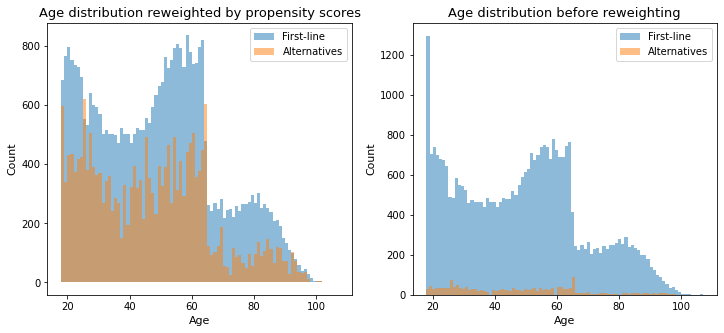

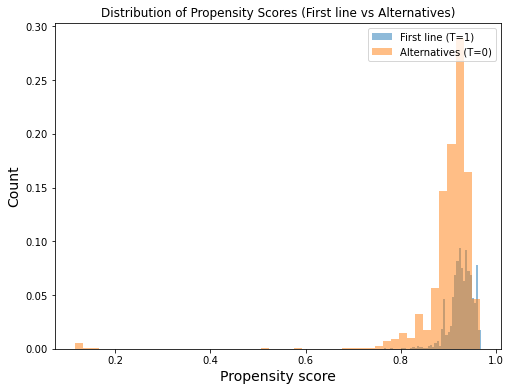

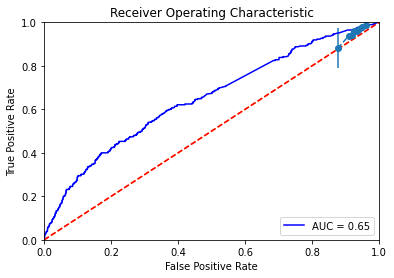

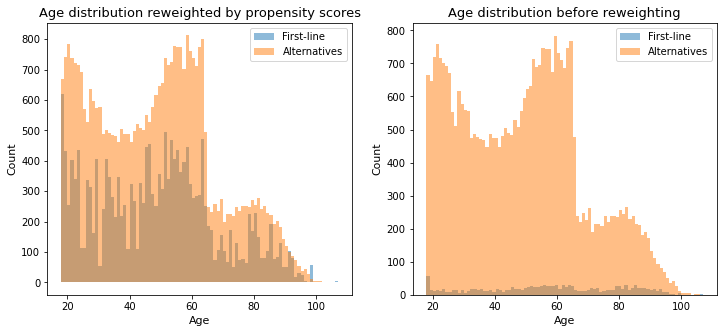

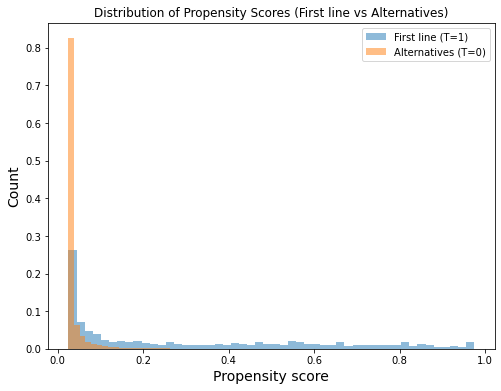

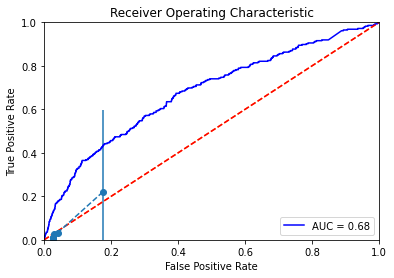

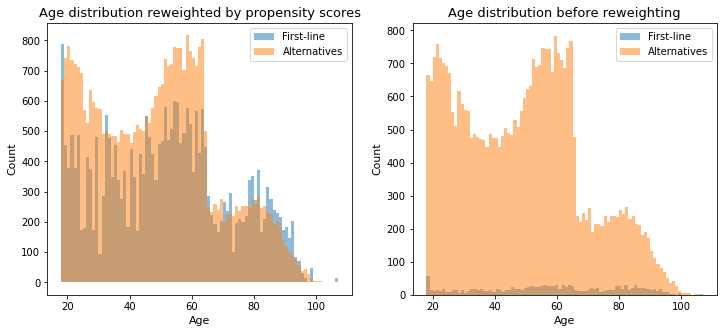

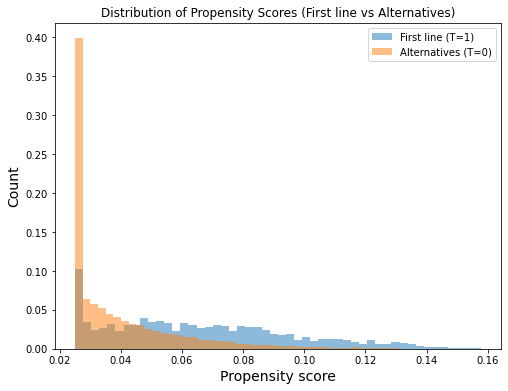

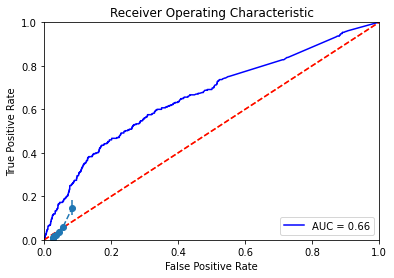

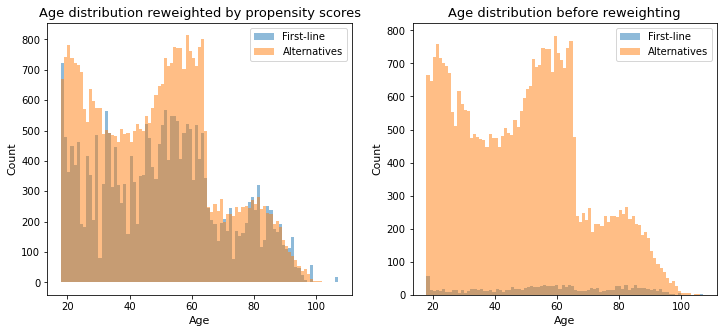

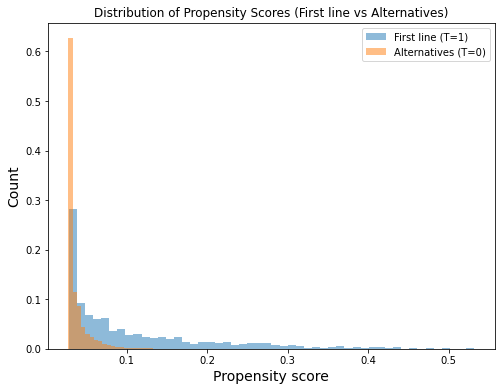

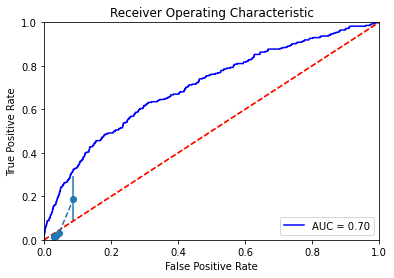

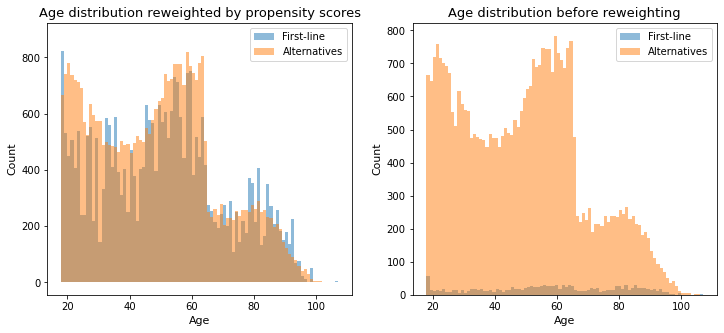

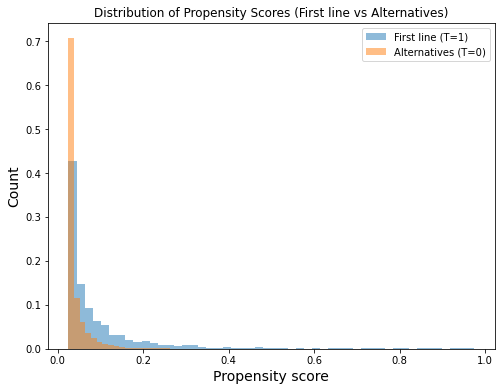

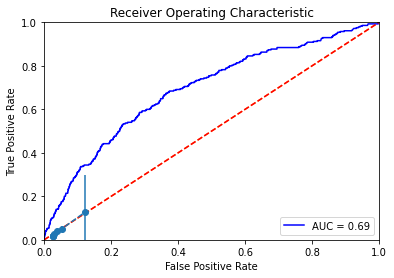

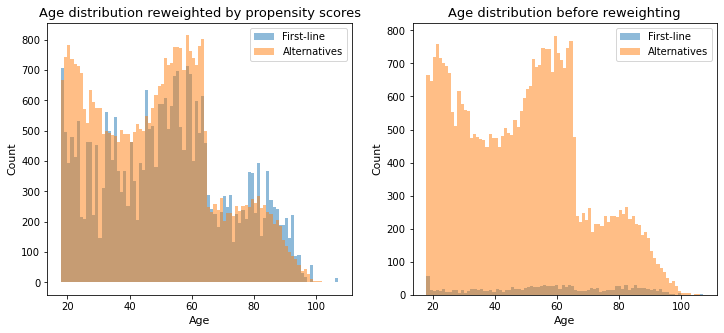

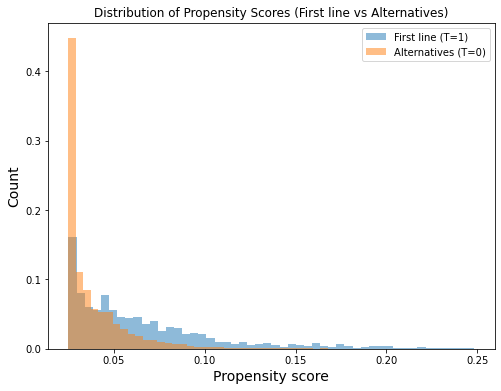

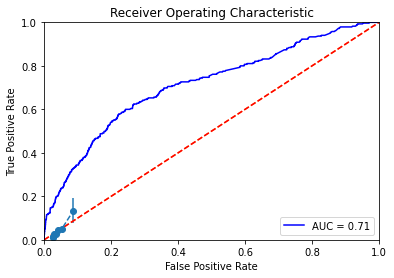

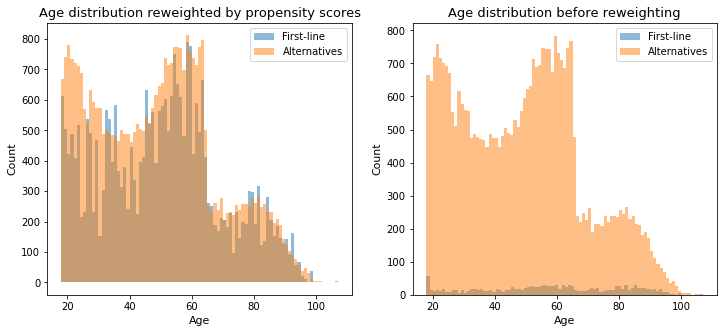

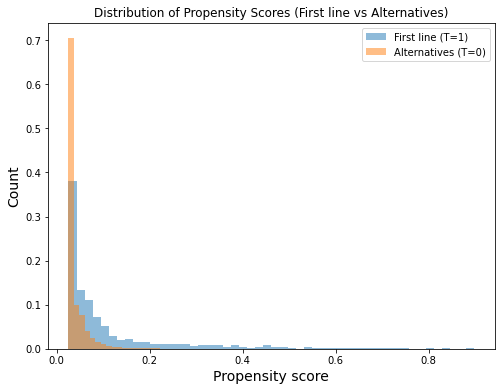

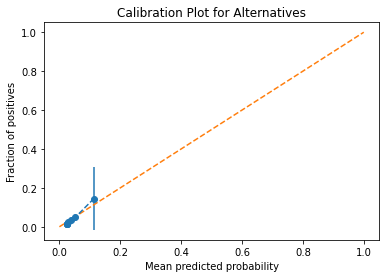

In [64]:
new_log_name = f"logs_{in_name}_03042024_v2"
for outcome in outcomes:
    for model_feature_config in all_models:
        generate_plots(model_config=model_feature_config,outcome=outcome,show_results=True,log_name=new_log_name)

In [70]:
for model in all_models:
    print(model.keys())

dict_keys(['name', 'outcome', 'score', 'feature', 'model_num', 'metrics', 'params', 'clf', 'cohort'])
dict_keys(['name', 'outcome', 'score', 'feature', 'model_num', 'metrics', 'params', 'clf', 'cohort'])
dict_keys(['name', 'outcome', 'score', 'feature', 'model_num', 'metrics', 'params', 'clf', 'cohort'])
dict_keys(['name', 'outcome', 'score', 'feature', 'model_num', 'metrics', 'params', 'clf', 'cohort'])
dict_keys(['name', 'outcome', 'score', 'feature', 'model_num', 'metrics', 'params', 'clf', 'cohort'])
dict_keys(['name', 'outcome', 'score', 'feature', 'model_num', 'metrics', 'params', 'clf', 'cohort'])
dict_keys(['name', 'outcome', 'score', 'feature', 'model_num', 'metrics', 'params', 'clf', 'cohort'])
dict_keys(['name', 'outcome', 'score', 'feature', 'model_num', 'metrics', 'params', 'clf', 'cohort'])
dict_keys(['name', 'outcome', 'score', 'feature', 'model_num', 'metrics', 'params', 'clf', 'cohort'])
dict_keys(['name', 'outcome', 'score', 'feature', 'model_num', 'metrics', 'params'

In [80]:
for i,model in enumerate(all_models):
    print(i+1,model['feature'],model['outcome'],model['name'],f"{model['score']:.3}",f"{model['metrics'][1]:.3}")

print("\n")
for i,model in enumerate(all_models):

    print(i+1,model['params'])

1 omop_1_year_features 15 Logistic_Regression 0.587 0.644
2 omop_1_year_features 15 Random_Forest 0.578 0.63
3 omop_1_year_features 15 LGBM 0.579 0.589
4 cohort_features 15 Logistic_Regression 0.66 0.616
5 cohort_features 15 Random_Forest 0.662 0.641
6 cohort_features 15 LGBM 0.652 0.629
7 omop_1_year_features 30 Logistic_Regression 0.557 0.602
8 omop_1_year_features 30 Random_Forest 0.556 0.621
9 omop_1_year_features 30 LGBM 0.556 0.596
10 cohort_features 30 Logistic_Regression 0.631 0.603
11 cohort_features 30 Random_Forest 0.63 0.623
12 cohort_features 30 LGBM 0.627 0.609
13 omop_1_year_features 90 Logistic_Regression 0.554 0.574
14 omop_1_year_features 90 Random_Forest 0.568 0.575
15 omop_1_year_features 90 LGBM 0.552 0.543
16 cohort_features 90 Logistic_Regression 0.62 0.578
17 cohort_features 90 Random_Forest 0.636 0.588
18 cohort_features 90 LGBM 0.648 0.608
19 omop_1_year_features alternatives Logistic_Regression 0.664 0.65
20 omop_1_year_features alternatives Random_Forest 0.6

In [43]:
%%time
#choose the parameter model combo

#change grid_params if grid searching over treatment outcome instead of censor outcome

all_best_hyperparams = {}
grid_params ={'censor' : {'outcome_names':['15','30','90'],'feats':feat_dict['censor']},
              'treatment' : {'outcome_names':[treatment_name],'feats': feat_dict['treatment']}}

best_models = []
all_models = []
#NOAH ADDED NEW GRID SEARCH FUNCTIONALITY FOR OUTCOME
outcomes = ['censor','treatment']
for outcome in outcomes:

    grid_features= list(grid_params[outcome]['feats'].keys())
    grid_outcomes = [(k,v) for k,v in outcome_dict[outcome].items() if k in grid_params[outcome]['outcome_names']]


    feat_imp = ["Coefficient","Gini importance","Number of splits"]
    model_list = ["Logistic_Regression","Random_Forest","LGBM"]


    for out_name, out_val in grid_outcomes:
        y = out_val
        for f in grid_features:
            best_score = -float("inf")
            for m in range(1,4):
                #add outcome_name to model feature dictionary
                cohort, clf, params, score, metric = build_model(f,outcome,y,m,cv=True,folds=3)
                model_feature = {"name":f"{model_list[m-1]}","outcome":out_name, "score":score,"feature":f,"model_num":m,"metrics":metric,"params":params,"clf":clf,"cohort":cohort}
                all_models.append(model_feature)
                if score > best_score:
                    best_score = score
                    best_model_num = m
                    best_params = params
                    best_metric = metric
                    best_clf = clf
                    best_cohort = cohort

            print(f"{f} with {out_name} {outcome} outcome models DONE.")
            print("BEST MODEL WAS ", f"{model_list[best_model_num-1]} with ROC_AUC score: {best_score}")
            print(f"Best params are: {best_params}")
            best_model_feature = {"name":f"{model_list[best_model_num-1]}","score":best_score,"feature":f,"model_num":best_model_num,"metrics":best_metric,"params":best_params,"clf":best_clf,"cohort":best_cohort}
            best_models.append(best_model_feature)
            
            #loading the best params into dictionary
            best_params['clf'] = model_list[best_model_num-1]
            all_best_hyperparams.setdefault(f, {}).setdefault(treatment_name, {})[out_name] = best_params



omop_1_year_features with 15 censor outcome models DONE.
BEST MODEL WAS  Logistic_Regression with ROC_AUC score: 0.5874530737800935
Best params are: {'C': 0.1, 'penalty': 'l2'}
cohort_features with 15 censor outcome models DONE.
BEST MODEL WAS  Random_Forest with ROC_AUC score: 0.662126925889097
Best params are: {'max_features': 'auto', 'min_samples_leaf': 75, 'n_estimators': 80}
omop_1_year_features with 30 censor outcome models DONE.
BEST MODEL WAS  Logistic_Regression with ROC_AUC score: 0.5568432486055764
Best params are: {'C': 0.01, 'penalty': 'l2'}
cohort_features with 30 censor outcome models DONE.
BEST MODEL WAS  Logistic_Regression with ROC_AUC score: 0.6305469841787317
Best params are: {'C': 0.1, 'penalty': 'l2'}


KeyboardInterrupt: 

In [52]:
import pickle
pickle.dump(all_best_hyperparams,open(f'best_{treatment_name}_03042024_hyperparameters.pkl','wb'))

In [ ]:
## first we convert the clfs

## then we separate the dictionaries into the variables of interest using a dict comprehension
# first these: best_alternatives_cohort, best_second_line_cohort, best_second_line_omop, best_alternatives_omop
# then create these: best_D_params_cohort, best_A_params_cohort, best_D_params_omop, best_A_params_omop


In [211]:
(model_feature_config['cohort']['treatment'] == 0).value_counts()

True     35018
False     1427
Name: treatment, dtype: int64

In [53]:
new_log_name = f"logs_{in_name}_03042024"
for outcome in outcomes:
    for model_feature_config in all_models:
        generate_plots(model_config=model_feature_config,outcome=outcome,show_results=False,log_name=new_log_name)

## ATE Code

## Run analysis

In [27]:
#ATE helper functions
from joblib import Parallel, delayed

# define function that computes the IPTW estimator
def run_ps(df, y, features=None, params=None):
#     estimate the propensity score

    X = scipy.sparse.csr_matrix(df[features])
    T = df['treatment']
    X = MaxAbsScaler().fit_transform(X) #change to maxabs scaling
    ps = LogisticRegression(C=0.1, penalty='l1', solver='liblinear',tol=1e-4, max_iter=75).fit(X, T).predict_proba(X)[:, 1]

    weight = (T-ps) / (ps*(1-ps)) # define the weights
    y_ = df[y]
    z = df['treatment']
    
    df["ips"] = np.where(df['treatment'] == 1, 1 / ps, 1 / (1 - ps))
    df['ipsw'] = df[y]*df['ips']
    
    ey1 = z*y_/ps / sum(z/ps)
    ey0 = (1-z)*y_/(1-ps) / sum((1-z)/(1-ps))
    ate = ey1.sum()-ey0.sum()
    return [ate, ey0.sum(), ey1.sum()] # compute the ATE


def bootstrap(test, bootstrap_sample = 1, other_word = '', features=None, params=None):

    out = Parallel(n_jobs=15)(delayed(run_ps)(test.sample(frac=1, replace=True), y, features=features, params=params)
                              for _ in range(bootstrap_sample))

    #ates = np.array(ates)
    ates = np.array(out)[:,0]
    y0s = np.array(out)[:,1]
    y1s = np.array(out)[:,2]
    
    EY1 = np.round(y1s.mean(),4); EY0 = np.round(y0s.mean(),4)
    ATE = np.round(ates.mean(),4)
    CI95 = (np.round(np.percentile(ates, 2.5),4), np.round(np.percentile(ates, 97.5),4))
    
    # print "Showing results for", y, other_word
    print("ATE for", other_word, ":", ATE)
    print("95% C.I.: (", CI95[0], ", ", CI95[1], ")")
    print("EY1:", EY1)
    print("EY0:", EY0)
    return [EY1, EY0, ATE, CI95]

def run_ps2(data, params, verbose=True):
    X, T, y_ = data
    if verbose == True:
        print(f"Feature shape {X.shape}, Treatment shape {T.shape}, Outcome shape {y_.shape}")
        
    X = MaxAbsScaler().fit_transform(X) #change to maxabs scaling
    ps = lgb.LGBMClassifier().set_params(**params).fit(X, T).predict_proba(X)[:, 1]
    
    weight = (T-ps) / (ps*(1-ps)) # define the weights
    ey1 = T*y_/ps / sum(T/ps)
    ey0 = (1-T)*y_/(1-ps) / sum((1-T)/(1-ps))
    ate = ey1.sum()-ey0.sum()
    return [ate, ey0.sum(), ey1.sum()] # compute the ATE

    
def sparse_bootstrap(X_sparse, T, y, bootstrap_sample = 1, other_word = '', params=None):
    out = Parallel(n_jobs=15)(delayed(run_ps2)(resample(X_sparse, T, filtered_cohort[y]), params=params)
                              for _ in range(bootstrap_sample))
    #ates = np.array(ates)
    ates = np.array(out)[:,0]
    y0s = np.array(out)[:,1]
    y1s = np.array(out)[:,2]
    
    EY1 = np.round(y1s.mean(),4); EY0 = np.round(y0s.mean(),4)
    ATE = np.round(ates.mean(),4)
    CI95 = (np.round(np.percentile(ates, 2.5),4), np.round(np.percentile(ates, 97.5),4))
    
    # print "Showing results for", y, other_word
    print("ATE for", other_word, ":", ATE)
    print("95% C.I.: (", CI95[0], ", ", CI95[1], ")")
    print("EY1:", EY1)
    print("EY0:", EY0)
    return [EY1, EY0, ATE, CI95]

def censor_bootstrap(X_sparse, T, y, D, bootstrap_sample = 1, other_word = '', params:tuple=None):
    
    out = Parallel(n_jobs=15)(delayed(run_ps3)(resample(X_sparse, T, filtered_cohort[y], D), params=params)
                              for _ in range(bootstrap_sample))
    #ates = np.array(ates)
    ates = np.array(out)[:,0]
    y0s = np.array(out)[:,1]
    y1s = np.array(out)[:,2]
    
    EY1 = np.round(y1s.mean(),6); EY0 = np.round(y0s.mean(),6)
    ATE = np.round(ates.mean(),6)
    CI95 = (np.round(np.percentile(ates, 2.5),6), np.round(np.percentile(ates, 97.5),6))
    
    # print "Showing results for", y, other_word
    print("ATE for", other_word, ":", ATE)
    print("95% C.I.: (", CI95[0], ", ", CI95[1], ")")
    print("EY1:", EY1)
    print("EY0:", EY0)
    return [EY1, EY0, ATE, CI95]

def run_ps3(data, params, verbose=False, prop = False):
    #computes the IPTW estimator taking into account censoring
    params_copy = copy.deepcopy(params)
    A_params, D_params = params_copy
    clf_A = A_params.pop('clf', None)
    clf_D = D_params.pop('clf', None)

    #check to make sure a classifier was provided
    assert not isinstance(clf_A,type(None)), "no treatment classifier provided"
    assert not isinstance(clf_D,type(None)), "no censor classifier provided"
    

    # D = 1 if followed for at least 30 days and 0 if less than 30 days
    # A = 1 if given second line and 0 if given first line
    # X are the covariates
    # Y is the outcome (which is treated as missing when D = 0)
    # (1) fit propensity model P(A=1| X)
    # (2) fit model for non-missing P(D=1 | X, A)
    # The estimated ATE for this bootstrap sample is then, averaging over all patients with D=1
    # E[ A_i Y_i / [P(A=1 | X_i) P(D=1 | A, X_i)] - (1-A_i) Y_i / [P(A=0 | X_i) P(D=1 | A, X_i)] ]

    X, A, Y, D = data
    if verbose == True:
        print(f"Feature shape {X.shape}, Treatment shape {A.shape}, Outcome shape {Y.shape}, D shape {D.shape}")
    

    #just the X variable
    X_1 = MaxAbsScaler().fit_transform(X) #change to maxabs scaling
    #the X and A variables

    X_2 = vstack([X_1.T, scipy.sparse.csr_matrix(A)]).T
    
    
    

    #fit propensity model
    ps = clf_A.set_params(**A_params).fit(X_1, A).predict_proba(scipy.sparse.csr_matrix(X_1))[:, 1]
    if prop:
        return(ps)
    else:
        #fit model for non-missing D
        ps_d = clf_D.set_params(**D_params).fit(X_2, D).predict_proba(scipy.sparse.csr_matrix(X_2))[:, 1]

        #filter for patients with D=1
        ps_d_filtered = ps_d[D==1]
        ps_filtered = ps[D==1]
        Y_filtered = Y[D==1]
        A_filtered = A[D==1]
        
        
        #compute e1 and e0
        ey1 = A_filtered*Y_filtered/(ps_filtered * ps_d_filtered) / sum(A_filtered/(ps_filtered * ps_d_filtered))
        ey0 = (1-A_filtered)*Y_filtered/((1-ps_filtered) * ps_d_filtered) / sum((1-A_filtered)/((1-ps_filtered) * ps_d_filtered))

        ate = ey1.sum()-ey0.sum()
        return [ate, ey0.sum(), ey1.sum()] # compute the ATE





In [31]:
#ATE helper functions
from joblib import Parallel, delayed

# define function that computes the IPTW estimator
def run_ps(df, y, features=None, params=None):
#     estimate the propensity score

    X = scipy.sparse.csr_matrix(df[features])
    T = df['treatment']
    X = MaxAbsScaler().fit_transform(X) #change to maxabs scaling
    ps = LogisticRegression(C=0.1, penalty='l1', solver='liblinear',tol=1e-4, max_iter=75).fit(X, T).predict_proba(X)[:, 1]

    weight = (T-ps) / (ps*(1-ps)) # define the weights
    y_ = df[y]
    z = df['treatment']
    
    df["ips"] = np.where(df['treatment'] == 1, 1 / ps, 1 / (1 - ps))
    df['ipsw'] = df[y]*df['ips']
    
    ey1 = z*y_/ps / sum(z/ps)
    ey0 = (1-z)*y_/(1-ps) / sum((1-z)/(1-ps))
    ate = ey1.sum()-ey0.sum()
    return [ate, ey0.sum(), ey1.sum()] # compute the ATE


def bootstrap(test, bootstrap_sample = 1, other_word = '', features=None, params=None):

    out = Parallel(n_jobs=15)(delayed(run_ps)(test.sample(frac=1, replace=True), y, features=features, params=params)
                              for _ in range(bootstrap_sample))

    #ates = np.array(ates)
    ates = np.array(out)[:,0]
    y0s = np.array(out)[:,1]
    y1s = np.array(out)[:,2]
    
    EY1 = np.round(y1s.mean(),4); EY0 = np.round(y0s.mean(),4)
    ATE = np.round(ates.mean(),4)
    CI95 = (np.round(np.percentile(ates, 2.5),4), np.round(np.percentile(ates, 97.5),4))
    
    # print "Showing results for", y, other_word
    print("ATE for", other_word, ":", ATE)
    print("95% C.I.: (", CI95[0], ", ", CI95[1], ")")
    print("EY1:", EY1)
    print("EY0:", EY0)
    return [EY1, EY0, ATE, CI95]

def run_ps2(data, params, verbose=True):
    X, T, y_ = data
    if verbose == True:
        print(f"Feature shape {X.shape}, Treatment shape {T.shape}, Outcome shape {y_.shape}")
        
    X = MaxAbsScaler().fit_transform(X) #change to maxabs scaling
    ps = lgb.LGBMClassifier().set_params(**params).fit(X, T).predict_proba(X)[:, 1]
    
    weight = (T-ps) / (ps*(1-ps)) # define the weights
    ey1 = T*y_/ps / sum(T/ps)
    ey0 = (1-T)*y_/(1-ps) / sum((1-T)/(1-ps))
    ate = ey1.sum()-ey0.sum()
    return [ate, ey0.sum(), ey1.sum()] # compute the ATE

    
def sparse_bootstrap(X_sparse, T, y, bootstrap_sample = 1, other_word = '', params=None):
    out = Parallel(n_jobs=15)(delayed(run_ps2)(resample(X_sparse, T, filtered_cohort[y]), params=params)
                              for _ in range(bootstrap_sample))
    #ates = np.array(ates)
    ates = np.array(out)[:,0]
    y0s = np.array(out)[:,1]
    y1s = np.array(out)[:,2]
    
    EY1 = np.round(y1s.mean(),4); EY0 = np.round(y0s.mean(),4)
    ATE = np.round(ates.mean(),4)
    CI95 = (np.round(np.percentile(ates, 2.5),4), np.round(np.percentile(ates, 97.5),4))
    
    # print "Showing results for", y, other_word
    print("ATE for", other_word, ":", ATE)
    print("95% C.I.: (", CI95[0], ", ", CI95[1], ")")
    print("EY1:", EY1)
    print("EY0:", EY0)
    return [EY1, EY0, ATE, CI95]

def censor_bootstrap(X_sparse, T, y, D, bootstrap_sample = 1, other_word = '', params:tuple=None):
    
    out = Parallel(n_jobs=15)(delayed(run_ps3)(resample(X_sparse, T, filtered_cohort[y], D), params=params)
                              for _ in range(bootstrap_sample))
    #ates = np.array(ates)
    ates = np.array(out)[:,0]
    y0s = np.array(out)[:,1]
    y1s = np.array(out)[:,2]
    
    EY1 = np.round(y1s.mean(),6); EY0 = np.round(y0s.mean(),6)
    ATE = np.round(ates.mean(),6)
    CI95 = (np.round(np.percentile(ates, 2.5),6), np.round(np.percentile(ates, 97.5),6))
    
    # print "Showing results for", y, other_word
    print("ATE for", other_word, ":", ATE)
    print("95% C.I.: (", CI95[0], ", ", CI95[1], ")")
    print("EY1:", EY1)
    print("EY0:", EY0)
    return [EY1, EY0, ATE, CI95]

def run_ps3(data, params, verbose=False, prop = False):
    #computes the IPTW estimator taking into account censoring
    params_copy = copy.deepcopy(params)
    A_params, D_params = params_copy
    clf_A = A_params.pop('clf', None)
    clf_D = D_params.pop('clf', None)

    #check to make sure a classifier was provided
    assert not isinstance(clf_A,type(None)), "no treatment classifier provided"
    assert not isinstance(clf_D,type(None)), "no censor classifier provided"
    

    # D = 1 if followed for at least 30 days and 0 if less than 30 days
    # A = 1 if given second line and 0 if given first line
    # X are the covariates
    # Y is the outcome (which is treated as missing when D = 0)
    # (1) fit propensity model P(A=1| X)
    # (2) fit model for non-missing P(D=1 | X, A)
    # The estimated ATE for this bootstrap sample is then, averaging over all patients with D=1
    # E[ A_i Y_i / [P(A=1 | X_i) P(D=1 | A, X_i)] - (1-A_i) Y_i / [P(A=0 | X_i) P(D=1 | A, X_i)] ]

    X, A, Y, D = data
    if verbose == True:
        print(f"Feature shape {X.shape}, Treatment shape {A.shape}, Outcome shape {Y.shape}, D shape {D.shape}")
    

    #just the X variable
    X_1 = MaxAbsScaler().fit_transform(X) #change to maxabs scaling
    #the X and A variables

    X_2 = vstack([X_1.T, scipy.sparse.csr_matrix(A)]).T
    
    
    

    #fit propensity model
    ps = clf_A.set_params(**A_params).fit(X_1, A).predict_proba(scipy.sparse.csr_matrix(X_1))[:, 1]
    if prop:
        return(ps)
    else:
        #fit model for non-missing D
        ps_d = clf_D.set_params(**D_params).fit(X_2, D).predict_proba(scipy.sparse.csr_matrix(X_2))[:, 1]
        #filter for patients with D=1
        ps_d_filtered = ps_d[D==1]
        ps_d_filtered = np.ones(ps_d_filtered.shape)
        ps_filtered = ps[D==1]
        Y_filtered = Y[D==1]
        A_filtered = A[D==1]
        
        
        #compute e1 and e0
        ey1 = A_filtered*Y_filtered/(ps_filtered * ps_d_filtered) / sum(A_filtered/(ps_filtered * ps_d_filtered))
        ey0 = (1-A_filtered)*Y_filtered/((1-ps_filtered) * ps_d_filtered) / sum((1-A_filtered)/((1-ps_filtered) * ps_d_filtered))

        ate = ey1.sum()-ey0.sum()
        return [ate, ey0.sum(), ey1.sum()] # compute the ATE


# def sparse_bootstrap_2


## Define outcomes and parameter dictionary

In [19]:
adverse_event_outcomes = ['AE_c_diff',
 'AE_skin', 'AE_GI', 'AE_AKI',
 'AE_other']

negative_control_outcomes = ['fibro_' + m + '_mon_outcome' for m in ['1','3','6']] + \
 ['hernia_' + m + '_mon_outcome' for m in ['1','3','6']] + \
 ['fracture_' + m + '_mon_outcome' for m in ['1','3','6']]

#removed the below code in new iteration given that feature was added
# filtered_cohort['AE_any'] = filtered_cohort[adverse_event_outcomes].any(axis='columns').astype(int)
adverse_event_outcomes.append('AE_any')

efficacy_outcomes = [f for f in filtered_cohort.columns if f.startswith('t_') and f.endswith('_bin')]
efficacy_outcomes = [f for f in efficacy_outcomes if f!='t_condition_occurence_ids']

print(adverse_event_outcomes)
print(negative_control_outcomes)
print(efficacy_outcomes)

out_time_dict = {'AE_c_diff' : '90', 'AE_skin' : '30', 'AE_other' : '30', 'AE_GI' : '15', 'AE_AKI' : '30','AE_any':'90'}
out_time_dict.update({k: '30' for k in negative_control_outcomes if '1' in k})
out_time_dict.update({k: '90' for k in negative_control_outcomes if '3' in k})
out_time_dict.update({k: '90' for k in negative_control_outcomes if '6' in k})
out_time_dict.update({k: '30' for k in ['t_bin', 't_uti_bin', 't_neph_bin', 't_sepsis_bin', 't_i_uti_bin', 't_i_neph_bin', 't_i_sepsis_bin', 't_i_bin']})


from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

sklearn_model_map = {'Logistic_Regression' : LogisticRegression(),
     'Random_Forest' : RandomForestClassifier(),
     'LGBM' : lgb.LGBMClassifier()}
features = ["cohort_features","omop_1_year_features"]

def update_nested_dict(d, target_key, mapping_dict=sklearn_model_map):
    for key, value in d.copy().items():
        if key == 'penalty':
            if d[key] == 'l1':
                d['solver'] = 'liblinear'
        if key == target_key:
            if d[key] != 'Random_Forest':
                d['verbose'] = -1
            d[key] = mapping_dict[d[key]]
        elif isinstance(value, dict):
            d[key] = update_nested_dict(value, target_key)
    return d

# def add_penalty_params()

def format_parameter_dictionaries(p_alt,p_sec):
    treatments = ['alternatives','second_line']
    
    
    ## create A params
    best_A_params = dict()
    best_A_params['alternatives'] = p_alt['alternatives']['alternatives']
    best_A_params['second_line'] = p_sec['second_line']['second_line']

    
    #create D params
    best_D_params = dict()
    for p_group,t_group in zip([p_alt,p_sec],treatments):
        best_D_params[t_group] = {treat:params for treat,params in p_group[t_group].items() if treat!= t_group}

    
    #convert the clf keys into correct values
    best_A_params = update_nested_dict(best_A_params,'clf')
    best_D_params = update_nested_dict(best_D_params,'clf')
    return best_A_params,best_D_params



alternatives = pd.read_pickle("../../Data/best_alternatives_hyperparameters_0305.pkl")
second_line = pd.read_pickle("../../Data/best_second_line_hyperparameters.pkl")

best_A_params_cohort,best_D_params_cohort = format_parameter_dictionaries(alternatives['cohort_features'],second_line['cohort_features'])

best_A_params_omop,best_D_params_omop = format_parameter_dictionaries(alternatives['omop_1_year_features'],second_line['omop_1_year_features'])

ATE_A = {"cohort_features":best_A_params_cohort, "omop_1_year_features":best_A_params_omop}
ATE_D = {"cohort_features":best_D_params_cohort, "omop_1_year_features":best_D_params_omop}

print(best_A_params_cohort,"\n\n",best_D_params_cohort)

['AE_c_diff', 'AE_skin', 'AE_GI', 'AE_AKI', 'AE_other', 'AE_any']
['fibro_1_mon_outcome', 'fibro_3_mon_outcome', 'fibro_6_mon_outcome', 'hernia_1_mon_outcome', 'hernia_3_mon_outcome', 'hernia_6_mon_outcome', 'fracture_1_mon_outcome', 'fracture_3_mon_outcome', 'fracture_6_mon_outcome']
['t_bin', 't_sepsis_bin', 't_i_uti_bin', 't_i_neph_bin', 't_i_sepsis_bin', 't_i_bin', 't_uti_bin', 't_neph_bin']
{'alternatives': {'C': 0.5, 'penalty': 'l1', 'clf': LogisticRegression(), 'solver': 'liblinear', 'verbose': -1}, 'second_line': {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'num_leaves': 10, 'clf': LGBMClassifier(), 'verbose': -1}} 

 {'alternatives': {'15': {'max_features': 'auto', 'min_samples_leaf': 75, 'n_estimators': 80, 'clf': RandomForestClassifier()}, '30': {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'num_leaves': 10, 'clf': LGBMClassifier(), 'verbose': -1}, '90': {'boosting_type': 'dart', 'learning_rate': 0.1, 'num_leaves': 10, 'clf': LGBMClassifier(), 'verbose': -1}}, 'second_

### generate results (03052025) use new hyper params

In [188]:
filtered_cohort = trial_filtered_cohort.copy()

In [189]:
from collections import defaultdict
discard = True
results_df = defaultdict(dict)

A = outcome_dict['treatment'][treatment_name]

for feature in features:
    print(feature)
    results = pd.DataFrame(columns=['Outcome', 'E[Y_1]', 'E[Y_0]', 'ATE', '95% C.I.'])
    for y in efficacy_outcomes:
        X = feat_dict['treatment'][feature][0]
        time = out_time_dict[y]
        D = outcome_dict['censor'][time]
        params = (ATE_A[feature][treatment_name], ATE_D[feature][treatment_name][time])
        if discard:
            ps = run_ps3((X, A, filtered_cohort[y], D), params, prop = True)
            print(len(ps))
            kp = np.where((ps >= 0.05) * (ps <= 0.95))
            print(len(kp[0]))
            temp_filtered_cohort = filtered_cohort.copy()
            filtered_cohort = filtered_cohort.iloc[kp]
            params = (ATE_A[feature][treatment_name], ATE_D[feature][treatment_name][time])
            summary = censor_bootstrap(X[kp], A.iloc[kp], y, D.iloc[kp], bootstrap_sample=100, other_word=y, params=params)
            filtered_cohort = temp_filtered_cohort.copy()
        else:
            summary = censor_bootstrap(X, A, y, D, bootstrap_sample=100, other_word=y, params=params)
        results.loc[len(results)] = [y] + summary
    
    results_df['t_efficacy'][feature] = results
    print("\n\n")
    
# for feature in features:
#     print(feature)
#     results = pd.DataFrame(columns=['Outcome', 'E[Y_1]', 'E[Y_0]', 'ATE', '95% C.I.'])
#     for y in adverse_event_outcomes:
#         X = feat_dict['treatment'][feature][0]
#         time = out_time_dict[y]
#         D = outcome_dict['censor'][time]
#         params = (ATE_A[feature][treatment_name], ATE_D[feature][treatment_name][time])
#         if discard:
#             ps = run_ps3((X, A, filtered_cohort[y], D), params, prop = True)
#             kp = np.where((ps >= 0.05) * (ps <= 0.95))
#             temp_filtered_cohort = filtered_cohort.copy()
#             filtered_cohort = filtered_cohort.iloc[kp]
#             params = (ATE_A[feature][treatment_name], ATE_D[feature][treatment_name][time])
#             summary = censor_bootstrap(X[kp], A.iloc[kp], y, D.iloc[kp], bootstrap_sample=1000, other_word=y, params=params)
#             filtered_cohort = temp_filtered_cohort.copy()
#         else:
#             summary = censor_bootstrap(X, A, y, D, bootstrap_sample=1000, other_word=y, params=params)
#         results.loc[len(results)] = [y] + summary
    
#     results_df['adverse_events'][feature] = results
#     print("\n\n")
    

# for feature in features:
#     print(feature)
#     results = pd.DataFrame(columns=['Outcome', 'E[Y_1]', 'E[Y_0]', 'ATE', '95% C.I.'])
#     for y in negative_control_outcomes:
#         X = feat_dict['treatment'][feature][0]
#         time = out_time_dict[y]
#         D = outcome_dict['censor'][time]
#         params = (ATE_A[feature][treatment_name], ATE_D[feature][treatment_name][time])
#         if discard:
#             ps = run_ps3((X, A, filtered_cohort[y], D), params, prop = True)
#             kp = np.where((ps >= 0.05) * (ps <= 0.95))
#             temp_filtered_cohort = filtered_cohort.copy()
#             filtered_cohort = filtered_cohort.iloc[kp]
#             params = (ATE_A[feature][treatment_name], ATE_D[feature][treatment_name][time])
#             summary = censor_bootstrap(X[kp], A.iloc[kp], y, D.iloc[kp], bootstrap_sample=1000, other_word=y, params=params)
#             filtered_cohort = temp_filtered_cohort.copy()
#         else:
#             summary = censor_bootstrap(X, A, y, D, bootstrap_sample=1000, other_word=y, params=params)
#         results.loc[len(results)] = [y] + summary
    
#     results_df['negative_controls'][feature] = results
#     print("\n\n")

cohort_features
[LibLinear]36445
7467


KeyboardInterrupt: 

In [191]:
filtered_cohort[y].value_counts()

0    5441
1    2026
Name: t_bin, dtype: int64

In [192]:
filtered_cohort[y].value_counts(normalize=True)

0    0.728673
1    0.271327
Name: t_bin, dtype: float64

In [194]:
filtered_cohort.antibiotic_type.value_counts()

nitrofurantoin                   3371
trimethoprim-sulfamethoxazole    3358
alternatives                      738
Name: antibiotic_type, dtype: int64

In [193]:
filtered_cohort.antibiotic_type.value_counts(normalize=True)

nitrofurantoin                   0.451453
trimethoprim-sulfamethoxazole    0.449712
alternatives                     0.098835
Name: antibiotic_type, dtype: float64

In [186]:
filtered_cohort.antibiotic_type.value_counts(normalize=True)

nitrofurantoin                   0.550528
trimethoprim-sulfamethoxazole    0.410317
alternatives                     0.039155
Name: antibiotic_type, dtype: float64

<AxesSubplot:>

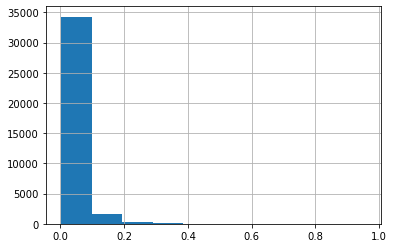

In [187]:
pd.Series(ps).hist()

### generate results (03052025) use old hyper params from manuscript_covariates_4

In [17]:
#Setup config from grid search
#cohort
best_A_params_cohort = {'alternatives':{'random_state': 0, 'boosting_type': 'gbdt', 'learning_rate': 0.1, 'num_leaves': 10, 'verbose': -1, "clf":lgb.LGBMClassifier()},'second_line':{'random_state': 0, 'boosting_type': 'gbdt', 'learning_rate': 0.05, 'num_leaves': 50, 'verbose': -1, "clf":lgb.LGBMClassifier()}} # best params for second line change for alternatives
best_D_params_cohort = {'alternatives':{'15': {'max_features': 'auto', 'min_samples_leaf': 75, 'n_estimators': 140, "clf":RandomForestClassifier()},
                                 '30':{'C': 0.25, 'penalty': 'l1',"solver":'liblinear', 'verbose': -1, "clf":LogisticRegression()},
                                 '90':{'boosting_type': 'gbdt', 'learning_rate': 0.05, 'num_leaves': 10, 'verbose': -1, "clf":lgb.LGBMClassifier()}},
                'second_line':{'15':{'boosting_type': 'gbdt', 'learning_rate': 0.01, 'num_leaves': 10, 'verbose': -1, "clf":lgb.LGBMClassifier()},
                               '30': {'boosting_type': 'gbdt', 'learning_rate': 0.05, 'num_leaves': 10, 'verbose': -1, "clf":lgb.LGBMClassifier()},
                               '90':{'boosting_type': 'gbdt', 'learning_rate': 0.05, 'num_leaves': 10, 'verbose': -1, "clf":lgb.LGBMClassifier()}}
                }
features = ["cohort_features","omop_1_year_features"]

#omop

best_A_params_omop = {'alternatives':{'random_state': 0, 'boosting_type': 'gbdt', 'learning_rate': 0.05, 'num_leaves': 50, 'verbose': -1, "clf":lgb.LGBMClassifier()},'second_line':{'random_state': 0, 'boosting_type': 'dart', 'learning_rate': 0.1, 'num_leaves': 50, 'verbose': -1, "clf":lgb.LGBMClassifier()}} # best params for second line change for alternatives
best_D_params_omop = {'alternatives':{'15':{'max_features': 'auto', 'min_samples_leaf': 50, 'n_estimators': 100, "clf":RandomForestClassifier()},
                                 '30':{'boosting_type': 'gbdt', 'learning_rate': 0.05, 'num_leaves': 250, 'verbose': -1, "clf":lgb.LGBMClassifier()},
                                 '90':{'max_features': 'auto', 'min_samples_leaf': 75, 'n_estimators': 140, "clf":RandomForestClassifier()}},
                'second_line':{'15':{'max_features': 'auto', 'min_samples_leaf': 75, 'n_estimators': 120, "clf":RandomForestClassifier()},
                               '30':{'max_features': 'auto', 'min_samples_leaf': 75, 'n_estimators': 100, "clf":RandomForestClassifier()},
                               '90':{'max_features': 'auto', 'min_samples_leaf': 75, 'n_estimators': 120, "clf":RandomForestClassifier()}}
                }
                      
ATE_A = {"cohort_features":best_A_params_cohort, "omop_1_year_features":best_A_params_omop}
ATE_D = {"cohort_features":best_D_params_cohort, "omop_1_year_features":best_D_params_omop}

In [139]:
trial_filtered_cohort = filtered_cohort.copy()
filtered_cohort.shape

(36445, 405)

In [198]:
filtered_cohort = trial_filtered_cohort.copy()

In [201]:
filtered_cohort.antibiotic_type.value_counts().sum() - 1427

35018

In [200]:
filtered_cohort.antibiotic_type.value_counts(normalize=True)

nitrofurantoin                   0.550528
trimethoprim-sulfamethoxazole    0.410317
alternatives                     0.039155
Name: antibiotic_type, dtype: float64

In [148]:
filtered_cohort.less_30.value_counts()

0    35934
1      511
Name: less_30, dtype: int64

In [157]:
filtered_cohort.less_30.shape

(36445,)

In [197]:
7467/36445

0.20488407188914803

In [196]:
filtered_cohort.shape

(7467, 405)

In [176]:

from collections import defaultdict
discard = True
results_df = defaultdict(dict)

A = outcome_dict['treatment'][treatment_name]

for feature in features:
    print(feature)
    results = pd.DataFrame(columns=['Outcome', 'E[Y_1]', 'E[Y_0]', 'ATE', '95% C.I.'])
    for y in efficacy_outcomes:
        X = feat_dict['treatment'][feature][0]
        time = out_time_dict[y]
        D = outcome_dict['censor'][time]
        params = (ATE_A[feature][treatment_name], ATE_D[feature][treatment_name][time])
        if discard:
            ps = run_ps3((X, A, filtered_cohort[y], D), params, prop = True)
            kp = np.where((ps >= 0.01) * (ps <= 0.90))
            temp_filtered_cohort = filtered_cohort.copy()
            filtered_cohort = filtered_cohort.iloc[kp]
            params = (ATE_A[feature][treatment_name], ATE_D[feature][treatment_name][time])
            summary = censor_bootstrap(X[kp], A.iloc[kp], y, D.iloc[kp], bootstrap_sample=100, other_word=y, params=params)
            filtered_cohort = temp_filtered_cohort.copy()
        else:
            summary = censor_bootstrap(X, A, y, D, bootstrap_sample=100, other_word=y, params=params)
        results.loc[len(results)] = [y] + summary
    
    results_df['t_efficacy'][feature] = results
    print("\n\n")
    
# for feature in features:
#     print(feature)
#     results = pd.DataFrame(columns=['Outcome', 'E[Y_1]', 'E[Y_0]', 'ATE', '95% C.I.'])
#     for y in adverse_event_outcomes:
#         X = feat_dict['treatment'][feature][0]
#         time = out_time_dict[y]
#         D = outcome_dict['censor'][time]
#         params = (ATE_A[feature][treatment_name], ATE_D[feature][treatment_name][time])
#         if discard:
#             ps = run_ps3((X, A, filtered_cohort[y], D), params, prop = True)
#             kp = np.where((ps >= 0.05) * (ps <= 0.95))
#             temp_filtered_cohort = filtered_cohort.copy()
#             filtered_cohort = filtered_cohort.iloc[kp]
#             params = (ATE_A[feature][treatment_name], ATE_D[feature][treatment_name][time])
#             summary = censor_bootstrap(X[kp], A.iloc[kp], y, D.iloc[kp], bootstrap_sample=1000, other_word=y, params=params)
#             filtered_cohort = temp_filtered_cohort.copy()
#         else:
#             summary = censor_bootstrap(X, A, y, D, bootstrap_sample=1000, other_word=y, params=params)
#         results.loc[len(results)] = [y] + summary
    
#     results_df['adverse_events'][feature] = results
#     print("\n\n")
    

# for feature in features:
#     print(feature)
#     results = pd.DataFrame(columns=['Outcome', 'E[Y_1]', 'E[Y_0]', 'ATE', '95% C.I.'])
#     for y in negative_control_outcomes:
#         X = feat_dict['treatment'][feature][0]
#         time = out_time_dict[y]
#         D = outcome_dict['censor'][time]
#         params = (ATE_A[feature][treatment_name], ATE_D[feature][treatment_name][time])
#         if discard:
#             ps = run_ps3((X, A, filtered_cohort[y], D), params, prop = True)
#             kp = np.where((ps >= 0.05) * (ps <= 0.95))
#             temp_filtered_cohort = filtered_cohort.copy()
#             filtered_cohort = filtered_cohort.iloc[kp]
#             params = (ATE_A[feature][treatment_name], ATE_D[feature][treatment_name][time])
#             summary = censor_bootstrap(X[kp], A.iloc[kp], y, D.iloc[kp], bootstrap_sample=1000, other_word=y, params=params)
#             filtered_cohort = temp_filtered_cohort.copy()
#         else:
#             summary = censor_bootstrap(X, A, y, D, bootstrap_sample=1000, other_word=y, params=params)
#         results.loc[len(results)] = [y] + summary
    
#     results_df['negative_controls'][feature] = results
#     print("\n\n")

cohort_features
[LibLinear]ATE for t_bin : 0.049713
95% C.I.: ( 0.026102 ,  0.075722 )
EY1: 0.225501
EY0: 0.175788
[LibLinear]ATE for t_sepsis_bin : 0.011952
95% C.I.: ( 0.006153 ,  0.018216 )
EY1: 0.016209
EY0: 0.004257
[LibLinear]ATE for t_i_uti_bin : 0.001343
95% C.I.: ( -0.00249 ,  0.005888 )
EY1: 0.005914
EY0: 0.004571
[LibLinear]ATE for t_i_neph_bin : 9.5e-05
95% C.I.: ( -0.000664 ,  0.001553 )
EY1: 0.00055
EY0: 0.000455
[LibLinear]ATE for t_i_sepsis_bin : 0.001133
95% C.I.: ( -0.000927 ,  0.003915 )
EY1: 0.002631
EY0: 0.001497
[LibLinear]ATE for t_i_bin : 0.00193
95% C.I.: ( -0.002526 ,  0.006463 )
EY1: 0.007882
EY0: 0.005952
[LibLinear]ATE for t_uti_bin : 0.047743
95% C.I.: ( 0.024273 ,  0.071539 )
EY1: 0.221384
EY0: 0.173641
[LibLinear]ATE for t_neph_bin : 0.007725
95% C.I.: ( 0.003328 ,  0.014396 )
EY1: 0.010265
EY0: 0.002541



omop_1_year_features


KeyboardInterrupt: 

In [87]:
%%time

from collections import defaultdict
discard = True
results_df = defaultdict(dict)

A = outcome_dict['treatment'][treatment_name]

for feature in features:
    print(feature)
    results = pd.DataFrame(columns=['Outcome', 'E[Y_1]', 'E[Y_0]', 'ATE', '95% C.I.'])
    for y in efficacy_outcomes:
        X = feat_dict['treatment'][feature][0]
        time = out_time_dict[y]
        D = outcome_dict['censor'][time]
        params = (ATE_A[feature][treatment_name], ATE_D[feature][treatment_name][time])
        if discard:
            ps = run_ps3((X, A, filtered_cohort[y], D), params, prop = True)
            kp = np.where((ps >= 0.05) * (ps <= 0.95))
            temp_filtered_cohort = filtered_cohort.copy()
            filtered_cohort = filtered_cohort.iloc[kp]
            params = (ATE_A[feature][treatment_name], ATE_D[feature][treatment_name][time])
            summary = censor_bootstrap(X[kp], A.iloc[kp], y, D.iloc[kp], bootstrap_sample=100, other_word=y, params=params)
            filtered_cohort = temp_filtered_cohort.copy()
        else:
            summary = censor_bootstrap(X, A, y, D, bootstrap_sample=100, other_word=y, params=params)
        results.loc[len(results)] = [y] + summary
    
    results_df['t_efficacy'][feature] = results
    print("\n\n")
    
# for feature in features:
#     print(feature)
#     results = pd.DataFrame(columns=['Outcome', 'E[Y_1]', 'E[Y_0]', 'ATE', '95% C.I.'])
#     for y in adverse_event_outcomes:
#         X = feat_dict['treatment'][feature][0]
#         time = out_time_dict[y]
#         D = outcome_dict['censor'][time]
#         params = (ATE_A[feature][treatment_name], ATE_D[feature][treatment_name][time])
#         if discard:
#             ps = run_ps3((X, A, filtered_cohort[y], D), params, prop = True)
#             kp = np.where((ps >= 0.05) * (ps <= 0.95))
#             temp_filtered_cohort = filtered_cohort.copy()
#             filtered_cohort = filtered_cohort.iloc[kp]
#             params = (ATE_A[feature][treatment_name], ATE_D[feature][treatment_name][time])
#             summary = censor_bootstrap(X[kp], A.iloc[kp], y, D.iloc[kp], bootstrap_sample=1000, other_word=y, params=params)
#             filtered_cohort = temp_filtered_cohort.copy()
#         else:
#             summary = censor_bootstrap(X, A, y, D, bootstrap_sample=1000, other_word=y, params=params)
#         results.loc[len(results)] = [y] + summary
    
#     results_df['adverse_events'][feature] = results
#     print("\n\n")
    

# for feature in features:
#     print(feature)
#     results = pd.DataFrame(columns=['Outcome', 'E[Y_1]', 'E[Y_0]', 'ATE', '95% C.I.'])
#     for y in negative_control_outcomes:
#         X = feat_dict['treatment'][feature][0]
#         time = out_time_dict[y]
#         D = outcome_dict['censor'][time]
#         params = (ATE_A[feature][treatment_name], ATE_D[feature][treatment_name][time])
#         if discard:
#             ps = run_ps3((X, A, filtered_cohort[y], D), params, prop = True)
#             kp = np.where((ps >= 0.05) * (ps <= 0.95))
#             temp_filtered_cohort = filtered_cohort.copy()
#             filtered_cohort = filtered_cohort.iloc[kp]
#             params = (ATE_A[feature][treatment_name], ATE_D[feature][treatment_name][time])
#             summary = censor_bootstrap(X[kp], A.iloc[kp], y, D.iloc[kp], bootstrap_sample=1000, other_word=y, params=params)
#             filtered_cohort = temp_filtered_cohort.copy()
#         else:
#             summary = censor_bootstrap(X, A, y, D, bootstrap_sample=1000, other_word=y, params=params)
#         results.loc[len(results)] = [y] + summary
    
#     results_df['negative_controls'][feature] = results
#     print("\n\n")

cohort_features
ATE for t_bin : 0.042416
95% C.I.: ( 0.015613 ,  0.069006 )
EY1: 0.215588
EY0: 0.173172
ATE for t_sepsis_bin : 0.013634
95% C.I.: ( 0.007072 ,  0.019611 )
EY1: 0.017587
EY0: 0.003953
ATE for t_i_uti_bin : 0.001325
95% C.I.: ( -0.002132 ,  0.005643 )
EY1: 0.005716
EY0: 0.004391
ATE for t_i_neph_bin : 0.000597
95% C.I.: ( -0.00057 ,  0.002703 )
EY1: 0.001026
EY0: 0.00043
ATE for t_i_sepsis_bin : 0.000619
95% C.I.: ( -0.000664 ,  0.002655 )
EY1: 0.002018
EY0: 0.001399
ATE for t_i_bin : 0.001794
95% C.I.: ( -0.001978 ,  0.00736 )
EY1: 0.00748
EY0: 0.005686
ATE for t_uti_bin : 0.0388
95% C.I.: ( 0.012398 ,  0.065326 )
EY1: 0.210054
EY0: 0.171255
ATE for t_neph_bin : 0.007629
95% C.I.: ( 0.001991 ,  0.012003 )
EY1: 0.010012
EY0: 0.002383



omop_1_year_features


KeyboardInterrupt: 

### generate results (03052025)  changed the hyperparams for the censor 30 cohort model and testing on cohort with 100 iterations to see if ci is lower

In [ ]:
%%time

from collections import defaultdict
discard = True
results_df = defaultdict(dict)

A = outcome_dict['treatment'][treatment_name]

for feature in features:
    print(feature)
    results = pd.DataFrame(columns=['Outcome', 'E[Y_1]', 'E[Y_0]', 'ATE', '95% C.I.'])
    for y in efficacy_outcomes:
        X = feat_dict['treatment'][feature][0]
        time = out_time_dict[y]
        D = outcome_dict['censor'][time]
        params = (ATE_A[feature][treatment_name], ATE_D[feature][treatment_name][time])
        if discard:
            ps = run_ps3((X, A, filtered_cohort[y], D), params, prop = True)
            kp = np.where((ps >= 0.05) * (ps <= 0.95))
            temp_filtered_cohort = filtered_cohort.copy()
            filtered_cohort = filtered_cohort.iloc[kp]
            params = (ATE_A[feature][treatment_name], ATE_D[feature][treatment_name][time])
            summary = censor_bootstrap(X[kp], A.iloc[kp], y, D.iloc[kp], bootstrap_sample=100, other_word=y, params=params)
            filtered_cohort = temp_filtered_cohort.copy()
        else:
            summary = censor_bootstrap(X, A, y, D, bootstrap_sample=100, other_word=y, params=params)
        results.loc[len(results)] = [y] + summary
    
    results_df['t_efficacy'][feature] = results
    print("\n\n")
    
# for feature in features:
#     print(feature)
#     results = pd.DataFrame(columns=['Outcome', 'E[Y_1]', 'E[Y_0]', 'ATE', '95% C.I.'])
#     for y in adverse_event_outcomes:
#         X = feat_dict['treatment'][feature][0]
#         time = out_time_dict[y]
#         D = outcome_dict['censor'][time]
#         params = (ATE_A[feature][treatment_name], ATE_D[feature][treatment_name][time])
#         if discard:
#             ps = run_ps3((X, A, filtered_cohort[y], D), params, prop = True)
#             kp = np.where((ps >= 0.05) * (ps <= 0.95))
#             temp_filtered_cohort = filtered_cohort.copy()
#             filtered_cohort = filtered_cohort.iloc[kp]
#             params = (ATE_A[feature][treatment_name], ATE_D[feature][treatment_name][time])
#             summary = censor_bootstrap(X[kp], A.iloc[kp], y, D.iloc[kp], bootstrap_sample=1000, other_word=y, params=params)
#             filtered_cohort = temp_filtered_cohort.copy()
#         else:
#             summary = censor_bootstrap(X, A, y, D, bootstrap_sample=1000, other_word=y, params=params)
#         results.loc[len(results)] = [y] + summary
    
#     results_df['adverse_events'][feature] = results
#     print("\n\n")
    

# for feature in features:
#     print(feature)
#     results = pd.DataFrame(columns=['Outcome', 'E[Y_1]', 'E[Y_0]', 'ATE', '95% C.I.'])
#     for y in negative_control_outcomes:
#         X = feat_dict['treatment'][feature][0]
#         time = out_time_dict[y]
#         D = outcome_dict['censor'][time]
#         params = (ATE_A[feature][treatment_name], ATE_D[feature][treatment_name][time])
#         if discard:
#             ps = run_ps3((X, A, filtered_cohort[y], D), params, prop = True)
#             kp = np.where((ps >= 0.05) * (ps <= 0.95))
#             temp_filtered_cohort = filtered_cohort.copy()
#             filtered_cohort = filtered_cohort.iloc[kp]
#             params = (ATE_A[feature][treatment_name], ATE_D[feature][treatment_name][time])
#             summary = censor_bootstrap(X[kp], A.iloc[kp], y, D.iloc[kp], bootstrap_sample=1000, other_word=y, params=params)
#             filtered_cohort = temp_filtered_cohort.copy()
#         else:
#             summary = censor_bootstrap(X, A, y, D, bootstrap_sample=1000, other_word=y, params=params)
#         results.loc[len(results)] = [y] + summary
    
#     results_df['negative_controls'][feature] = results
#     print("\n\n")

### generate results (0302024)

In [49]:
%%time

from collections import defaultdict
discard = True
results_df = defaultdict(dict)

A = outcome_dict['treatment'][treatment_name]

for feature in features:
    print(feature)
    results = pd.DataFrame(columns=['Outcome', 'E[Y_1]', 'E[Y_0]', 'ATE', '95% C.I.'])
    for y in efficacy_outcomes:
        X = feat_dict['treatment'][feature][0]
        time = out_time_dict[y]
        D = outcome_dict['censor'][time]
        params = (ATE_A[feature][treatment_name], ATE_D[feature][treatment_name][time])
        if discard:
            ps = run_ps3((X, A, filtered_cohort[y], D), params, prop = True)
            kp = np.where((ps >= 0.05) * (ps <= 0.95))
            temp_filtered_cohort = filtered_cohort.copy()
            filtered_cohort = filtered_cohort.iloc[kp]
            params = (ATE_A[feature][treatment_name], ATE_D[feature][treatment_name][time])
            summary = censor_bootstrap(X[kp], A.iloc[kp], y, D.iloc[kp], bootstrap_sample=1000, other_word=y, params=params)
            filtered_cohort = temp_filtered_cohort.copy()
        else:
            summary = censor_bootstrap(X, A, y, D, bootstrap_sample=1000, other_word=y, params=params)
        results.loc[len(results)] = [y] + summary
    
    results_df['t_efficacy'][feature] = results
    print("\n\n")
    
for feature in features:
    print(feature)
    results = pd.DataFrame(columns=['Outcome', 'E[Y_1]', 'E[Y_0]', 'ATE', '95% C.I.'])
    for y in adverse_event_outcomes:
        X = feat_dict['treatment'][feature][0]
        time = out_time_dict[y]
        D = outcome_dict['censor'][time]
        params = (ATE_A[feature][treatment_name], ATE_D[feature][treatment_name][time])
        if discard:
            ps = run_ps3((X, A, filtered_cohort[y], D), params, prop = True)
            kp = np.where((ps >= 0.05) * (ps <= 0.95))
            temp_filtered_cohort = filtered_cohort.copy()
            filtered_cohort = filtered_cohort.iloc[kp]
            params = (ATE_A[feature][treatment_name], ATE_D[feature][treatment_name][time])
            summary = censor_bootstrap(X[kp], A.iloc[kp], y, D.iloc[kp], bootstrap_sample=1000, other_word=y, params=params)
            filtered_cohort = temp_filtered_cohort.copy()
        else:
            summary = censor_bootstrap(X, A, y, D, bootstrap_sample=1000, other_word=y, params=params)
        results.loc[len(results)] = [y] + summary
    
    results_df['adverse_events'][feature] = results
    print("\n\n")
    

for feature in features:
    print(feature)
    results = pd.DataFrame(columns=['Outcome', 'E[Y_1]', 'E[Y_0]', 'ATE', '95% C.I.'])
    for y in negative_control_outcomes:
        X = feat_dict['treatment'][feature][0]
        time = out_time_dict[y]
        D = outcome_dict['censor'][time]
        params = (ATE_A[feature][treatment_name], ATE_D[feature][treatment_name][time])
        if discard:
            ps = run_ps3((X, A, filtered_cohort[y], D), params, prop = True)
            kp = np.where((ps >= 0.05) * (ps <= 0.95))
            temp_filtered_cohort = filtered_cohort.copy()
            filtered_cohort = filtered_cohort.iloc[kp]
            params = (ATE_A[feature][treatment_name], ATE_D[feature][treatment_name][time])
            summary = censor_bootstrap(X[kp], A.iloc[kp], y, D.iloc[kp], bootstrap_sample=1000, other_word=y, params=params)
            filtered_cohort = temp_filtered_cohort.copy()
        else:
            summary = censor_bootstrap(X, A, y, D, bootstrap_sample=1000, other_word=y, params=params)
        results.loc[len(results)] = [y] + summary
    
    results_df['negative_controls'][feature] = results
    print("\n\n")

cohort_features
ATE for t_bin : 0.075225
95% C.I.: ( 0.040858 ,  0.106257 )
EY1: 0.347483
EY0: 0.272258
ATE for t_sepsis_bin : 0.028769
95% C.I.: ( 0.016452 ,  0.042265 )
EY1: 0.043406
EY0: 0.014637
ATE for t_i_uti_bin : -0.000824
95% C.I.: ( -0.009033 ,  0.007816 )
EY1: 0.013757
EY0: 0.014581
ATE for t_i_neph_bin : -0.001285
95% C.I.: ( -0.002216 ,  -0.000484 )
EY1: 0.0
EY0: 0.001285
ATE for t_i_sepsis_bin : 0.004865
95% C.I.: ( -0.001319 ,  0.012129 )
EY1: 0.009008
EY0: 0.004143
ATE for t_i_bin : 0.000103
95% C.I.: ( -0.008738 ,  0.010358 )
EY1: 0.018683
EY0: 0.01858
ATE for t_uti_bin : 0.068098
95% C.I.: ( 0.033699 ,  0.10242 )
EY1: 0.336504
EY0: 0.268406
ATE for t_neph_bin : 0.009022
95% C.I.: ( 0.002264 ,  0.016103 )
EY1: 0.013721
EY0: 0.004699



omop_1_year_features
ATE for t_bin : 0.066179
95% C.I.: ( 0.037546 ,  0.093875 )
EY1: 0.344113
EY0: 0.277934
ATE for t_sepsis_bin : 0.037206
95% C.I.: ( 0.024558 ,  0.04926 )
EY1: 0.048801
EY0: 0.011596
ATE for t_i_uti_bin : -0.001633
95

### Generate Final Results

In [ ]:
%%time

from collections import defaultdict
discard = True
results_df = defaultdict(dict)

A = outcome_dict['treatment'][treatment_name]

for feature in features:
    print(feature)
    results = pd.DataFrame(columns=['Outcome', 'E[Y_1]', 'E[Y_0]', 'ATE', '95% C.I.'])
    for y in efficacy_outcomes:
        X = feat_dict['treatment'][feature][0]
        time = out_time_dict[y]
        D = outcome_dict['censor'][time]
        params = (ATE_A[feature][treatment_name], ATE_D[feature][treatment_name][time])
        if discard:
            ps = run_ps3((X, A, filtered_cohort[y], D), params, prop = True)
            kp = np.where((ps >= 0.05) * (ps <= 0.95))
            temp_filtered_cohort = filtered_cohort.copy()
            filtered_cohort = filtered_cohort.iloc[kp]
            params = (ATE_A[feature][treatment_name], ATE_D[feature][treatment_name][time])
            summary = censor_bootstrap(X[kp], A.iloc[kp], y, D.iloc[kp], bootstrap_sample=100, other_word=y, params=params)
            filtered_cohort = temp_filtered_cohort.copy()
        else:
            summary = censor_bootstrap(X, A, y, D, bootstrap_sample=100, other_word=y, params=params)
        results.loc[len(results)] = [y] + summary
    
    results_df['t_efficacy'][feature] = results
    print("\n\n")
    
for feature in features:
    print(feature)
    results = pd.DataFrame(columns=['Outcome', 'E[Y_1]', 'E[Y_0]', 'ATE', '95% C.I.'])
    for y in adverse_event_outcomes:
        X = feat_dict['treatment'][feature][0]
        time = out_time_dict[y]
        D = outcome_dict['censor'][time]
        params = (ATE_A[feature][treatment_name], ATE_D[feature][treatment_name][time])
        if discard:
            ps = run_ps3((X, A, filtered_cohort[y], D), params, prop = True)
            kp = np.where((ps >= 0.05) * (ps <= 0.95))
            temp_filtered_cohort = filtered_cohort.copy()
            filtered_cohort = filtered_cohort.iloc[kp]
            params = (ATE_A[feature][treatment_name], ATE_D[feature][treatment_name][time])
            summary = censor_bootstrap(X[kp], A.iloc[kp], y, D.iloc[kp], bootstrap_sample=100, other_word=y, params=params)
            filtered_cohort = temp_filtered_cohort.copy()
        else:
            summary = censor_bootstrap(X, A, y, D, bootstrap_sample=100, other_word=y, params=params)
        results.loc[len(results)] = [y] + summary
    
    results_df['adverse_events'][feature] = results
    print("\n\n")
    

for feature in features:
    print(feature)
    results = pd.DataFrame(columns=['Outcome', 'E[Y_1]', 'E[Y_0]', 'ATE', '95% C.I.'])
    for y in negative_control_outcomes:
        X = feat_dict['treatment'][feature][0]
        time = out_time_dict[y]
        D = outcome_dict['censor'][time]
        params = (ATE_A[feature][treatment_name], ATE_D[feature][treatment_name][time])
        if discard:
            ps = run_ps3((X, A, filtered_cohort[y], D), params, prop = True)
            kp = np.where((ps >= 0.05) * (ps <= 0.95))
            temp_filtered_cohort = filtered_cohort.copy()
            filtered_cohort = filtered_cohort.iloc[kp]
            params = (ATE_A[feature][treatment_name], ATE_D[feature][treatment_name][time])
            summary = censor_bootstrap(X[kp], A.iloc[kp], y, D.iloc[kp], bootstrap_sample=100, other_word=y, params=params)
            filtered_cohort = temp_filtered_cohort.copy()
        else:
            summary = censor_bootstrap(X, A, y, D, bootstrap_sample=100, other_word=y, params=params)
        results.loc[len(results)] = [y] + summary
    
    results_df['negative_controls'][feature] = results
    print("\n\n")

cohort_features
[LibLinear]ATE for t_bin : 0.063098
95% C.I.: ( 0.024536 ,  0.105805 )
EY1: 0.326362
EY0: 0.263265
[LibLinear]ATE for t_sepsis_bin : 0.022353
95% C.I.: ( 0.008739 ,  0.038265 )
EY1: 0.036835
EY0: 0.014483
[LibLinear]ATE for t_i_uti_bin : -0.001653
95% C.I.: ( -0.009258 ,  0.007515 )
EY1: 0.012179
EY0: 0.013832
[LibLinear]ATE for t_i_neph_bin : -0.001155
95% C.I.: ( -0.002098 ,  -0.000483 )
EY1: 0.0
EY0: 0.001155
[LibLinear]ATE for t_i_sepsis_bin : 0.000148
95% C.I.: ( -0.003107 ,  0.004034 )
EY1: 0.004512
EY0: 0.004364
[LibLinear]ATE for t_i_bin : -0.003393
95% C.I.: ( -0.010669 ,  0.004379 )
EY1: 0.014547
EY0: 0.01794
[LibLinear]ATE for t_uti_bin : 0.058068
95% C.I.: ( 0.025498 ,  0.092078 )
EY1: 0.318177
EY0: 0.26011
[LibLinear]ATE for t_neph_bin : 0.012781
95% C.I.: ( 0.004285 ,  0.023774 )
EY1: 0.017044
EY0: 0.004263



omop_1_year_features
ATE for t_bin : 0.063416
95% C.I.: ( 0.035495 ,  0.090875 )
EY1: 0.338014
EY0: 0.274598
ATE for t_sepsis_bin : 0.036742
95% C.I

In [50]:
import pickle
pickle.dump(results_df,open(f'final_{treatment_name}_03042024_results.pkl','wb'))

### V4 Config

In [58]:
# #Setup config from grid search
# #cohort
# best_A_params_cohort = {'alternatives':{'random_state': 0, 'boosting_type': 'gbdt', 'learning_rate': 0.1, 'num_leaves': 10, 'verbose': -1, "clf":lgb.LGBMClassifier()},'second_line':{'random_state': 0, 'boosting_type': 'gbdt', 'learning_rate': 0.05, 'num_leaves': 50, 'verbose': -1, "clf":lgb.LGBMClassifier()}} # best params for second line change for alternatives
# best_D_params_cohort = {'alternatives':{'15': {'max_features': 'auto', 'min_samples_leaf': 75, 'n_estimators': 140, "clf":RandomForestClassifier()},
#                                  '30':{'C': 0.25, 'penalty': 'l1',"solver":'liblinear', 'verbose': -1, "clf":LogisticRegression()},
#                                  '90':{'boosting_type': 'gbdt', 'learning_rate': 0.05, 'num_leaves': 10, 'verbose': -1, "clf":lgb.LGBMClassifier()}},
#                 'second_line':{'15':{'boosting_type': 'gbdt', 'learning_rate': 0.01, 'num_leaves': 10, 'verbose': -1, "clf":lgb.LGBMClassifier()},
#                                '30': {'boosting_type': 'gbdt', 'learning_rate': 0.05, 'num_leaves': 10, 'verbose': -1, "clf":lgb.LGBMClassifier()},
#                                '90':{'boosting_type': 'gbdt', 'learning_rate': 0.05, 'num_leaves': 10, 'verbose': -1, "clf":lgb.LGBMClassifier()}}
#                 }
# features = ["cohort_features","omop_1_year_features"]

# #omop

# best_A_params_omop = {'alternatives':{'random_state': 0, 'boosting_type': 'gbdt', 'learning_rate': 0.05, 'num_leaves': 50, 'verbose': -1, "clf":lgb.LGBMClassifier()},'second_line':{'random_state': 0, 'boosting_type': 'dart', 'learning_rate': 0.1, 'num_leaves': 50, 'verbose': -1, "clf":lgb.LGBMClassifier()}} # best params for second line change for alternatives
# best_D_params_omop = {'alternatives':{'15':{'max_features': 'auto', 'min_samples_leaf': 50, 'n_estimators': 100, "clf":RandomForestClassifier()},
#                                  '30':{'boosting_type': 'gbdt', 'learning_rate': 0.05, 'num_leaves': 250, 'verbose': -1, "clf":lgb.LGBMClassifier()},
#                                  '90':{'max_features': 'auto', 'min_samples_leaf': 75, 'n_estimators': 140, "clf":RandomForestClassifier()}},
#                 'second_line':{'15':{'max_features': 'auto', 'min_samples_leaf': 75, 'n_estimators': 120, "clf":RandomForestClassifier()},
#                                '30':{'max_features': 'auto', 'min_samples_leaf': 75, 'n_estimators': 100, "clf":RandomForestClassifier()},
#                                '90':{'max_features': 'auto', 'min_samples_leaf': 75, 'n_estimators': 120, "clf":RandomForestClassifier()}}
#                 }
                      
# ATE_A = {"cohort_features":best_A_params_cohort, "omop_1_year_features":best_A_params_omop}
# ATE_D = {"cohort_features":best_D_params_cohort, "omop_1_year_features":best_D_params_omop}

### V2 config

In [41]:
# #Setup config from grid search
# #cohort
# best_A_params_cohort = {'alternatives':{'random_state': 0, 'boosting_type': 'gbdt', 'learning_rate': 0.1, 'num_leaves': 10, 'verbose': -1, "clf":lgb.LGBMClassifier()},'second_line':{'random_state': 0, 'boosting_type': 'gbdt', 'learning_rate': 0.1, 'num_leaves': 10, 'verbose': -1, "clf":lgb.LGBMClassifier()}} # best params for second line change for alternatives
# best_D_params_cohort = {'alternatives':{'15': {'max_features': 'auto', 'min_samples_leaf': 50, 'n_estimators': 140, "clf":RandomForestClassifier()},
#                                  '30':{'max_features': 'auto', 'min_samples_leaf': 50, 'n_estimators': 60, "clf":RandomForestClassifier()},
#                                  '90':{'boosting_type': 'gbdt', 'learning_rate': 0.05, 'num_leaves': 10, 'verbose': -1, "clf":lgb.LGBMClassifier()}},
#                 'second_line':{'15':{'C': 0.1, 'penalty': 'l1',"solver":'liblinear', 'verbose': -1, "clf":LogisticRegression()},
#                                '30': {'boosting_type': 'dart', 'learning_rate': 0.1, 'num_leaves': 10, 'verbose': -1, "clf":lgb.LGBMClassifier()},
#                                '90':{'boosting_type': 'gbdt', 'learning_rate': 0.05, 'num_leaves': 10, 'verbose': -1, "clf":lgb.LGBMClassifier()}}
#                 }
# features = ["cohort_features","omop_1_year_features"]

# #omop

# best_A_params_omop = {'alternatives':{'random_state': 0, 'boosting_type': 'gbdt', 'learning_rate': 0.05, 'num_leaves': 50, 'verbose': -1, "clf":lgb.LGBMClassifier()},'second_line':{'random_state': 0, 'boosting_type': 'dart', 'learning_rate': 0.1, 'num_leaves': 50, 'verbose': -1, "clf":lgb.LGBMClassifier()}} # best params for second line change for alternatives
# best_D_params_omop = {'alternatives':{'15':{'max_features': 'auto', 'min_samples_leaf': 50, 'n_estimators': 100, "clf":RandomForestClassifier()},
#                                  '30':{'boosting_type': 'gbdt', 'learning_rate': 0.05, 'num_leaves': 250, 'verbose': -1, "clf":lgb.LGBMClassifier()},
#                                  '90':{'max_features': 'auto', 'min_samples_leaf': 75, 'n_estimators': 140, "clf":RandomForestClassifier()}},
#                 'second_line':{'15':{'max_features': 'auto', 'min_samples_leaf': 75, 'n_estimators': 120, "clf":RandomForestClassifier()},
#                                '30':{'max_features': 'auto', 'min_samples_leaf': 75, 'n_estimators': 100, "clf":RandomForestClassifier()},
#                                '90':{'max_features': 'auto', 'min_samples_leaf': 75, 'n_estimators': 120, "clf":RandomForestClassifier()}}
#                 }
                      
# ATE_A = {"cohort_features":best_A_params_cohort, "omop_1_year_features":best_A_params_omop}
# ATE_D = {"cohort_features":best_D_params_cohort, "omop_1_year_features":best_D_params_omop}

In [ ]:
%%time
discard = True

#run bootstrap

A = outcome_dict['treatment'][treatment_name]



In [ ]:
%%time

discard = True

#run bootstrap



### V4 (start)

In [60]:
%%time

discard = True

A = outcome_dict['treatment'][treatment_name]

for feature in features:
    print(feature)
    results = pd.DataFrame(columns=['Outcome', 'E[Y_1]', 'E[Y_0]', 'ATE', '95% C.I.'])
    for y in efficacy_outcomes:
        X = feat_dict['treatment'][feature][0]
        time = out_time_dict[y]
        D = outcome_dict['censor'][time]
        params = (ATE_A[feature][treatment_name], ATE_D[feature][treatment_name][time])
        if discard:
            ps = run_ps3((X, A, filtered_cohort[y], D), params, prop = True)
            kp = np.where((ps >= 0.05) * (ps <= 0.95))
            temp_filtered_cohort = filtered_cohort.copy()
            filtered_cohort = filtered_cohort.iloc[kp]
            params = (ATE_A[feature][treatment_name], ATE_D[feature][treatment_name][time])
            summary = censor_bootstrap(X[kp], A.iloc[kp], y, D.iloc[kp], bootstrap_sample=100, other_word=y, params=params)
            filtered_cohort = temp_filtered_cohort.copy()
        else:
            summary = censor_bootstrap(X, A, y, D, bootstrap_sample=100, other_word=y, params=params)
        results.loc[len(results)] = [y] + summary
    
    results_df['t_efficacy'][feature] = results
    print("\n\n")

cohort_features
ATE for t_bin : 0.097272
95% C.I.: ( 0.080857 ,  0.112322 )
EY1: 0.291087
EY0: 0.193815
ATE for t_sepsis_bin : 0.019112
95% C.I.: ( 0.015054 ,  0.023182 )
EY1: 0.024846
EY0: 0.005734
ATE for t_i_uti_bin : 0.006885
95% C.I.: ( 0.004517 ,  0.009911 )
EY1: 0.01378
EY0: 0.006896
ATE for t_i_neph_bin : 0.002179
95% C.I.: ( 0.000866 ,  0.003408 )
EY1: 0.002677
EY0: 0.000498
ATE for t_i_sepsis_bin : 0.001949
95% C.I.: ( 0.000624 ,  0.003112 )
EY1: 0.003889
EY0: 0.00194
ATE for t_i_bin : 0.010955
95% C.I.: ( 0.008164 ,  0.014582 )
EY1: 0.019452
EY0: 0.008497
ATE for t_uti_bin : 0.091569
95% C.I.: ( 0.079503 ,  0.102225 )
EY1: 0.283856
EY0: 0.192287
ATE for t_neph_bin : 0.014043
95% C.I.: ( 0.009674 ,  0.018282 )
EY1: 0.017012
EY0: 0.00297



CPU times: user 7min 25s, sys: 56.8 s, total: 8min 22s
Wall time: 2min 1s


In [61]:
discard = True

#run bootstrap

A = outcome_dict['treatment'][treatment_name]

results_df = defaultdict(dict)

for feature in features:
    print(feature)
    results = pd.DataFrame(columns=['Outcome', 'E[Y_1]', 'E[Y_0]', 'ATE', '95% C.I.'])
    for y in adverse_event_outcomes:
        X = feat_dict['treatment'][feature][0]
        time = out_time_dict[y]
        D = outcome_dict['censor'][time]
        params = (ATE_A[feature][treatment_name], ATE_D[feature][treatment_name][time])
        if discard:
            ps = run_ps3((X, A, filtered_cohort[y], D), params, prop = True)
            kp = np.where((ps >= 0.05) * (ps <= 0.95))
            temp_filtered_cohort = filtered_cohort.copy()
            filtered_cohort = filtered_cohort.iloc[kp]
            params = (ATE_A[feature][treatment_name], ATE_D[feature][treatment_name][time])
            summary = censor_bootstrap(X[kp], A.iloc[kp], y, D.iloc[kp], bootstrap_sample=100, other_word=y, params=params)
            filtered_cohort = temp_filtered_cohort.copy()
        else:
            summary = censor_bootstrap(X, A, y, D, bootstrap_sample=100, other_word=y, params=params)
        results.loc[len(results)] = [y] + summary
    
    results_df['adverse_events'][feature] = results
    print("\n\n")

cohort_features
ATE for AE_c_diff : 0.002856
95% C.I.: ( 0.001494 ,  0.004729 )
EY1: 0.004472
EY0: 0.001616
ATE for AE_skin : 0.001443
95% C.I.: ( -0.001926 ,  0.005266 )
EY1: 0.00948
EY0: 0.008037
ATE for AE_GI : 0.006943
95% C.I.: ( 0.004291 ,  0.009338 )
EY1: 0.011387
EY0: 0.004444
ATE for AE_AKI : 0.018109
95% C.I.: ( 0.01505 ,  0.021432 )
EY1: 0.026839
EY0: 0.00873
ATE for AE_other : 0.020753
95% C.I.: ( 0.016723 ,  0.026727 )
EY1: 0.039628
EY0: 0.018876
ATE for AE_any : 0.03939
95% C.I.: ( 0.03284 ,  0.046873 )
EY1: 0.07606
EY0: 0.03667





### V4 (end)

### V2 (start)

In [43]:
discard = True

#run bootstrap

A = outcome_dict['treatment'][treatment_name]

results_df = defaultdict(dict)

for feature in features:
    print(feature)
    results = pd.DataFrame(columns=['Outcome', 'E[Y_1]', 'E[Y_0]', 'ATE', '95% C.I.'])
    for y in adverse_event_outcomes:
        X = feat_dict['treatment'][feature][0]
        time = out_time_dict[y]
        D = outcome_dict['censor'][time]
        params = (ATE_A[feature][treatment_name], ATE_D[feature][treatment_name][time])
        if discard:
            ps = run_ps3((X, A, filtered_cohort[y], D), params, prop = True)
            kp = np.where((ps >= 0.05) * (ps <= 0.95))
            temp_filtered_cohort = filtered_cohort.copy()
            filtered_cohort = filtered_cohort.iloc[kp]
            params = (ATE_A[feature][treatment_name], ATE_D[feature][treatment_name][time])
            summary = censor_bootstrap(X[kp], A.iloc[kp], y, D.iloc[kp], bootstrap_sample=100, other_word=y, params=params)
            filtered_cohort = temp_filtered_cohort.copy()
        else:
            summary = censor_bootstrap(X, A, y, D, bootstrap_sample=100, other_word=y, params=params)
        results.loc[len(results)] = [y] + summary
    
    results_df['adverse_events'][feature] = results
    print("\n\n")

cohort_features
ATE for AE_c_diff : 0.003039
95% C.I.: ( 0.001573 ,  0.004502 )
EY1: 0.004558
EY0: 0.00152
ATE for AE_skin : 0.001002
95% C.I.: ( -0.002184 ,  0.004659 )
EY1: 0.009052
EY0: 0.00805
ATE for AE_GI : 0.007402
95% C.I.: ( 0.004611 ,  0.010416 )
EY1: 0.011759
EY0: 0.004357
ATE for AE_AKI : 0.020866
95% C.I.: ( 0.016853 ,  0.024768 )
EY1: 0.029199
EY0: 0.008332
ATE for AE_other : 0.023535
95% C.I.: ( 0.018472 ,  0.027753 )
EY1: 0.041542
EY0: 0.018007
ATE for AE_any : 0.044591
95% C.I.: ( 0.037486 ,  0.051889 )
EY1: 0.080005
EY0: 0.035414





In [44]:
%%time

discard = True

A = outcome_dict['treatment'][treatment_name]

for feature in features:
    print(feature)
    results = pd.DataFrame(columns=['Outcome', 'E[Y_1]', 'E[Y_0]', 'ATE', '95% C.I.'])
    for y in efficacy_outcomes:
        X = feat_dict['treatment'][feature][0]
        time = out_time_dict[y]
        D = outcome_dict['censor'][time]
        params = (ATE_A[feature][treatment_name], ATE_D[feature][treatment_name][time])
        if discard:
            ps = run_ps3((X, A, filtered_cohort[y], D), params, prop = True)
            kp = np.where((ps >= 0.05) * (ps <= 0.95))
            temp_filtered_cohort = filtered_cohort.copy()
            filtered_cohort = filtered_cohort.iloc[kp]
            params = (ATE_A[feature][treatment_name], ATE_D[feature][treatment_name][time])
            summary = censor_bootstrap(X[kp], A.iloc[kp], y, D.iloc[kp], bootstrap_sample=100, other_word=y, params=params)
            filtered_cohort = temp_filtered_cohort.copy()
        else:
            summary = censor_bootstrap(X, A, y, D, bootstrap_sample=100, other_word=y, params=params)
        results.loc[len(results)] = [y] + summary
    
    results_df['t_efficacy'][feature] = results
    print("\n\n")

cohort_features
ATE for t_bin : 0.104295
95% C.I.: ( 0.093035 ,  0.11694 )
EY1: 0.296703
EY0: 0.192408
ATE for t_sepsis_bin : 0.020253
95% C.I.: ( 0.015851 ,  0.025174 )
EY1: 0.025826
EY0: 0.005573
ATE for t_i_uti_bin : 0.007417
95% C.I.: ( 0.004728 ,  0.010291 )
EY1: 0.0142
EY0: 0.006784
ATE for t_i_neph_bin : 0.002427
95% C.I.: ( 0.00077 ,  0.004409 )
EY1: 0.00294
EY0: 0.000513
ATE for t_i_sepsis_bin : 0.002381
95% C.I.: ( 0.000895 ,  0.003783 )
EY1: 0.004174
EY0: 0.001793
ATE for t_i_bin : 0.011772
95% C.I.: ( 0.008645 ,  0.015889 )
EY1: 0.020049
EY0: 0.008277
ATE for t_uti_bin : 0.098381
95% C.I.: ( 0.086717 ,  0.110178 )
EY1: 0.289302
EY0: 0.190921
ATE for t_neph_bin : 0.014056
95% C.I.: ( 0.010619 ,  0.018175 )
EY1: 0.016895
EY0: 0.002838



CPU times: user 3min 28s, sys: 25.5 s, total: 3min 54s
Wall time: 2min 58s


### V2 (end)

### Have to reinitialize filtered_cohort to use the omp version

In [ ]:
## in order to get it to work, you need to make sure that filtered_cohort is the one from omop.  I think the notebook would benefit from changing that name.

In [26]:
discard = True

#run bootstrap

A = outcome_dict['treatment'][treatment_name]

results_df = defaultdict(dict)

for feature in features:
    print(feature)
    results = pd.DataFrame(columns=['Outcome', 'E[Y_1]', 'E[Y_0]', 'ATE', '95% C.I.'])
    for y in adverse_event_outcomes:
        X = feat_dict['treatment'][feature][0]
        time = out_time_dict[y]
        D = outcome_dict['censor'][time]
        params = (ATE_A[feature][treatment_name], ATE_D[feature][treatment_name][time])
        if discard:
            ps = run_ps3((X, A, filtered_cohort[y], D), params, prop = True)
            kp = np.where((ps >= 0.05) * (ps <= 0.95))
            temp_filtered_cohort = filtered_cohort.copy()
            filtered_cohort = filtered_cohort.iloc[kp]
            params = (ATE_A[feature][treatment_name], ATE_D[feature][treatment_name][time])
            summary = censor_bootstrap(X[kp], A.iloc[kp], y, D.iloc[kp], bootstrap_sample=100, other_word=y, params=params)
            filtered_cohort = temp_filtered_cohort.copy()
        else:
            summary = censor_bootstrap(X, A, y, D, bootstrap_sample=100, other_word=y, params=params)
        results.loc[len(results)] = [y] + summary
    
    results_df['adverse_events'][feature] = results
    print("\n\n")

omop_1_year_features
ATE for AE_c_diff : 0.000318
95% C.I.: ( -0.000195 ,  0.000892 )
EY1: 0.001537
EY0: 0.001219
ATE for AE_skin : -0.002892
95% C.I.: ( -0.004197 ,  -0.001539 )
EY1: 0.005159
EY0: 0.008051
ATE for AE_GI : 0.002501
95% C.I.: ( 0.001028 ,  0.003404 )
EY1: 0.006152
EY0: 0.003652
ATE for AE_AKI : 0.006063
95% C.I.: ( 0.004778 ,  0.007505 )
EY1: 0.012472
EY0: 0.006409
ATE for AE_other : 0.00851
95% C.I.: ( 0.00581 ,  0.010575 )
EY1: 0.023609
EY0: 0.015099
ATE for AE_any : 0.011521
95% C.I.: ( 0.008393 ,  0.014412 )
EY1: 0.042509
EY0: 0.030989





In [27]:
%%time

discard = True

#run bootstrap

A = outcome_dict['treatment'][treatment_name]

for feature in features:
    print(feature)
    results = pd.DataFrame(columns=['Outcome', 'E[Y_1]', 'E[Y_0]', 'ATE', '95% C.I.'])
    for y in negative_control_outcomes:
        X = feat_dict['treatment'][feature][0]
        time = out_time_dict[y]
        D = outcome_dict['censor'][time]
        params = (ATE_A[feature][treatment_name], ATE_D[feature][treatment_name][time])
        if discard:
            ps = run_ps3((X, A, filtered_cohort[y], D), params, prop = True)
            kp = np.where((ps >= 0.05) * (ps <= 0.95))
            temp_filtered_cohort = filtered_cohort.copy()
            filtered_cohort = filtered_cohort.iloc[kp]
            params = (ATE_A[feature][treatment_name], ATE_D[feature][treatment_name][time])
            summary = censor_bootstrap(X[kp], A.iloc[kp], y, D.iloc[kp], bootstrap_sample=100, other_word=y, params=params)
            filtered_cohort = temp_filtered_cohort.copy()
        else:
            summary = censor_bootstrap(X, A, y, D, bootstrap_sample=100, other_word=y, params=params)
        results.loc[len(results)] = [y] + summary
    
    results_df['negative_controls'][feature] = results
    print("\n\n")

omop_1_year_features
ATE for fibro_1_mon_outcome : -0.000107
95% C.I.: ( -0.000646 ,  0.000389 )
EY1: 0.001103
EY0: 0.001209
ATE for fibro_3_mon_outcome : -0.000727
95% C.I.: ( -0.001487 ,  5.3e-05 )
EY1: 0.002637
EY0: 0.003364
ATE for fibro_6_mon_outcome : -0.000332
95% C.I.: ( -0.00147 ,  0.000649 )
EY1: 0.004946
EY0: 0.005278
ATE for hernia_1_mon_outcome : -0.000336
95% C.I.: ( -0.000967 ,  0.000384 )
EY1: 0.001992
EY0: 0.002328
ATE for hernia_3_mon_outcome : -0.000466
95% C.I.: ( -0.001485 ,  0.000725 )
EY1: 0.003854
EY0: 0.00432
ATE for hernia_6_mon_outcome : -0.000576
95% C.I.: ( -0.00167 ,  0.000875 )
EY1: 0.00594
EY0: 0.006516
ATE for fracture_1_mon_outcome : 0.000959
95% C.I.: ( -0.000659 ,  0.002801 )
EY1: 0.012523
EY0: 0.011564
ATE for fracture_3_mon_outcome : 0.001736
95% C.I.: ( -0.000375 ,  0.003795 )
EY1: 0.021348
EY0: 0.019612
ATE for fracture_6_mon_outcome : 0.00158
95% C.I.: ( -0.001112 ,  0.003876 )
EY1: 0.031481
EY0: 0.029901



CPU times: user 24min 52s, sys: 2min 

In [28]:
%%time

discard = True

A = outcome_dict['treatment'][treatment_name]

for feature in features:
    print(feature)
    results = pd.DataFrame(columns=['Outcome', 'E[Y_1]', 'E[Y_0]', 'ATE', '95% C.I.'])
    for y in efficacy_outcomes:
        X = feat_dict['treatment'][feature][0]
        time = out_time_dict[y]
        D = outcome_dict['censor'][time]
        params = (ATE_A[feature][treatment_name], ATE_D[feature][treatment_name][time])
        if discard:
            ps = run_ps3((X, A, filtered_cohort[y], D), params, prop = True)
            kp = np.where((ps >= 0.05) * (ps <= 0.95))
            temp_filtered_cohort = filtered_cohort.copy()
            filtered_cohort = filtered_cohort.iloc[kp]
            params = (ATE_A[feature][treatment_name], ATE_D[feature][treatment_name][time])
            summary = censor_bootstrap(X[kp], A.iloc[kp], y, D.iloc[kp], bootstrap_sample=100, other_word=y, params=params)
            filtered_cohort = temp_filtered_cohort.copy()
        else:
            summary = censor_bootstrap(X, A, y, D, bootstrap_sample=100, other_word=y, params=params)
        results.loc[len(results)] = [y] + summary
    
    results_df['t_efficacy'][feature] = results
    print("\n\n")

omop_1_year_features
ATE for t_bin : 0.038943
95% C.I.: ( 0.033453 ,  0.044827 )
EY1: 0.216059
EY0: 0.177116
ATE for t_sepsis_bin : 0.006608
95% C.I.: ( 0.005336 ,  0.007785 )
EY1: 0.010654
EY0: 0.004046
ATE for t_i_uti_bin : 0.002951
95% C.I.: ( 0.001629 ,  0.004173 )
EY1: 0.007853
EY0: 0.004902
ATE for t_i_neph_bin : 0.000472
95% C.I.: ( 0.000152 ,  0.000852 )
EY1: 0.000871
EY0: 0.000399
ATE for t_i_sepsis_bin : 0.000528
95% C.I.: ( -8.1e-05 ,  0.001096 )
EY1: 0.001948
EY0: 0.00142
ATE for t_i_bin : 0.003698
95% C.I.: ( 0.002505 ,  0.004899 )
EY1: 0.00989
EY0: 0.006192
ATE for t_uti_bin : 0.036828
95% C.I.: ( 0.030996 ,  0.043567 )
EY1: 0.21232
EY0: 0.175492
ATE for t_neph_bin : 0.005363
95% C.I.: ( 0.00428 ,  0.00657 )
EY1: 0.007639
EY0: 0.002276



CPU times: user 21min 19s, sys: 2min 23s, total: 23min 43s
Wall time: 59min 32s


### OLD MING-CHIEH RESULTS FOR ALTERNATIVES

In [37]:
%%time

discard = True

#run bootstrap

A = outcome_dict['treatment'][treatment_name]

results_df = defaultdict(dict)

for feature in features:
    print(feature)
    results = pd.DataFrame(columns=['Outcome', 'E[Y_1]', 'E[Y_0]', 'ATE', '95% C.I.'])
    for y in adverse_event_outcomes:
        X = feat_dict['treatment'][feature][0]
        time = out_time_dict[y]
        D = outcome_dict['censor'][time]
        params = (ATE_A[feature][treatment_name], ATE_D[feature][treatment_name][time])
        if discard:
            ps = run_ps3((X, A, filtered_cohort[y], D), params, prop = True)
            kp = np.where((ps >= 0.05) * (ps <= 0.95))
            temp_filtered_cohort = filtered_cohort.copy()
            filtered_cohort = filtered_cohort.iloc[kp]
            params = (ATE_A[feature][treatment_name], ATE_D[feature][treatment_name][time])
            summary = censor_bootstrap(X[kp], A.iloc[kp], y, D.iloc[kp], bootstrap_sample=100, other_word=y, params=params)
            filtered_cohort = temp_filtered_cohort.copy()
        else:
            summary = censor_bootstrap(X, A, y, D, bootstrap_sample=100, other_word=y, params=params)
        results.loc[len(results)] = [y] + summary
    
    results_df['adverse_events'][feature] = results
    print("\n\n")

omop_1_year_features
ATE for AE_c_diff : 0.003435
95% C.I.: ( 0.001918 ,  0.005078 )
EY1: 0.004677
EY0: 0.001242
ATE for AE_skin : 4.4e-05
95% C.I.: ( -0.002633 ,  0.002756 )
EY1: 0.008172
EY0: 0.008128
ATE for AE_GI : 0.009556
95% C.I.: ( 0.005928 ,  0.013031 )
EY1: 0.013198
EY0: 0.003642
ATE for AE_AKI : 0.023277
95% C.I.: ( 0.019068 ,  0.027883 )
EY1: 0.029738
EY0: 0.006461
ATE for AE_other : 0.020953
95% C.I.: ( 0.017164 ,  0.024919 )
EY1: 0.036181
EY0: 0.015228
ATE for AE_any : 0.045045
95% C.I.: ( 0.037327 ,  0.050981 )
EY1: 0.076388
EY0: 0.031342



CPU times: user 6h 28min 55s, sys: 2min 40s, total: 6h 31min 35s
Wall time: 1h 46min 17s


In [36]:
%%time

discard = True

#run bootstrap

A = outcome_dict['treatment'][treatment_name]

for feature in features:
    print(feature)
    results = pd.DataFrame(columns=['Outcome', 'E[Y_1]', 'E[Y_0]', 'ATE', '95% C.I.'])
    for y in negative_control_outcomes:
        X = feat_dict['treatment'][feature][0]
        time = out_time_dict[y]
        D = outcome_dict['censor'][time]
        params = (ATE_A[feature][treatment_name], ATE_D[feature][treatment_name][time])
        if discard:
            ps = run_ps3((X, A, filtered_cohort[y], D), params, prop = True)
            kp = np.where((ps >= 0.05) * (ps <= 0.95))
            temp_filtered_cohort = filtered_cohort.copy()
            filtered_cohort = filtered_cohort.iloc[kp]
            params = (ATE_A[feature][treatment_name], ATE_D[feature][treatment_name][time])
            summary = censor_bootstrap(X[kp], A.iloc[kp], y, D.iloc[kp], bootstrap_sample=100, other_word=y, params=params)
            filtered_cohort = temp_filtered_cohort.copy()
        else:
            summary = censor_bootstrap(X, A, y, D, bootstrap_sample=100, other_word=y, params=params)
        results.loc[len(results)] = [y] + summary
    
    results_df['negative_controls'][feature] = results
    print("\n\n")

omop_1_year_features
ATE for fibro_1_mon_outcome : -0.000224
95% C.I.: ( -0.001164 ,  0.000768 )
EY1: 0.001006
EY0: 0.001229
ATE for fibro_3_mon_outcome : -0.001123
95% C.I.: ( -0.002219 ,  0.000203 )
EY1: 0.002245
EY0: 0.003368
ATE for fibro_6_mon_outcome : -0.002157
95% C.I.: ( -0.003803 ,  -0.000491 )
EY1: 0.003021
EY0: 0.005178
ATE for hernia_1_mon_outcome : 0.001529
95% C.I.: ( -0.000221 ,  0.003264 )
EY1: 0.003782
EY0: 0.002253
ATE for hernia_3_mon_outcome : 0.002033
95% C.I.: ( 0.000192 ,  0.005115 )
EY1: 0.006224
EY0: 0.004191
ATE for hernia_6_mon_outcome : 0.003908
95% C.I.: ( 0.001274 ,  0.006674 )
EY1: 0.01035
EY0: 0.006441
ATE for fracture_1_mon_outcome : 0.00431
95% C.I.: ( 0.001734 ,  0.007476 )
EY1: 0.015686
EY0: 0.011376
ATE for fracture_3_mon_outcome : 0.006117
95% C.I.: ( 0.002387 ,  0.010413 )
EY1: 0.025607
EY0: 0.019491
ATE for fracture_6_mon_outcome : 0.007812
95% C.I.: ( 0.003678 ,  0.012688 )
EY1: 0.037222
EY0: 0.02941



CPU times: user 8h 1min 33s, sys: 2min 35

In [37]:
%%time

discard = True

A = outcome_dict['treatment'][treatment_name]

for feature in features:
    print(feature)
    results = pd.DataFrame(columns=['Outcome', 'E[Y_1]', 'E[Y_0]', 'ATE', '95% C.I.'])
    for y in efficacy_outcomes:
        X = feat_dict['treatment'][feature][0]
        time = out_time_dict[y]
        D = outcome_dict['censor'][time]
        params = (ATE_A[feature][treatment_name], ATE_D[feature][treatment_name][time])
        if discard:
            ps = run_ps3((X, A, filtered_cohort[y], D), params, prop = True)
            kp = np.where((ps >= 0.05) * (ps <= 0.95))
            temp_filtered_cohort = filtered_cohort.copy()
            filtered_cohort = filtered_cohort.iloc[kp]
            params = (ATE_A[feature][treatment_name], ATE_D[feature][treatment_name][time])
            summary = censor_bootstrap(X[kp], A.iloc[kp], y, D.iloc[kp], bootstrap_sample=100, other_word=y, params=params)
            filtered_cohort = temp_filtered_cohort.copy()
        else:
            summary = censor_bootstrap(X, A, y, D, bootstrap_sample=100, other_word=y, params=params)
        results.loc[len(results)] = [y] + summary
    
    results_df['t_efficacy'][feature] = results
    print("\n\n")

omop_1_year_features
ATE for t_bin : 0.116796
95% C.I.: ( 0.104422 ,  0.127355 )
EY1: 0.29247
EY0: 0.175674
ATE for t_sepsis_bin : 0.021699
95% C.I.: ( 0.017606 ,  0.02527 )
EY1: 0.025854
EY0: 0.004156
ATE for t_i_uti_bin : 0.01291
95% C.I.: ( 0.01034 ,  0.015815 )
EY1: 0.017745
EY0: 0.004835
ATE for t_i_neph_bin : 0.001551
95% C.I.: ( 0.000374 ,  0.002721 )
EY1: 0.001945
EY0: 0.000394
ATE for t_i_sepsis_bin : 0.00294
95% C.I.: ( 0.001569 ,  0.00443 )
EY1: 0.00441
EY0: 0.00147
ATE for t_i_bin : 0.016129
95% C.I.: ( 0.013457 ,  0.018813 )
EY1: 0.022267
EY0: 0.006139
ATE for t_uti_bin : 0.109804
95% C.I.: ( 0.096601 ,  0.122339 )
EY1: 0.28413
EY0: 0.174326
ATE for t_neph_bin : 0.016878
95% C.I.: ( 0.013383 ,  0.020941 )
EY1: 0.019112
EY0: 0.002233



CPU times: user 19min, sys: 36.6 s, total: 19min 37s
Wall time: 1h 8min 19s


In [17]:
results_df['adverse_events']['cohort_features']

Outcome    E[Y_1]    E[Y_0]       ATE              95% C.I.
0  AE_c_diff  0.004584  0.001535  0.003050   (0.001433, 0.00499)
1    AE_skin  0.009539  0.007864  0.001675  (-0.001905, 0.00549)
2      AE_GI  0.011070  0.004308  0.006761  (0.004113, 0.009962)
3     AE_AKI  0.029024  0.008199  0.020825  (0.016916, 0.025245)
4   AE_other  0.042007  0.017904  0.024103  (0.019178, 0.029609)
5     AE_any  0.079275  0.035222  0.044053  (0.036418, 0.051711)

In [39]:
results_df['adverse_events']['omop_1_year_features']

Outcome    E[Y_1]    E[Y_0]       ATE               95% C.I.
0  AE_c_diff  0.004677  0.001242  0.003435   (0.001918, 0.005078)
1    AE_skin  0.008172  0.008128  0.000044  (-0.002633, 0.002756)
2      AE_GI  0.013198  0.003642  0.009556   (0.005928, 0.013031)
3     AE_AKI  0.029738  0.006461  0.023277   (0.019068, 0.027883)
4   AE_other  0.036181  0.015228  0.020953   (0.017164, 0.024919)
5     AE_any  0.076388  0.031342  0.045045   (0.037327, 0.050981)

In [19]:
results_df['negative_controls']['cohort_features']

Outcome    E[Y_1]    E[Y_0]       ATE               95% C.I.
0     fibro_1_mon_outcome  0.000865  0.001103 -0.000238  (-0.001143, 0.000791)
1     fibro_3_mon_outcome  0.002496  0.003129 -0.000632  (-0.002137, 0.001119)
2     fibro_6_mon_outcome  0.003595  0.004791 -0.001196  (-0.003182, 0.000875)
3    hernia_1_mon_outcome  0.002756  0.002676  0.000080  (-0.001231, 0.001512)
4    hernia_3_mon_outcome  0.005025  0.005056 -0.000031  (-0.002068, 0.002193)
5    hernia_6_mon_outcome  0.008286  0.007225  0.001061  (-0.001608, 0.003886)
6  fracture_1_mon_outcome  0.016289  0.014088  0.002201  (-0.001459, 0.006101)
7  fracture_3_mon_outcome  0.025403  0.022776  0.002626  (-0.001462, 0.007189)
8  fracture_6_mon_outcome  0.036526  0.034195  0.002331  (-0.003344, 0.007794)

In [38]:
results_df['negative_controls']['omop_1_year_features']

Outcome    E[Y_1]    E[Y_0]       ATE  \
0     fibro_1_mon_outcome  0.001006  0.001229 -0.000224   
1     fibro_3_mon_outcome  0.002245  0.003368 -0.001123   
2     fibro_6_mon_outcome  0.003021  0.005178 -0.002157   
3    hernia_1_mon_outcome  0.003782  0.002253  0.001529   
4    hernia_3_mon_outcome  0.006224  0.004191  0.002033   
5    hernia_6_mon_outcome  0.010350  0.006441  0.003908   
6  fracture_1_mon_outcome  0.015686  0.011376  0.004310   
7  fracture_3_mon_outcome  0.025607  0.019491  0.006117   
8  fracture_6_mon_outcome  0.037222  0.029410  0.007812   

                 95% C.I.  
0   (-0.001164, 0.000768)  
1   (-0.002219, 0.000203)  
2  (-0.003803, -0.000491)  
3   (-0.000221, 0.003264)  
4    (0.000192, 0.005115)  
5    (0.001274, 0.006674)  
6    (0.001734, 0.007476)  
7    (0.002387, 0.010413)  
8    (0.003678, 0.012688)

In [21]:
results_df['t_efficacy']['cohort_features']

Outcome    E[Y_1]    E[Y_0]       ATE              95% C.I.
0           t_bin  0.296163  0.191204  0.104959  (0.091514, 0.119746)
1    t_sepsis_bin  0.026154  0.005421  0.020733  (0.016924, 0.024874)
2     t_i_uti_bin  0.013996  0.006529  0.007467  (0.004328, 0.010428)
3    t_i_neph_bin  0.002902  0.000547  0.002355  (0.000781, 0.004228)
4  t_i_sepsis_bin  0.004025  0.001759  0.002266  (0.000679, 0.003834)
5         t_i_bin  0.019904  0.008181  0.011723   (0.007851, 0.01554)
6       t_uti_bin  0.288447  0.189405  0.099042  (0.083871, 0.114019)
7      t_neph_bin  0.016932  0.002785  0.014146  (0.010423, 0.017936)

In [39]:
results_df['t_efficacy']['omop_1_year_features']

Outcome    E[Y_1]    E[Y_0]       ATE              95% C.I.
0           t_bin  0.292470  0.175674  0.116796  (0.104422, 0.127355)
1    t_sepsis_bin  0.025854  0.004156  0.021699   (0.017606, 0.02527)
2     t_i_uti_bin  0.017745  0.004835  0.012910   (0.01034, 0.015815)
3    t_i_neph_bin  0.001945  0.000394  0.001551  (0.000374, 0.002721)
4  t_i_sepsis_bin  0.004410  0.001470  0.002940   (0.001569, 0.00443)
5         t_i_bin  0.022267  0.006139  0.016129  (0.013457, 0.018813)
6       t_uti_bin  0.284130  0.174326  0.109804  (0.096601, 0.122339)
7      t_neph_bin  0.019112  0.002233  0.016878  (0.013383, 0.020941)

In [25]:
outcomes = ["adverse_events","t_efficacy"]
feats = ["cohort_features","omop_1_year_features"]

out_gname = {"adverse_events":"adverse_events","t_efficacy":"treatment efficacy"}
for o in outcomes:
    for f in feats:
        outcome_group_name = out_gname[o]
        results_df[o][f].to_pickle('Aggregate_results/'+f+'_'+treatment+'_'+outcome_group_name+'_'+'censor_v0'+'.pkl')
        results
        print("\n")

## Shapley Values

In [21]:
lgbm = run_lgbm(feat_dict[final_feature][0],outcome_dict['treatment'][treatment_name],add_propensity=True,params=best_params,search=False)
cohort, clf = lgbm["cohort"],lgbm["classifier"]
df_coef = pd.DataFrame(list(zip(feat_dict[final_feature][1], clf.feature_importances_)), columns=['feature', 'lgbm importance'])
print(df_coef.shape)
display(df_coef.iloc[(-df_coef['lgbm importance'].abs()).argsort()].head(30).reset_index(drop=True))

(208, 2)


feature  lgbm importance
0                                         age              100
1                     days_since_previous_uti               48
2                       years_since_diagnosis               35
3             specialty_emergency/acute_group               31
4                                       fever               28
5                               previous_utis               26
6         specialty_advanced_specialist_group               26
7                       specialty_other_group               25
8                                 leukocyte_0               24
9                           prev_alternatives               23
10                               urea_nitro_0               22
11                   alternatives_12_to_24_mo               21
12            specialty_family_medicine_group               20
13                          neutrophil_p100_0               20
14                      specialty_OBGYN_group               19
15                    alternatives_6_to_12_mo               17
16                                 ph_urine_0               17
17                               creatinine_0               16
18                               hemoglobin_0               15
19                     alternatives_0_to_6_mo               14
20                             grav_s_urine_0               14
21          specialty_internal_medicine_group               14
22                                platelets_0               14
23  trimethoprim-sulfamethoxazole_most_recent               14
24                        prev_nitrofurantoin               13
25                  inappropriate_most_recent               12
26         prev_trimethoprim_sulfamethoxazole               12
27                   alternatives_most_recent               12
28                  nitrofurantoin_6_to_12_mo               11
29  trimethoprim-sulfamethoxazole_12_to_24_mo               11

In [48]:
lgbm = run_logreg(feat_dict['treatment']['cohort_features'][0], outcome_dict['treatment'][treatment_name], add_propensity = True, params = best_A_params_cohort[treatment_name], search = False) 

clf = lgbm[1]
clf

LogisticRegression(C=0.5, penalty='l1', random_state=0, solver='liblinear')

In [23]:
best_A_params_cohort[treatment_name]['boosting_type'] = 'gbdt'
best_A_params_cohort[treatment_name]['learning_rate'] = .05
best_A_params_cohort[treatment_name]['num_leaves'] = 10

In [55]:
lgbm = run_lgbm(feat_dict['treatment']['cohort_features'][0], outcome_dict['treatment'][treatment_name], add_propensity = True, params = best_A_params_cohort[treatment_name], search = False) 

clf = lgbm[1]
clf

LGBMClassifier(learning_rate=0.05, num_leaves=10, random_state=0)

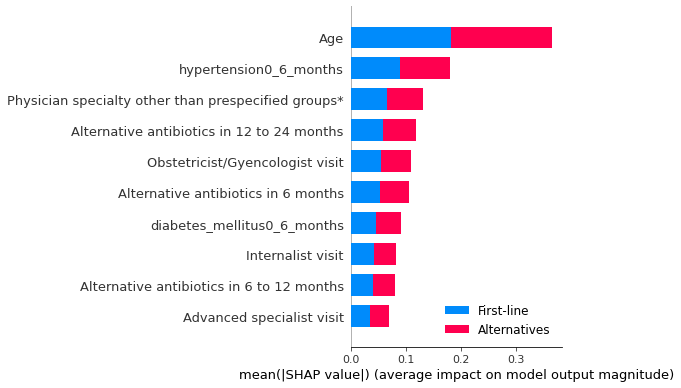

In [56]:
import shap
lgbm = run_lgbm(feat_dict['treatment']['cohort_features'][0], outcome_dict['treatment'][treatment_name], add_propensity = True, params = best_A_params_cohort[treatment_name], search = False) 

cohort, clf = lgbm[0],lgbm[1]

cols = feat_dict['treatment']['cohort_features'][1]
replace_list = [\
     ('age', 'Age'),\
     ('specialty_emergency/acute_group', 'Emergency medicine visit'),\
     ('specialty_advanced_specialist_group', 'Advanced specialist visit'),\
     ('alternatives_12_to_24_mo','Alternative antibiotics in 12 to 24 months'),\
     ('specialty_family_medicine_group', 'Family medicine visit'),\
     ('alternatives_6_to_12_mo','Alternative antibiotics in 6 to 12 months'),\
     ('specialty_internal_medicine_group', 'Internalist visit'),\
     ('specialty_OBGYN_group', 'Obstetricist/Gyencologist visit'),\
     ('specialty_other_group', 'Physician specialty other than prespecified groups*'),\
     ('alternatives_0_to_6_mo','Alternative antibiotics in 6 months')]
for i in replace_list:
     cols = [s.replace(i[0], i[1]) for s in cols]
X_df =  pd.DataFrame(feat_dict['treatment']['cohort_features'][0].todense(),\
     columns = cols)
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_df)
shap.summary_plot(shap_values, X_df, plot_type='bar',max_display = 10, class_names = ['First-line','Alternatives'])

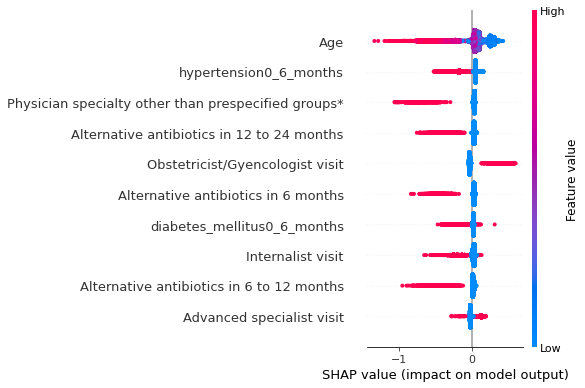

In [59]:
import shap
lgbm = run_lgbm(feat_dict['treatment']['cohort_features'][0], outcome_dict['treatment'][treatment_name], add_propensity = True, params = best_A_params_cohort[treatment_name], search = False) 

cohort, clf = lgbm[0],lgbm[1]

cols = feat_dict['treatment']['cohort_features'][1]
replace_list = [\
     ('age', 'Age'),\
     ('specialty_emergency/acute_group', 'Emergency medicine visit'),\
     ('specialty_advanced_specialist_group', 'Advanced specialist visit'),\
     ('alternatives_12_to_24_mo','Alternative antibiotics in 12 to 24 months'),\
     ('specialty_family_medicine_group', 'Family medicine visit'),\
     ('alternatives_6_to_12_mo','Alternative antibiotics in 6 to 12 months'),\
     ('specialty_internal_medicine_group', 'Internalist visit'),\
     ('specialty_OBGYN_group', 'Obstetricist/Gyencologist visit'),\
     ('specialty_other_group', 'Physician specialty other than prespecified groups*'),\
     ('alternatives_0_to_6_mo','Alternative antibiotics in 6 months')]
for i in replace_list:
     cols = [s.replace(i[0], i[1]) for s in cols]
X_df =  pd.DataFrame(feat_dict['treatment']['cohort_features'][0].todense(),\
     columns = cols)
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_df)
shap.summary_plot(shap_values[0], X_df, plot_type='dot',max_display = 10, class_names = ['First-line','Alternatives'])

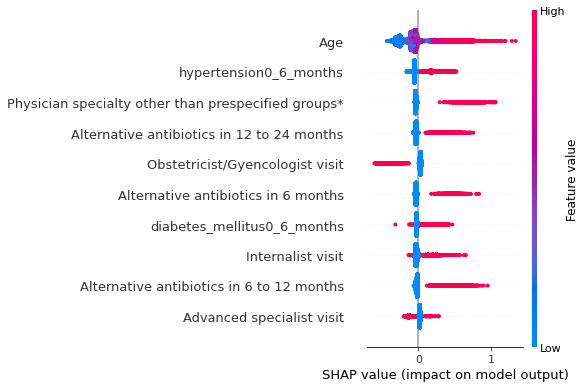

In [58]:
import shap
lgbm = run_lgbm(feat_dict['treatment']['cohort_features'][0], outcome_dict['treatment'][treatment_name], add_propensity = True, params = best_A_params_cohort[treatment_name], search = False) 

cohort, clf = lgbm[0],lgbm[1]

cols = feat_dict['treatment']['cohort_features'][1]
replace_list = [\
     ('age', 'Age'),\
     ('specialty_emergency/acute_group', 'Emergency medicine visit'),\
     ('specialty_advanced_specialist_group', 'Advanced specialist visit'),\
     ('alternatives_12_to_24_mo','Alternative antibiotics in 12 to 24 months'),\
     ('specialty_family_medicine_group', 'Family medicine visit'),\
     ('alternatives_6_to_12_mo','Alternative antibiotics in 6 to 12 months'),\
     ('specialty_internal_medicine_group', 'Internalist visit'),\
     ('specialty_OBGYN_group', 'Obstetricist/Gyencologist visit'),\
     ('specialty_other_group', 'Physician specialty other than prespecified groups*'),\
     ('alternatives_0_to_6_mo','Alternative antibiotics in 6 months')]
for i in replace_list:
     cols = [s.replace(i[0], i[1]) for s in cols]
X_df =  pd.DataFrame(feat_dict['treatment']['cohort_features'][0].todense(),\
     columns = cols)
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_df)
shap.summary_plot(shap_values[1], X_df, plot_type='dot',max_display = 10, class_names = ['First-line','Alternatives'])

In [ ]:
import shap
lgbm = run_logreg(feat_dict['treatment']['cohort_features'][0], outcome_dict['treatment'][treatment_name], add_propensity = True, params = best_A_params_cohort[treatment_name], search = False) 

cohort, clf = lgbm[0],lgbm[1]

cols = feat_dict['treatment']['cohort_features'][1]
replace_list = [\
     ('age', 'Age'),\
     ('specialty_emergency/acute_group', 'Emergency medicine visit'),\
     ('specialty_advanced_specialist_group', 'Advanced specialist visit'),\
     ('alternatives_12_to_24_mo','Alternative antibiotics in 12 to 24 months'),\
     ('specialty_family_medicine_group', 'Family medicine visit'),\
     ('alternatives_6_to_12_mo','Alternative antibiotics in 6 to 12 months'),\
     ('specialty_internal_medicine_group', 'Internalist visit'),\
     ('specialty_OBGYN_group', 'Obstetricist/Gyencologist visit'),\
     ('specialty_other_group', 'Physician specialty other than prespecified groups*'),\
     ('alternatives_0_to_6_mo','Alternative antibiotics in 6 months')]
for i in replace_list:
     cols = [s.replace(i[0], i[1]) for s in cols]
X_df =  pd.DataFrame(feat_dict['treatment']['cohort_features'][0].todense(),\
     columns = cols)
explainer = shap.LinearExplainer(clf,X_df)
shap_values = explainer.shap_values(X_df)
shap.summary_plot(shap_values, X_df, plot_type='bar',max_display = 10, class_names = ['First-line','Alternatives'])

In [65]:
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 1.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 761.5 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.0/215.0 kB 2.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 14.5 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 814.2/814.2 kB 9.2 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.9 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.1/386.1 kB 3.4 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 8.4 MB/s eta 0:00:000:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 690.5 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.7/103.7 kB 1.1 MB/s eta 0:00:0000:01
  Using cached ptyprocess-0.7.0-py2.py3-none-any.whl (13 kB)
Enabling notebook extension jupyter-js-widgets/extension...
      -

In [19]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [25]:
treatment_name

'alternatives'

In [37]:
from ipywidgets import IProgress

ImportError: cannot import name 'IProgress' from 'ipywidgets' (/home/ncjones/miniconda3/envs/omop/lib/python3.8/site-packages/ipywidgets/__init__.py)

In [32]:
%jupyter nbextension enable --py widgetsnbextension

UsageError: Line magic function `%jupyter` not found.


In [30]:
best_A_params_cohort[treatment_name]

{'C': 0.5,
 'penalty': 'l1',
 'clf': LogisticRegression(),
 'solver': 'liblinear',
 'verbose': -1}

In [81]:
import shap
test_lgbm = run_logreg(feat_dict['treatment']['cohort_features'][0], outcome_dict['treatment'][treatment_name], add_propensity = True, params = best_A_params_cohort[treatment_name], search = False) 

test_cohort, test_clf = test_lgbm[0],test_lgbm[1]

cols = feat_dict['treatment']['cohort_features'][1]
replace_list = [\
     ('age', 'Age'),\
     ('specialty_emergency/acute_group', 'Emergency medicine visit'),\
     ('specialty_advanced_specialist_group', 'Advanced specialist visit'),\
     ('alternatives_12_to_24_mo','Alternative antibiotics in 12 to 24 months'),\
     ('specialty_family_medicine_group', 'Family medicine visit'),\
     ('alternatives_6_to_12_mo','Alternative antibiotics in 6 to 12 months'),\
     ('specialty_internal_medicine_group', 'Internalist visit'),\
     ('specialty_OBGYN_group', 'Obstetricist/Gyencologist visit'),\
     ('specialty_other_group', 'Physician specialty other than prespecified groups*'),\
     ('alternatives_0_to_6_mo','Alternative antibiotics in 6 months')]
for i in replace_list:
     cols = [s.replace(i[0], i[1]) for s in cols]
test_X_df =  pd.DataFrame(feat_dict['treatment']['cohort_features'][0].todense(),\
     columns = cols)
test_explainer = shap.KernelExplainer(clf.predict_proba,shap.sample(test_X_df,100))
test_shap_values = test_explainer.shap_values(shap.sample(test_X_df,100))

  0%|          | 0/100 [00:00<?, ?it/s]

In [87]:
test_shap_values

AttributeError: 'list' object has no attribute 'shape'

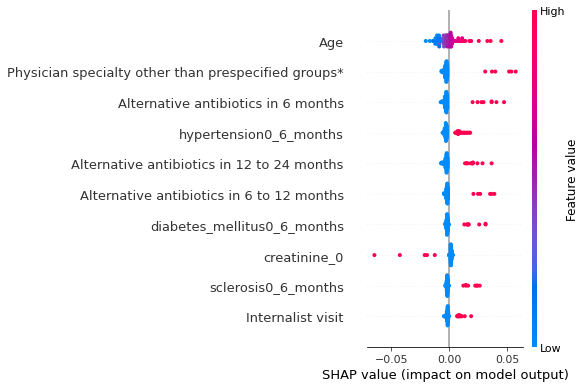

In [83]:
shap.summary_plot(test_shap_values[1], shap.sample(test_X_df,100), plot_type='dot',max_display = 10, class_names = ['First-line','Alternatives'])

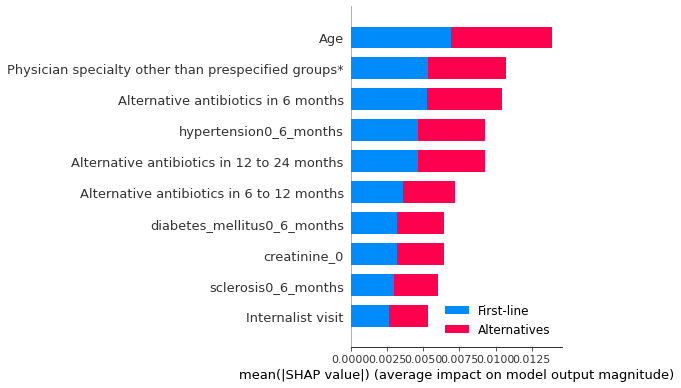

In [88]:
shap.summary_plot(test_shap_values, shap.sample(test_X_df,100), plot_type='bar',max_display = 10, class_names = ['First-line','Alternatives'])

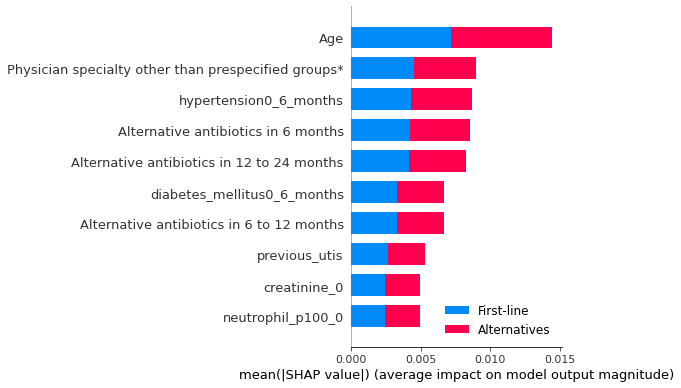

In [92]:
shap.summary_plot(list_shap_values, X_df, plot_type='bar',max_display = 10, class_names = ['First-line','Alternatives'])

In [91]:
list_shap_values = [shap_values[:,:,0],shap_values[:,:,1]]

In [ ]:
import shap
lgbm = run_logreg(feat_dict['treatment']['cohort_features'][0], outcome_dict['treatment'][treatment_name], add_propensity = True, params = best_A_params_cohort[treatment_name], search = False) 

cohort, clf = lgbm[0],lgbm[1]

cols = feat_dict['treatment']['cohort_features'][1]
replace_list = [\
     ('age', 'Age'),\
     ('specialty_emergency/acute_group', 'Emergency medicine visit'),\
     ('specialty_advanced_specialist_group', 'Advanced specialist visit'),\
     ('alternatives_12_to_24_mo','Alternative antibiotics in 12 to 24 months'),\
     ('specialty_family_medicine_group', 'Family medicine visit'),\
     ('alternatives_6_to_12_mo','Alternative antibiotics in 6 to 12 months'),\
     ('specialty_internal_medicine_group', 'Internalist visit'),\
     ('specialty_OBGYN_group', 'Obstetricist/Gyencologist visit'),\
     ('specialty_other_group', 'Physician specialty other than prespecified groups*'),\
     ('alternatives_0_to_6_mo','Alternative antibiotics in 6 months')]
for i in replace_list:
     cols = [s.replace(i[0], i[1]) for s in cols]
X_df =  pd.DataFrame(feat_dict['treatment']['cohort_features'][0].todense(),\
     columns = cols)
explainer = shap.PermutationExplainer(clf.predict_proba,X_df)
shap_values = explainer.shap_values(X_df)

PermutationExplainer explainer:   0%|          | 180/36445 [01:23<4:44:49,  2.12it/s]

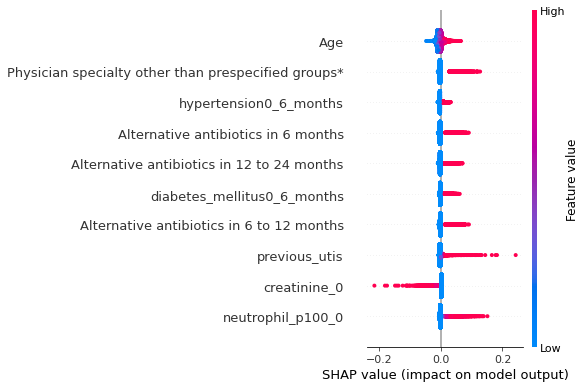

In [68]:
cols = feat_dict['treatment']['cohort_features'][1]
replace_list = [\
     ('age', 'Age'),\
     ('specialty_emergency/acute_group', 'Emergency medicine visit'),\
     ('specialty_advanced_specialist_group', 'Advanced specialist visit'),\
     ('alternatives_12_to_24_mo','Alternative antibiotics in 12 to 24 months'),\
     ('specialty_family_medicine_group', 'Family medicine visit'),\
     ('alternatives_6_to_12_mo','Alternative antibiotics in 6 to 12 months'),\
     ('specialty_internal_medicine_group', 'Internalist visit'),\
     ('specialty_OBGYN_group', 'Obstetricist/Gyencologist visit'),\
     ('specialty_other_group', 'Physician specialty other than prespecified groups*'),\
     ('alternatives_0_to_6_mo','Alternative antibiotics in 6 months')]
for i in replace_list:
     cols = [s.replace(i[0], i[1]) for s in cols]
X_df =  pd.DataFrame(feat_dict['treatment']['cohort_features'][0].todense(),\
     columns = cols)
shap.summary_plot(shap_values[:,:,1], X_df, plot_type='dot',max_display = 10, class_names = ['First-line','Alternatives'])

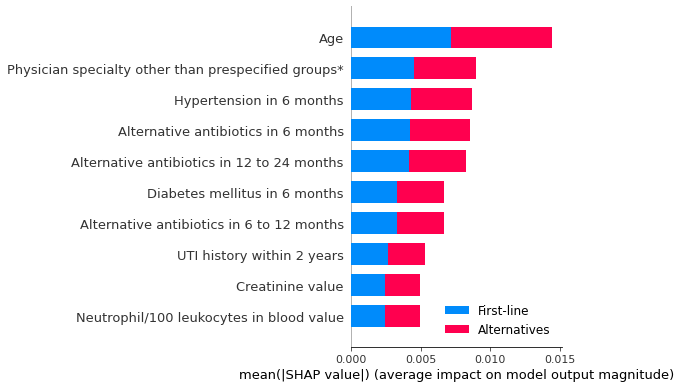

In [96]:
cols = feat_dict['treatment']['cohort_features'][1]
replace_list = [\
     ('age', 'Age'),\
     ('specialty_emergency/acute_group', 'Emergency medicine visit'),\
     ('specialty_advanced_specialist_group', 'Advanced specialist visit'),\
     ('alternatives_12_to_24_mo','Alternative antibiotics in 12 to 24 months'),\
     ('specialty_family_medicine_group', 'Family medicine visit'),\
     ('alternatives_6_to_12_mo','Alternative antibiotics in 6 to 12 months'),\
     ('specialty_internal_medicine_group', 'Internalist visit'),\
     ('specialty_OBGYN_group', 'Obstetricist/Gyencologist visit'),\
     ('specialty_other_group', 'Physician specialty other than prespecified groups*'),\
     ('alternatives_0_to_6_mo','Alternative antibiotics in 6 months'),\
     ('years_since_diagnosis', 'Prescription year'),\
     ('age', 'Age'),\
     ('specialty_advanced_specialist_group', 'Advanced specialist visit'),\
     ('second_line_12_to_24_mo','Second-line antibiotics in 12 to 24 months'),\
     ('nitrofurantoin_12_to_24_mo','Nitrofurantoin in 12 to 24 months'),\
     ('specialty_internal_medicine_group', 'Internalist visit'),\
     ('second_line_6_to_12_mo','Second-line antibiotics in 6 to 12 months'),\
     ('urine_test_present', 'Urine test ordered'),\
     ('specialty_OBGYN_group', 'Obstetricist/Gyencologist visit'),\
     ('second_line_most_recent', 'Most recent antibiotic is second-line'),\
     ('specialty_emergency/acute_group', 'Emergency medicine visit'),\
     ('days_since_previous_uti', 'Days since previous UTI'),\
     ('age', 'Age'),\
     ('previous_utis', 'UTI history within 2 years'),\
     ('specialty_emergency/acute_group', 'Emergency medicine visit'),\
     ('trimethoprim-sulfamethoxazole_most_recent', 'Most recent antibiotic is TMP-SMX'),\
     ('specialty_family_medicine_group', 'Family medicine visit'),\
     ('ph_urine_0', 'Urine pH value'),\
     ('creatinine_0', 'Creatinine value'),\
     ('neutrophil_p100_0', 'Neutrophil/100 leukocytes in blood value'),\
    ('diabetes_mellitus0_6_months','Diabetes mellitus in 6 months'),\
    ('hypertension0_6_months','Hypertension in 6 months'),\
     ('urine_test_present', 'Urine test ordered'),\
     ('years_since_diagnosis', 'Prescription year'),\
     ('treatment_','Alternative antibiotics prescribed'),\
               ]
for i in replace_list:
     cols = [s.replace(i[0], i[1]) for s in cols]
X_df =  pd.DataFrame(feat_dict['treatment']['cohort_features'][0].todense(),\
     columns = cols)
shap.summary_plot(list_shap_values, X_df, plot_type='bar',max_display = 10, class_names = ['First-line','Alternatives'])

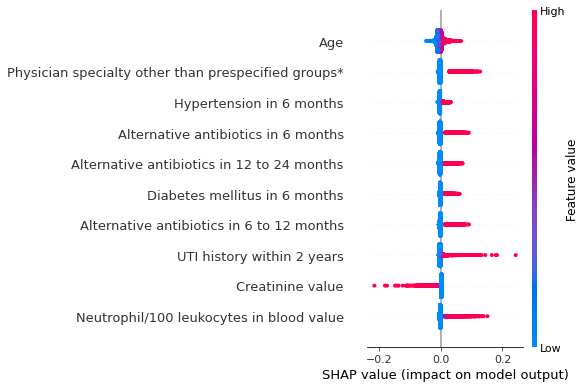

In [101]:
replace_list = [\
     ('age', 'Age'),\
     ('specialty_emergency/acute_group', 'Emergency medicine visit'),\
     ('specialty_advanced_specialist_group', 'Advanced specialist visit'),\
     ('alternatives_12_to_24_mo','Alternative antibiotics in 12 to 24 months'),\
     ('specialty_family_medicine_group', 'Family medicine visit'),\
     ('alternatives_6_to_12_mo','Alternative antibiotics in 6 to 12 months'),\
     ('specialty_internal_medicine_group', 'Internalist visit'),\
     ('specialty_OBGYN_group', 'Obstetricist/Gyencologist visit'),\
     ('specialty_other_group', 'Physician specialty other than prespecified groups*'),\
     ('alternatives_0_to_6_mo','Alternative antibiotics in 6 months'),\
     ('years_since_diagnosis', 'Prescription year'),\
     ('age', 'Age'),\
     ('specialty_advanced_specialist_group', 'Advanced specialist visit'),\
     ('second_line_12_to_24_mo','Second-line antibiotics in 12 to 24 months'),\
     ('nitrofurantoin_12_to_24_mo','Nitrofurantoin in 12 to 24 months'),\
     ('specialty_internal_medicine_group', 'Internalist visit'),\
     ('second_line_6_to_12_mo','Second-line antibiotics in 6 to 12 months'),\
     ('urine_test_present', 'Urine test ordered'),\
     ('specialty_OBGYN_group', 'Obstetricist/Gyencologist visit'),\
     ('second_line_most_recent', 'Most recent antibiotic is second-line'),\
     ('specialty_emergency/acute_group', 'Emergency medicine visit'),\
     ('days_since_previous_uti', 'Days since previous UTI'),\
     ('age', 'Age'),\
     ('previous_utis', 'UTI history within 2 years'),\
     ('specialty_emergency/acute_group', 'Emergency medicine visit'),\
     ('trimethoprim-sulfamethoxazole_most_recent', 'Most recent antibiotic is TMP-SMX'),\
     ('specialty_family_medicine_group', 'Family medicine visit'),\
     ('ph_urine_0', 'Urine pH value'),\
     ('creatinine_0', 'Creatinine value'),\
     ('neutrophil_p100_0', 'Neutrophil/100 leukocytes in blood value'),\
    ('diabetes_mellitus0_6_months','Diabetes mellitus in 6 months'),\
    ('hypertension0_6_months','Hypertension in 6 months'),\
     ('urine_test_present', 'Urine test ordered'),\
     ('years_since_diagnosis', 'Prescription year'),\
     ('treatment_','Alternative antibiotics prescribed'),\
               ]
for i in replace_list:
     cols = [s.replace(i[0], i[1]) for s in cols]
X_df =  pd.DataFrame(feat_dict['treatment']['cohort_features'][0].todense(),\
     columns = cols)
shap.summary_plot(shap_values[:,:,1], X_df, plot_type='dot',max_display = 10, class_names = ['First-line','Alternatives'])

  0%|          | 0/100 [00:00<?, ?it/s]

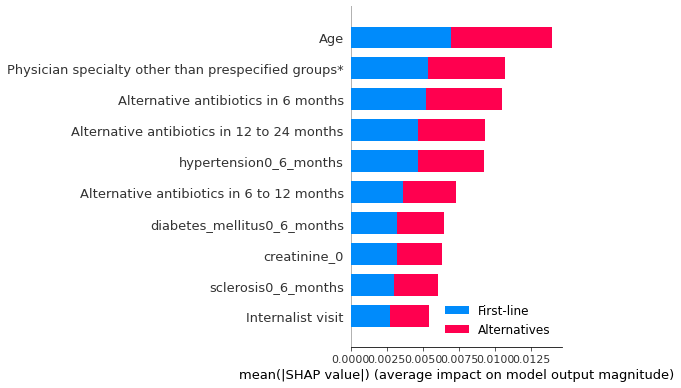

In [39]:
import shap
lgbm = run_logreg(feat_dict['treatment']['cohort_features'][0], outcome_dict['treatment'][treatment_name], add_propensity = True, params = best_A_params_cohort[treatment_name], search = False) 

cohort, clf = lgbm[0],lgbm[1]

cols = feat_dict['treatment']['cohort_features'][1]
replace_list = [\
     ('age', 'Age'),\
     ('specialty_emergency/acute_group', 'Emergency medicine visit'),\
     ('specialty_advanced_specialist_group', 'Advanced specialist visit'),\
     ('alternatives_12_to_24_mo','Alternative antibiotics in 12 to 24 months'),\
     ('specialty_family_medicine_group', 'Family medicine visit'),\
     ('alternatives_6_to_12_mo','Alternative antibiotics in 6 to 12 months'),\
     ('specialty_internal_medicine_group', 'Internalist visit'),\
     ('specialty_OBGYN_group', 'Obstetricist/Gyencologist visit'),\
     ('specialty_other_group', 'Physician specialty other than prespecified groups*'),\
     ('alternatives_0_to_6_mo','Alternative antibiotics in 6 months')]
for i in replace_list:
     cols = [s.replace(i[0], i[1]) for s in cols]
X_df =  pd.DataFrame(feat_dict['treatment']['cohort_features'][0].todense(),\
     columns = cols)
explainer = shap.KernelExplainer(clf.predict_proba,shap.sample(X_df,100))
shap_values = explainer.shap_values(shap.sample(X_df,100))
shap.summary_plot(shap_values, shap.sample(X_df,100), plot_type='bar',max_display = 10, class_names = ['First-line','Alternatives'])

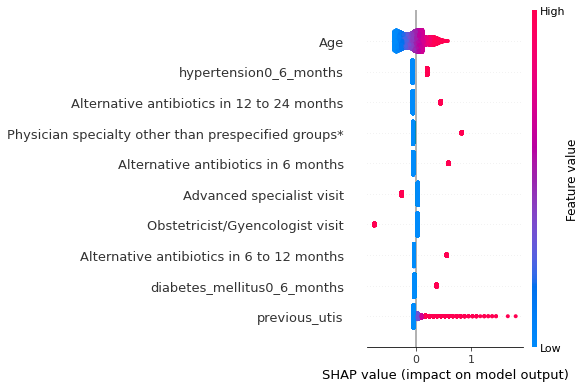

In [52]:
import shap
lgbm = run_logreg(feat_dict['treatment']['cohort_features'][0], outcome_dict['treatment'][treatment_name], add_propensity = True, params = best_A_params_cohort[treatment_name], search = False) 

cohort, clf = lgbm[0],lgbm[1]

cols = feat_dict['treatment']['cohort_features'][1]
replace_list = [\
     ('age', 'Age'),\
     ('specialty_emergency/acute_group', 'Emergency medicine visit'),\
     ('specialty_advanced_specialist_group', 'Advanced specialist visit'),\
     ('alternatives_12_to_24_mo','Alternative antibiotics in 12 to 24 months'),\
     ('specialty_family_medicine_group', 'Family medicine visit'),\
     ('alternatives_6_to_12_mo','Alternative antibiotics in 6 to 12 months'),\
     ('specialty_internal_medicine_group', 'Internalist visit'),\
     ('specialty_OBGYN_group', 'Obstetricist/Gyencologist visit'),\
     ('specialty_other_group', 'Physician specialty other than prespecified groups*'),\
     ('alternatives_0_to_6_mo','Alternative antibiotics in 6 months')]
for i in replace_list:
     cols = [s.replace(i[0], i[1]) for s in cols]
X_df =  pd.DataFrame(feat_dict['treatment']['cohort_features'][0].todense(),\
     columns = cols)
explainer = shap.LinearExplainer(clf,X_df)
shap_values = explainer.shap_values(X_df)
shap.summary_plot(shap_values, X_df,max_display = 10, class_names = ['First-line','Alternatives'])

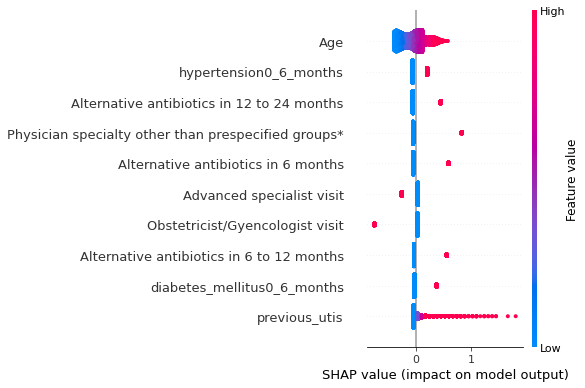

In [49]:
import shap
lgbm = run_logreg(feat_dict['treatment']['cohort_features'][0], outcome_dict['treatment'][treatment_name], add_propensity = True, params = best_A_params_cohort[treatment_name], search = False) 

cohort, clf = lgbm[0],lgbm[1]

cols = feat_dict['treatment']['cohort_features'][1]
replace_list = [\
     ('age', 'Age'),\
     ('specialty_emergency/acute_group', 'Emergency medicine visit'),\
     ('specialty_advanced_specialist_group', 'Advanced specialist visit'),\
     ('alternatives_12_to_24_mo','Alternative antibiotics in 12 to 24 months'),\
     ('specialty_family_medicine_group', 'Family medicine visit'),\
     ('alternatives_6_to_12_mo','Alternative antibiotics in 6 to 12 months'),\
     ('specialty_internal_medicine_group', 'Internalist visit'),\
     ('specialty_OBGYN_group', 'Obstetricist/Gyencologist visit'),\
     ('specialty_other_group', 'Physician specialty other than prespecified groups*'),\
     ('alternatives_0_to_6_mo','Alternative antibiotics in 6 months')]
for i in replace_list:
     cols = [s.replace(i[0], i[1]) for s in cols]
X_df =  pd.DataFrame(feat_dict['treatment']['cohort_features'][0].todense(),\
     columns = cols)
explainer = shap.LinearExplainer(clf,X_df)
shap_values = explainer.shap_values(X_df)
shap.summary_plot(shap_values, X_df, max_display = 10, class_names = ['First-line','Alternatives'])

In [12]:
%%time
import shap
shap.initjs()
lgbm = run_lgbm(feat_dict['treatment']['cohort_features'][0], outcome_dict['treatment'][treatment_name], add_propensity = True, params = best_D_params_cohort[treatment_name]['30'], search = False) 

cohort, clf = lgbm[0],lgbm[1]
explainer = shap.TreeExplainer(clf)
cols = feat_dict['treatment']['cohort_features'][1]
replace_list = [\
     ('age', 'Age'),\
     ('specialty_emergency/acute_group', 'Emergency medicine visit'),\
     ('specialty_advanced_specialist_group', 'Advanced specialist visit'),\
     ('alternatives_12_to_24_mo','Alternative antibiotics in 12 to 24 months'),\
     ('specialty_family_medicine_group', 'Family medicine visit'),\
     ('alternatives_6_to_12_mo','Alternative antibiotics in 6 to 12 months'),\
     ('specialty_internal_medicine_group', 'Internalist visit'),\
     ('specialty_OBGYN_group', 'Obstetricist/Gyencologist visit'),\
     ('specialty_other_group', 'Physician specialty other than prespecified groups*'),\
     ('alternatives_0_to_6_mo','Alternative antibiotics in 6 months')]
for i in replace_list:
     cols = [s.replace(i[0], i[1]) for s in cols]
X_df =  pd.DataFrame(feat_dict['treatment']['cohort_features'][0].todense(),\
     columns = cols)
shap_values = explainer.shap_values(X_df)
shap.summary_plot(shap_values, X_df, max_display = 10, class_names = ['First-line','Alternatives'])

NameError: name 'run_lgbm' is not defined

## old shapley plots

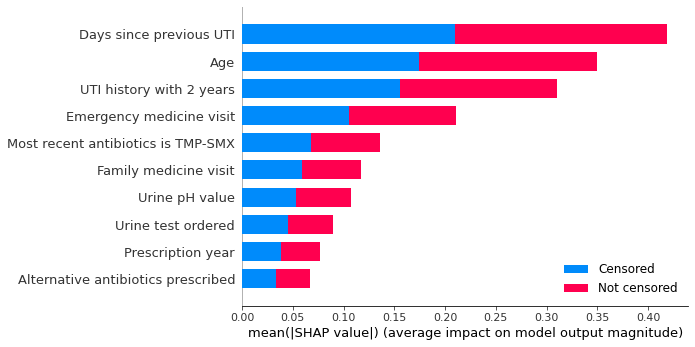

CPU times: user 22.8 s, sys: 796 ms, total: 23.6 s
Wall time: 2.34 s


In [18]:
%%time
lgbm = run_lgbm(feat_dict['censor']['cohort_features'][0], outcome_dict['censor']['30'], add_propensity = True, params = best_D_params_cohort[treatment_name]['30'], search = False) 

cohort, clf = lgbm[0],lgbm[1]
explainer = shap.TreeExplainer(clf)
cols = feat_dict['censor']['cohort_features'][1]
replace_list = [\
     ('days_since_previous_uti', 'Days since previous UTI'),\
     ('age', 'Age'),\
     ('previous_utis', 'UTI history with 2 years'),\
     ('specialty_emergency/acute_group', 'Emergency medicine visit'),\
     ('trimethoprim-sulfamethoxazole_most_recent', 'Most recent antibiotics is TMP-SMX'),\
     ('specialty_family_medicine_group', 'Family medicine visit'),\
     ('ph_urine_0', 'Urine pH value'),\
     ('urine_test_present', 'Urine test ordered'),\
     ('years_since_diagnosis', 'Prescription year'),\
     ('treatment_','Alternative antibiotics prescribed')]
for i in replace_list:
     cols = [s.replace(i[0], i[1]) for s in cols]
X_df =  pd.DataFrame(feat_dict['censor']['cohort_features'][0].todense(),\
     columns = cols)
shap_values = explainer.shap_values(X_df)
shap.summary_plot(shap_values, X_df, max_display = 10, class_names = ['Censored','Not censored'])

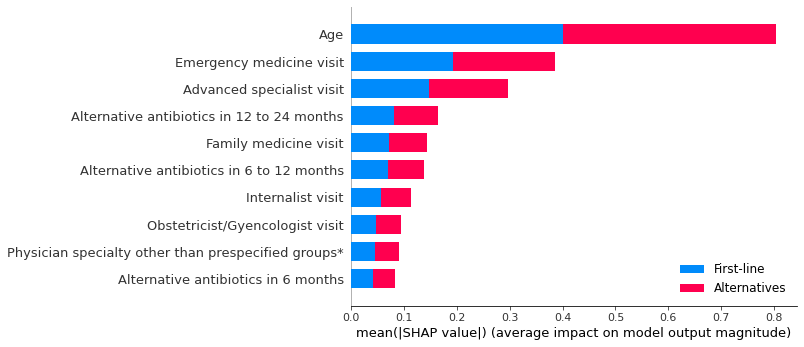

CPU times: user 31 s, sys: 976 ms, total: 32 s
Wall time: 2.78 s


In [21]:
%%time
lgbm = run_lgbm(feat_dict['treatment']['cohort_features'][0], outcome_dict['treatment'][treatment_name], add_propensity = True, params = best_D_params_cohort[treatment_name]['30'], search = False) 

cohort, clf = lgbm[0],lgbm[1]
explainer = shap.TreeExplainer(clf)
cols = feat_dict['treatment']['cohort_features'][1]
replace_list = [\
     ('age', 'Age'),\
     ('specialty_emergency/acute_group', 'Emergency medicine visit'),\
     ('specialty_advanced_specialist_group', 'Advanced specialist visit'),\
     ('alternatives_12_to_24_mo','Alternative antibiotics in 12 to 24 months'),\
     ('specialty_family_medicine_group', 'Family medicine visit'),\
     ('alternatives_6_to_12_mo','Alternative antibiotics in 6 to 12 months'),\
     ('specialty_internal_medicine_group', 'Internalist visit'),\
     ('specialty_OBGYN_group', 'Obstetricist/Gyencologist visit'),\
     ('specialty_other_group', 'Physician specialty other than prespecified groups*'),\
     ('alternatives_0_to_6_mo','Alternative antibiotics in 6 months')]
for i in replace_list:
     cols = [s.replace(i[0], i[1]) for s in cols]
X_df =  pd.DataFrame(feat_dict['treatment']['cohort_features'][0].todense(),\
     columns = cols)
shap_values = explainer.shap_values(X_df)
shap.summary_plot(shap_values, X_df, max_display = 10, class_names = ['First-line','Alternatives'])

## Calibration plots

In [118]:
cohort.propensity_score.max()

0.975

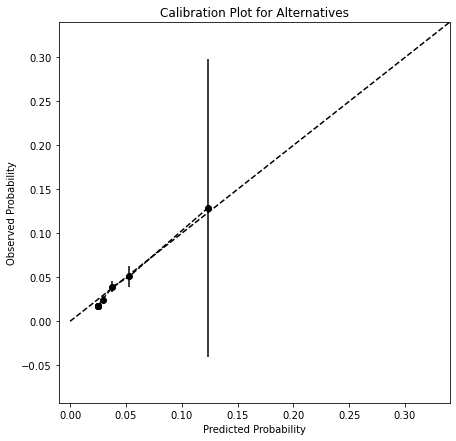

In [114]:
y_pred_column = 'propensity_score'
y_column = 'treatment'
condition_name = 'Alternatives'


def calibration(cohort,y_pred,y_col,title=None,lim=None,cond_name=None,name=None,show=False):
    '''
    Input: cohort with a propensity column named propensity_score and antibiotic type column
           treatment name
    
    return plot'''
   
    bins = [np.quantile(cohort[y_pred], x/8) for x in range(9)]
    df_cali = pd.DataFrame(columns=['pred', 'actual', 'errorbar'])
    for i in range(8):
        temp = cohort[(cohort[y_pred]>=bins[i]) & (cohort[y_pred]<=bins[i+1])]
        x = np.mean(temp[y_pred])
        y = len(temp[temp[y_col]==1])/len(temp)
        std = np.std(temp[y_pred])
        df_cali.loc[len(df_cali)] = [x,y,1.96*std]

    fig = plt.figure(figsize=(7,7))
    # plt.plot(df_cali.pred, df_cali.actual, '-o')
    plt.errorbar(df_cali.pred, df_cali.actual, yerr=df_cali.errorbar, fmt='o', ls='--',color='black')
    plt.plot([0, 1], [0, 1], ls='--',color='black')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Observed Probability')
    if lim is not None:
        plt.xlim(-0.01,lim)
        plt.ylim(None,lim)
        
    if cond_name is None:
        plt.title('Calibration Plot for '+treatment)
    else:
        plt.title('Calibration Plot for '+cond_name)
    if name:
        plt.savefig(name)
    if not show:
        plt.close(fig)
    return fig


calibration(cohort,y_pred=y_pred_column,y_col=y_column,cond_name=condition_name,lim=0.34)

In [301]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from scipy.stats import norm
y_pred_column = 'propensity_score'
y_column = 'treatment'
condition_name = 'Alternatives'
X_Train,T_Train,X_Test, T_Test = train_test_split(cohort, cohort[y_column], test_size = 0.2, random_state = 0)
run_logreg()
reduced_cohort = cohort.iloc[T_Test.index]

# Generate the calibration data
true_prob, pred_prob = calibration_curve(reduced_cohort[y_column], reduced_cohort[y_pred_column], n_bins=10, strategy='uniform')

# Calculate bin sizes
bin_sizes = np.histogram(reduced_cohort[y_pred_column], bins=10, range=(0, 1))[0]

# # Calculate standard error for the binomial proportion in each bin
# se = np.sqrt(true_prob * (1 - true_prob) / bin_sizes)

# # Calculate the z-value for the 95% confidence interval
# z = norm.ppf(0.975)  # Two-tailed, hence 0.975 instead of 0.95

# # Calculate the confidence intervals
# ci_lower = true_prob - z * se
# ci_upper = true_prob + z * se

# Plotting the calibration curve with error bars
plt.figure(figsize=(8, 6))
plt.errorbar(pred_prob, true_prob, fmt='o--', color='black', label='Calibration plot w/ 95% CI')
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Perfect calibration')
plt.xlabel('Predicted probability')
plt.ylabel('Observed Probability')
plt.title(f'Calibration Plot for {condition_name}')
plt.legend()
plt.show()

TypeError: run_logreg() missing 2 required positional arguments: 'matrix' and 'y'

### Alternatives

Test AUROC is: 0.7037166731792359


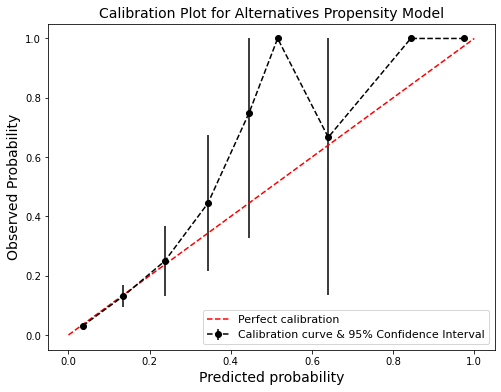

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from scipy.stats import norm
y_pred_column = 'propensity_score'
y_column = 'treatment'

logreg = run_logreg(feat_dict['treatment']['cohort_features'][0], outcome_dict['treatment'][treatment_name], add_propensity = True, params = best_A_params_cohort[treatment_name], search = False) 

cohort, clf = logreg[0],logreg[1]
print(f"Test AUROC is: {logreg[4][1]}")
def get_se(true_prob,bin_sizes):
    
    updated_true_prob = true_prob
    for idx in np.where(bin_sizes == 0)[0]:
        updated_true_prob = np.insert(updated_true_prob, idx, np.nan)
    se = np.sqrt(updated_true_prob * (1 - updated_true_prob) / bin_sizes)
    se = se[~np.isnan(se)]
    return se

_,_,_, T_Test = train_test_split(cohort, cohort[y_column], test_size = 0.2, random_state = 0)
reduced_cohort = cohort.iloc[T_Test.index]

# Generate the calibration data
true_prob, pred_prob = calibration_curve(reduced_cohort[y_column], reduced_cohort[y_pred_column], n_bins=10, strategy='uniform')

# Calculate bin sizes
bin_sizes = np.histogram(reduced_cohort[y_pred_column], bins=10, range=(0, 1))[0]

# Calculate standard error for the binomial proportion in each bin
se = get_se(true_prob,bin_sizes)

# Calculate the z-value for the 95% confidence interval
z = norm.ppf(0.975)  # Two-tailed, hence 0.975 instead of 0.95

# Calculate the confidence intervals
ci_lower = true_prob - z * se
upper = (true_prob + z * se)
upper[np.argwhere(true_prob+z*se > 1)] = 1
y_err = [z*se,(upper -true_prob)]
# Plotting the calibration curve with error bars
plt.figure(figsize=(8, 6))
plt.errorbar(pred_prob, true_prob, yerr=y_err,fmt='o--', color='black', label='Calibration curve & 95% Confidence Interval')
# plt.fill_between(pred_prob, (true_prob - z*se), upper, color='b', alpha=.1)
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Perfect calibration')
plt.xlabel('Predicted probability',fontsize=14)
plt.ylabel('Observed Probability',fontsize=14)
plt.title(f'Calibration Plot for {treatment} Propensity Model',fontsize=14)
plt.legend(fontsize=11)
plt.show()

### Censor 15

Test AUROC is: 0.641404228634631


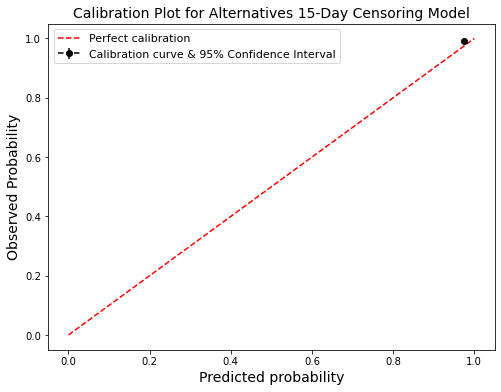

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from scipy.stats import norm
y_pred_column = 'propensity_score'
y_column = 'treatment'
condition_name = '15-Day Censoring'

rf = run_rf(feat_dict['censor']['cohort_features'][0], outcome_dict['censor']['15'], add_propensity = True, params = best_D_params_cohort[treatment_name]['15'], search = False) 

cohort, clf = rf[0],rf[1]
print(f"Test AUROC is: {rf[4][1]}")
def get_se(true_prob,bin_sizes):
    
    updated_true_prob = true_prob
    for idx in np.where(bin_sizes == 0)[0]:
        updated_true_prob = np.insert(updated_true_prob, idx, np.nan)
    se = np.sqrt(updated_true_prob * (1 - updated_true_prob) / bin_sizes)
    se = se[~np.isnan(se)]
    return se

_,_,_, T_Test = train_test_split(cohort, cohort[y_column], test_size = 0.2, random_state = 0)
reduced_cohort = cohort.iloc[T_Test.index]

# Generate the calibration data
true_prob, pred_prob = calibration_curve(reduced_cohort[y_column], reduced_cohort[y_pred_column], n_bins=10, strategy='uniform')

# Calculate bin sizes
bin_sizes = np.histogram(reduced_cohort[y_pred_column], bins=10, range=(0, 1))[0]

# Calculate standard error for the binomial proportion in each bin
se = get_se(true_prob,bin_sizes)

# Calculate the z-value for the 95% confidence interval
z = norm.ppf(0.975)  # Two-tailed, hence 0.975 instead of 0.95

# Calculate the confidence intervals
ci_lower = true_prob - z * se
upper = (true_prob + z * se)
upper[np.argwhere(true_prob+z*se > 1)] = 1
y_err = [z*se,(upper -true_prob)]
# Plotting the calibration curve with error bars
plt.figure(figsize=(8, 6))
plt.errorbar(pred_prob, true_prob, yerr=y_err,fmt='o--', color='black', label='Calibration curve & 95% Confidence Interval')
# plt.fill_between(pred_prob, (true_prob - z*se), upper, color='b', alpha=.1)
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Perfect calibration')
plt.xlabel('Predicted probability',fontsize=14)
plt.ylabel('Observed Probability',fontsize=14)
plt.title(f'Calibration Plot for {treatment} {condition_name} Model',fontsize=14)
plt.legend(fontsize=11)

plt.show()

### Censor 30

Test AUROC is: 0.6257639759241207


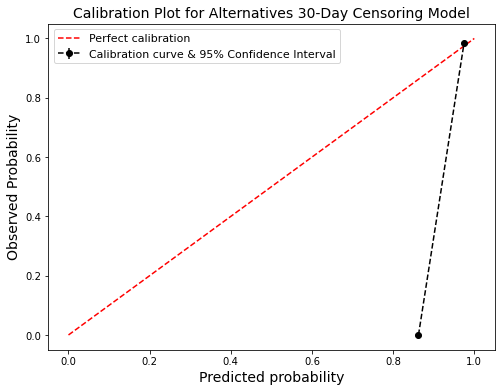

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from scipy.stats import norm
y_pred_column = 'propensity_score'
y_column = 'treatment'
condition_name = '30-Day Censoring'

lgbm = run_lgbm(feat_dict['censor']['cohort_features'][0], outcome_dict['censor']['30'], add_propensity = True, params = best_D_params_cohort[treatment_name]['30'], search = False) 

cohort, clf = lgbm[0],lgbm[1]
print(f"Test AUROC is: {lgbm[4][1]}")
def get_se(true_prob,bin_sizes):
    
    updated_true_prob = true_prob
    for idx in np.where(bin_sizes == 0)[0]:
        updated_true_prob = np.insert(updated_true_prob, idx, np.nan)
    se = np.sqrt(updated_true_prob * (1 - updated_true_prob) / bin_sizes)
    se = se[~np.isnan(se)]
    return se

_,_,_, T_Test = train_test_split(cohort, cohort[y_column], test_size = 0.2, random_state = 0)
reduced_cohort = cohort.iloc[T_Test.index]

# Generate the calibration data
true_prob, pred_prob = calibration_curve(reduced_cohort[y_column], reduced_cohort[y_pred_column], n_bins=10, strategy='uniform')

# Calculate bin sizes
bin_sizes = np.histogram(reduced_cohort[y_pred_column], bins=10, range=(0, 1))[0]

# Calculate standard error for the binomial proportion in each bin
se = get_se(true_prob,bin_sizes)

# Calculate the z-value for the 95% confidence interval
z = norm.ppf(0.975)  # Two-tailed, hence 0.975 instead of 0.95

# Calculate the confidence intervals
ci_lower = true_prob - z * se
upper = (true_prob + z * se)
upper[np.argwhere(true_prob+z*se > 1)] = 1
y_err = [z*se,(upper -true_prob)]
# Plotting the calibration curve with error bars
plt.figure(figsize=(8, 6))
plt.errorbar(pred_prob, true_prob, yerr=y_err,fmt='o--', color='black', label='Calibration curve & 95% Confidence Interval')
# plt.fill_between(pred_prob, (true_prob - z*se), upper, color='b', alpha=.1)
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Perfect calibration')
plt.xlabel('Predicted probability',fontsize=14)
plt.ylabel('Observed Probability',fontsize=14)
plt.title(f'Calibration Plot for {treatment} {condition_name} Model',fontsize=14)

plt.legend(fontsize=11)
plt.show()

### Censor 90

Test AUROC is: 0.6044267465386599


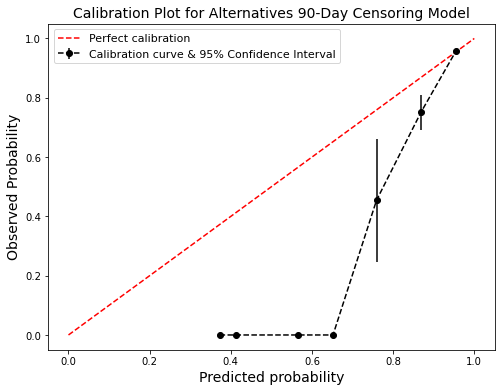

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from scipy.stats import norm
y_pred_column = 'propensity_score'
y_column = 'treatment'
condition_name = '90-Day Censoring'

lgbm = run_lgbm(feat_dict['censor']['cohort_features'][0], outcome_dict['censor']['90'], add_propensity = True, params = best_D_params_cohort[treatment_name]['90'], search = False) 

cohort, clf = lgbm[0],lgbm[1]
print(f"Test AUROC is: {lgbm[4][1]}")
def get_se(true_prob,bin_sizes):
    
    updated_true_prob = true_prob
    for idx in np.where(bin_sizes == 0)[0]:
        updated_true_prob = np.insert(updated_true_prob, idx, np.nan)
    se = np.sqrt(updated_true_prob * (1 - updated_true_prob) / bin_sizes)
    se = se[~np.isnan(se)]
    return se

_,_,_, T_Test = train_test_split(cohort, cohort[y_column], test_size = 0.2, random_state = 0)
reduced_cohort = cohort.iloc[T_Test.index]

# Generate the calibration data
true_prob, pred_prob = calibration_curve(reduced_cohort[y_column], reduced_cohort[y_pred_column], n_bins=10, strategy='uniform')

# Calculate bin sizes
bin_sizes = np.histogram(reduced_cohort[y_pred_column], bins=10, range=(0, 1))[0]

# Calculate standard error for the binomial proportion in each bin
se = get_se(true_prob,bin_sizes)

# Calculate the z-value for the 95% confidence interval
z = norm.ppf(0.975)  # Two-tailed, hence 0.975 instead of 0.95

# Calculate the confidence intervals
ci_lower = true_prob - z * se
upper = (true_prob + z * se)
upper[np.argwhere(true_prob+z*se > 1)] = 1
y_err = [z*se,(upper -true_prob)]
# Plotting the calibration curve with error bars
plt.figure(figsize=(8, 6))
plt.errorbar(pred_prob, true_prob, yerr=y_err,fmt='o--', color='black', label='Calibration curve & 95% Confidence Interval')
# plt.fill_between(pred_prob, (true_prob - z*se), upper, color='b', alpha=.1)
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Perfect calibration')
plt.xlabel('Predicted probability',fontsize=14)
plt.ylabel('Observed Probability',fontsize=14)
plt.title(f'Calibration Plot for {treatment} {condition_name} Model',fontsize=14)

plt.legend(fontsize=11)
plt.show()

In [206]:
outcome_dict['censor'].keys()

dict_keys(['15', '30', '90'])

In [210]:
best_D_params_cohort[treatment_name]

{'15': {'max_features': 'auto',
  'min_samples_leaf': 75,
  'n_estimators': 80,
  'clf': RandomForestClassifier()},
 '30': {'boosting_type': 'gbdt',
  'learning_rate': 0.01,
  'num_leaves': 10,
  'clf': LGBMClassifier(),
  'verbose': -1},
 '90': {'boosting_type': 'dart',
  'learning_rate': 0.1,
  'num_leaves': 10,
  'clf': LGBMClassifier(),
  'verbose': -1}}

In [306]:
indices = np.where(bin_sizes==0)[0]
for idx in indices:
    true_prob = np.insert(true_prob, idx, np.nan)

In [218]:
import shap
lgbm = run_lgbm(feat_dict['censor']['cohort_features'][0], outcome_dict['censor']['30'], add_propensity = True, params = best_D_params_cohort[treatment_name]['30'], search = False) 

cohort, clf = lgbm[0],lgbm[1]

# cols = feat_dict['treatment']['cohort_features'][1]
# replace_list = [\
#      ('age', 'Age'),\
#      ('specialty_emergency/acute_group', 'Emergency medicine visit'),\
#      ('specialty_advanced_specialist_group', 'Advanced specialist visit'),\
#      ('alternatives_12_to_24_mo','Alternative antibiotics in 12 to 24 months'),\
#      ('specialty_family_medicine_group', 'Family medicine visit'),\
#      ('alternatives_6_to_12_mo','Alternative antibiotics in 6 to 12 months'),\
#      ('specialty_internal_medicine_group', 'Internalist visit'),\
#      ('specialty_OBGYN_group', 'Obstetricist/Gyencologist visit'),\
#      ('specialty_other_group', 'Physician specialty other than prespecified groups*'),\
#      ('alternatives_0_to_6_mo','Alternative antibiotics in 6 months')]
# for i in replace_list:
#      cols = [s.replace(i[0], i[1]) for s in cols]
# X_df =  pd.DataFrame(feat_dict['treatment']['cohort_features'][0].todense(),\
#      columns = cols)
# explainer = shap.PermutationExplainer(clf.predict_proba,X_df)
# shap_values = explainer.shap_values(X_df)

In [217]:
cohort['less_15'] == 0

0        True
1        True
2        True
3        True
4        True
         ... 
36440    True
36441    True
36442    True
36443    True
36444    True
Name: less_15, Length: 36445, dtype: bool

In [221]:
true_prob

array([0.        , 0.98531833])

In [228]:
np.argwhere(bin_sizes==0).T[0]

array([0, 1, 2, 3, 4, 5, 6, 7])

In [242]:
bin_sizes

array([   0,    0,    0,    0,    0,    0,    0,    0,    1, 7288])

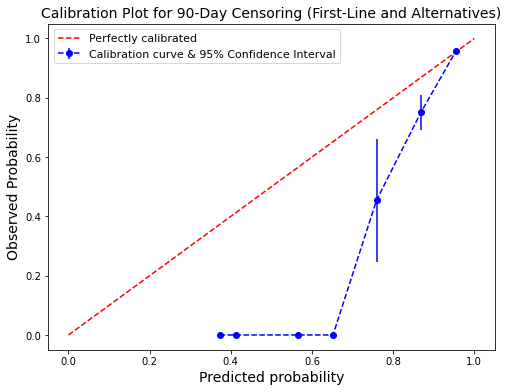

In [260]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from scipy.stats import norm
y_pred_column = 'propensity_score'
y_column = 'treatment'
condition_name = '90-Day Censoring (First-Line and Alternatives)'

lgbm = run_lgbm(feat_dict['censor']['cohort_features'][0], outcome_dict['censor']['90'], add_propensity = True, params = best_D_params_cohort[treatment_name]['90'], search = False) 

cohort, clf = lgbm[0],lgbm[1]

def get_se(true_prob,bin_sizes):
    
    updated_true_prob = true_prob
    for idx in np.where(bin_sizes == 0)[0]:
        updated_true_prob = np.insert(updated_true_prob, idx, np.nan)
    se = np.sqrt(updated_true_prob * (1 - updated_true_prob) / bin_sizes)
    se = se[~np.isnan(se)]
    return se

_,_,_, T_Test = train_test_split(cohort, cohort[y_column], test_size = 0.2, random_state = 0)
reduced_cohort = cohort.iloc[T_Test.index]

# Generate the calibration data
true_prob, pred_prob = calibration_curve(reduced_cohort[y_column], reduced_cohort[y_pred_column], n_bins=10, strategy='uniform')

# Calculate bin sizes
bin_sizes = np.histogram(reduced_cohort[y_pred_column], bins=10, range=(0, 1))[0]

# Calculate standard error for the binomial proportion in each bin
se = get_se(true_prob,bin_sizes)

# Calculate the z-value for the 95% confidence interval
z = norm.ppf(0.975)  # Two-tailed, hence 0.975 instead of 0.95

# Calculate the confidence intervals
ci_lower = true_prob - z * se
upper = (true_prob + z * se)
upper[np.argwhere(true_prob+z*se > 1)] = 1
y_err = [z*se,(upper -true_prob)]
# Plotting the calibration curve with error bars
plt.figure(figsize=(8, 6))
plt.errorbar(pred_prob, true_prob, yerr=y_err,fmt='o--', color='b', label='Calibration curve & 95% Confidence Interval')
# plt.fill_between(pred_prob, (true_prob - z*se), upper, color='b', alpha=.1)
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Perfectly calibrated')
plt.xlabel('Predicted probability',fontsize=14)
plt.ylabel('Observed Probability',fontsize=14)
plt.title(f'Calibration Plot for {condition_name}',fontsize=14)
plt.legend(fontsize=11)
plt.show()

In [244]:
indices = np.flatnonzero(bin_sizes == 0)

In [250]:
indices

(array([0, 1, 2, 3, 4, 5, 6, 7]),)

In [255]:
indices = np.where(bin_sizes == 0)
old_true_prob = true_prob
updated_true_prob = true_prob
for idx in indices[0]:
    updated_true_prob = np.insert(updated_true_prob, idx, np.nan)

0
[       nan 0.         0.98531833]
1
[       nan        nan 0.         0.98531833]
2
[       nan        nan        nan 0.         0.98531833]
3
[       nan        nan        nan        nan 0.         0.98531833]
4
[       nan        nan        nan        nan        nan 0.
 0.98531833]
5
[       nan        nan        nan        nan        nan        nan
 0.         0.98531833]
6
[       nan        nan        nan        nan        nan        nan
        nan 0.         0.98531833]
7
[       nan        nan        nan        nan        nan        nan
        nan        nan 0.         0.98531833]


In [246]:
updated_true_prob = np.insert(true_prob, indices, np.nan)

IndexError: index 10 is out of bounds for axis 0 with size 10

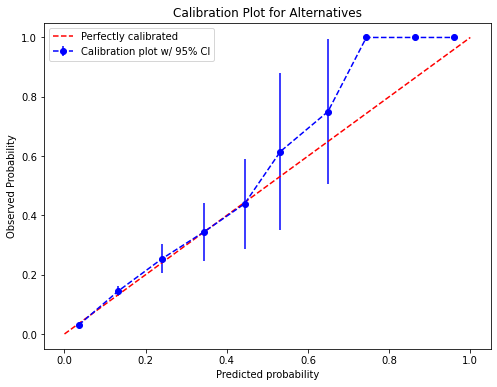

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from scipy.stats import norm
y_pred_column = 'propensity_score'
y_column = 'treatment'
condition_name = 'Alternatives'

# Generate the calibration data
true_prob, pred_prob = calibration_curve(cohort[y_column], cohort[y_pred_column], n_bins=10, strategy='uniform')

# Calculate bin sizes
bin_sizes = np.histogram(cohort[y_pred_column], bins=10, range=(0, 1))[0]

# Calculate standard error for the binomial proportion in each bin
se = np.sqrt(true_prob * (1 - true_prob) / bin_sizes)

# Calculate the z-value for the 95% confidence interval
z = norm.ppf(0.975)  # Two-tailed, hence 0.975 instead of 0.95

# Calculate the confidence intervals
ci_lower = true_prob - z * se
ci_upper = true_prob + z * se

# Plotting the calibration curve with error bars
plt.figure(figsize=(8, 6))
plt.errorbar(pred_prob, true_prob, yerr=z * se, fmt='o--', color='b', label='Calibration plot w/ 95% CI')
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Perfectly calibrated')
plt.xlabel('Predicted probability')
plt.ylabel('Observed Probability')
plt.title(f'Calibration Plot for {condition_name}')
plt.legend()
plt.show()